<a href="https://colab.research.google.com/github/benmellin/msc_project/blob/main/Cluster_pathwayID_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Idea: What if we unsupervised clustered our cells, and then followed that by a pathway analysis to see which pathways are enriched in each cluster.

- This might give us a way to confirm/deny the results of our model.
- Could be helpful in better understanding what each type of cell is doing in a specific cell set, and give us an idea of what cells our model is predicting to do what.
- I'd like to work towards a similar approach as [this](https://www.nature.com/articles/s41598-020-66848-3.pdf),
but I want start with something a little more simple here.
- Much of this code is copied from Diego's unsupervised learning experiments

## Experiment on existing MSC data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install igraph
!pip install anndata
!pip install scanpy
!pip install numpy
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
from anndata import AnnData


file_path2 = '/content/drive/My Drive/The One True Folder/Sandia-Cell-NC State/final_combat_data.txt'



anndata1 = sc.read_csv(file_path2).T

print(anndata1.shape)


(9938, 16359)


In [ ]:
print(anndata1.obs)

Empty DataFrame
Columns: []
Index: [b6_AAACGCTGTAATGCGG.1, b6_AAAGAACTCAACTGGT.1, b6_AAAGAACTCTCATTAC.1, b6_AAAGGTACAGAACGCA.1, b6_AAAGTCCAGACATAAC.1, b6_AAATGGAAGAGTGTTA.1, b6_AAATGGAGTCCCGCAA.1, b6_AAATGGAGTTAATCGC.1, b6_AACAAAGAGCTAGCCC.1, b6_AACAAAGCACATGTTG.1, b6_AACAAAGCATCCGGCA.1, b6_AACAACCCAAACGAGC.1, b6_AACAGGGCACCATTCC.1, b6_AACCACAGTTTATGCG.1, b6_AACCACATCCCTTGTG.1, b6_AACCCAACAGCTCGGT.1, b6_AACCTGAAGTACCCTA.1, b6_AACCTGACACATGACT.1, b6_AACCTTTGTATGCGGA.1, b6_AACGGGATCCCATACC.1, b6_AACGTCACATCCCACT.1, b6_AAGACAAAGTCGAGGT.1, b6_AAGACTCTCCCGAGAC.1, b6_AAGATAGGTTGTGGCC.1, b6_AAGATAGTCAGTGTCA.1, b6_AAGCATCAGCGACTTT.1, b6_AAGCATCAGGGAGGTG.1, b6_AAGCCATAGTGCACTT.1, b6_AAGCCATCAATTGAGA.1, b6_AAGCGTTGTATCGGTT.1, b6_AAGGAATAGCTGCCTG.1, b6_AAGGTAAGTCAGGTAG.1, b6_AAGTCGTAGTCGAATA.1, b6_AAGTGAACAAGTATCC.1, b6_AATAGAGCACTGCTTC.1, b6_AATCACGCAATAGTAG.1, b6_AATCACGCAGGACAGT.1, b6_AATCGACGTCGAGCAA.1, b6_AATCGTGCACATATCG.1, b6_AATGAAGGTCTGTAGT.1, b6_AATGCCAAGAACTCCT.1, b6_AATGCCAGTTGCTCGG.1

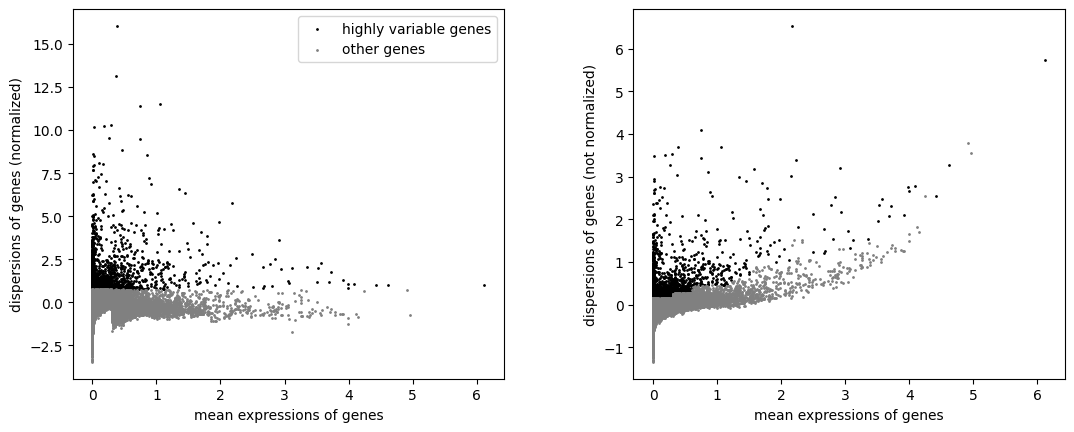

In [ ]:
"""
Followed the scanpy preprocessing and clustering tutorials
"""
#Normalize total counts to 10,000 per cell
sc.pp.normalize_total(anndata1, target_sum=1e4)

#Log-transform the data
sc.pp.log1p(anndata1)

sc.pp.highly_variable_genes(anndata1, n_top_genes=2000) #Change n_top_genes
sc.pl.highly_variable_genes(anndata1)  #Visualize highly variable genes



In [ ]:
# Scale the data and run PCA
sc.pp.scale(anndata1)
sc.tl.pca(anndata1, n_comps=15)  # Run PCA with 15 components
# Compute neighborhood graph using the first 15 PCs
sc.pp.neighbors(anndata1, n_pcs=15, n_neighbors=10)

In [ ]:
#Perform Leiden clustering algorithm
sc.tl.leiden(anndata1, flavor="igraph", n_iterations=4, resolution = .5) #I want less clusters

#Run UMAP for visualization
sc.tl.umap(anndata1)

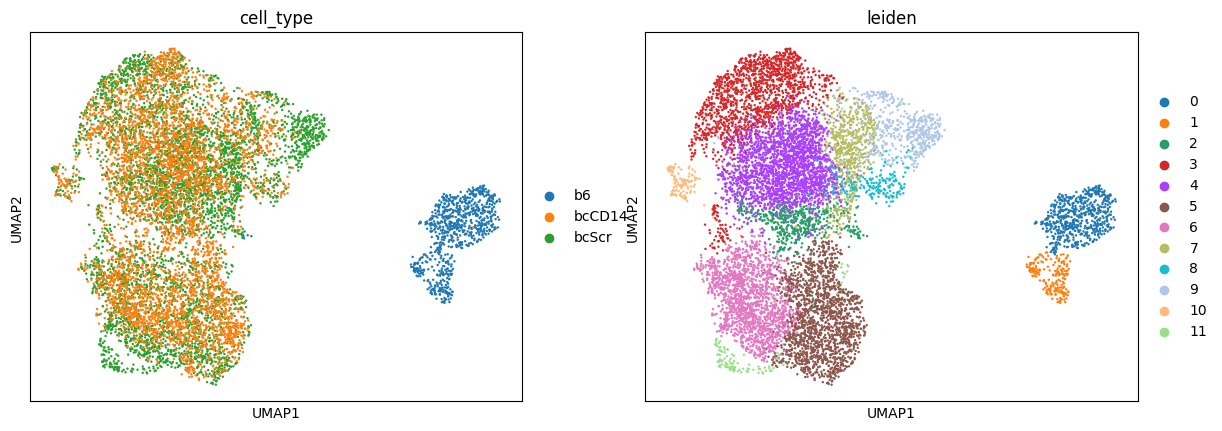

In [ ]:
def assign_label(cell_name):
  if 'b6' in cell_name:
    return "b6"
  elif 'bcCD14' in cell_name:
    return 'bcCD14'
  elif 'bcScr' in cell_name:
    return 'bcScr'
  else:
    return 'unknown'


def assign_lps_labels(cell_name):
  last_underscore_pos = cell_name.rfind('_')
  cell_lps_type = cell_name[:last_underscore_pos]
  return cell_lps_type

def assign_antimicrobial_label(cell_name):
  if 'b6' in cell_name:
    return 1 #antimicrobial
  elif 'bcCD14' in cell_name:
    return 1
  elif 'bcScr' in cell_name:
    return 0 #nonantimicrobial
  else:
    return 'unknown'


# Apply the function to assign labels
anndata1.obs['cell_type'] = anndata1.obs.index.map(assign_label)
anndata1.obs['cell_lps_label'] = anndata1.obs.index.map(assign_lps_labels)
anndata1.obs['cell_antimicrobial_label'] = anndata1.obs.index.map(assign_antimicrobial_label)

# Visualize UMAP with the original labels (antimicrobial/sub-optimal) vs umap with leiden clusters
"""
For leiden, each point is a cell, colors represent clusters identified, each cluster indicates groups of cells with similar gene expression profiles.
"""
#Can anti/sub cells have similar gene expressions why the grouped like that
sc.pl.umap(anndata1, color=["cell_type", "leiden"])

## Let's determine the percent that are antimicrobial in each cluster.

- The percentage indicates the percent of cells in that cluster that are antimicrobial
- The closer the percentage is to 100 or zero, the more uniform that cluster is.

In [ ]:
cluster_percentages = anndata1.obs.groupby('leiden')['cell_antimicrobial_label'].mean() * 100
print(cluster_percentages)

leiden
0    99.875312
1    28.947368
2    52.063983
3    57.841727
4    44.968459
5    51.714286
6    49.580838
7    18.934911
8    56.000000
9     1.204819
Name: cell_antimicrobial_label, dtype: float64


<ipython-input-9-d61e0ca4aa09>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_percentages = anndata1.obs.groupby('leiden')['cell_antimicrobial_label'].mean() * 100


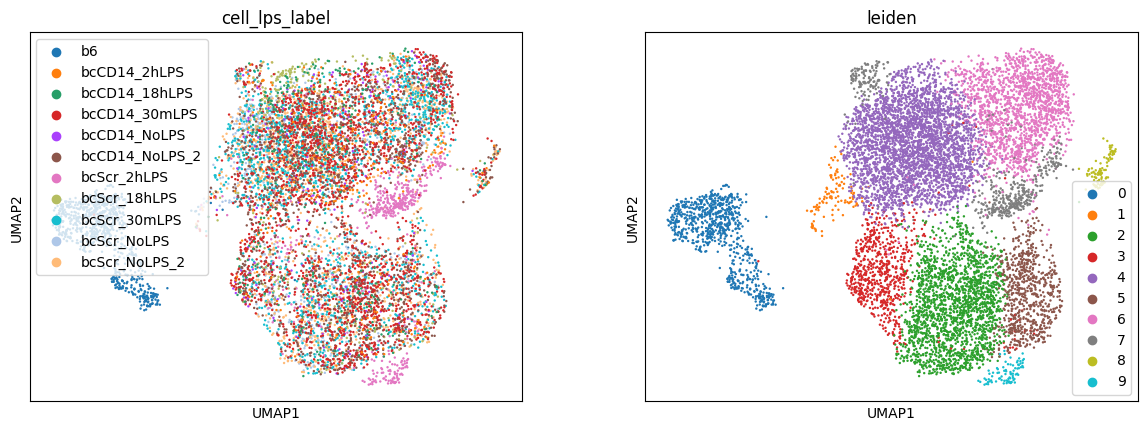

In [ ]:
sc.pl.umap(anndata1, color=['cell_lps_label', "leiden"], legend_loc="best")

Next thing I want to do is identify the specific genes in each particular cluster that are being differentially expressed relative to the rest of the genes.

<ipython-input-11-fcbde2e1121a>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).groupby(anndata1.obs["leiden"]).mean()


          Mrpl15    Lypla1     Tcea1     Rgs20   Atp6v1h    Rb1cc1  \
leiden                                                               
0       0.381932  0.156364  0.596071  0.020472  0.200948  1.083695   
1       0.416185  0.158394  0.653831  0.000000  0.355623  0.715511   
2       0.510456  0.205304  0.739338  0.000169  0.255001  0.907409   
3       0.437152  0.191488  0.804395  0.000000  0.248783  0.670451   
4       0.448466  0.171581  0.737815  0.000126  0.266905  0.783612   
5       0.570437  0.172586  0.776347  0.001100  0.223931  0.724080   
6       0.525856  0.144897  0.752530  0.001056  0.246051  0.667485   
7       0.375489  0.141348  0.760586  0.000000  0.278932  0.776250   
8       0.142757  0.033166  0.195498  0.000000  0.178046  0.292553   
9       0.476253  0.213056  0.721320  0.000000  0.264082  0.904020   

        4732440D04Rik    Alkal1    Pcmtd1   Gm26901  ...     Il1r2  AY358078  \
leiden                                               ...                       

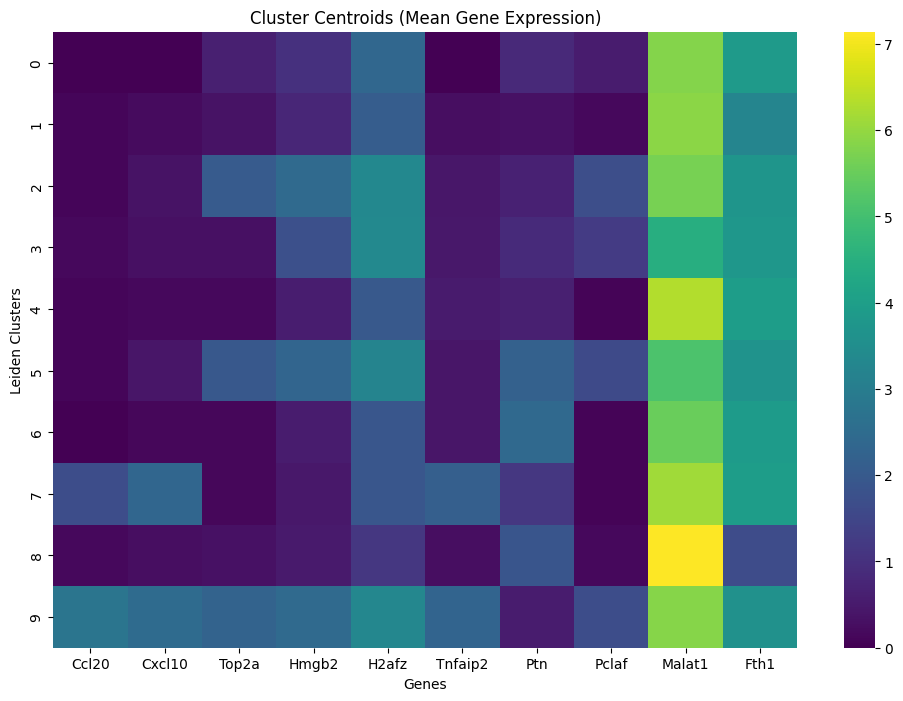

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centroids = pd.DataFrame( #Df to calculate meab
    anndata1.X,
    index=anndata1.obs.index,
    columns=anndata1.var_names
).groupby(anndata1.obs["leiden"]).mean()

print(cluster_centroids) #average expression of each gene across all cells in each cluster


# To make heatmap clear
top_n_genes = 10
gene_variances = cluster_centroids.var().sort_values(ascending=False)
top_genes = gene_variances.index[:top_n_genes]

# Plotty plotty
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centroids[top_genes], cmap="viridis", annot=False) #The brighter the higher expression
plt.xlabel("Genes")
plt.ylabel("Leiden Clusters")
plt.title("Cluster Centroids (Mean Gene Expression)")
plt.show()

#A gene is a potential DEG if its expression is much higher in one cluster compared to others but we do dat below with wilcoxon so i confused is this to compare

In [ ]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(anndata1, groupby="leiden", method="wilcoxon")

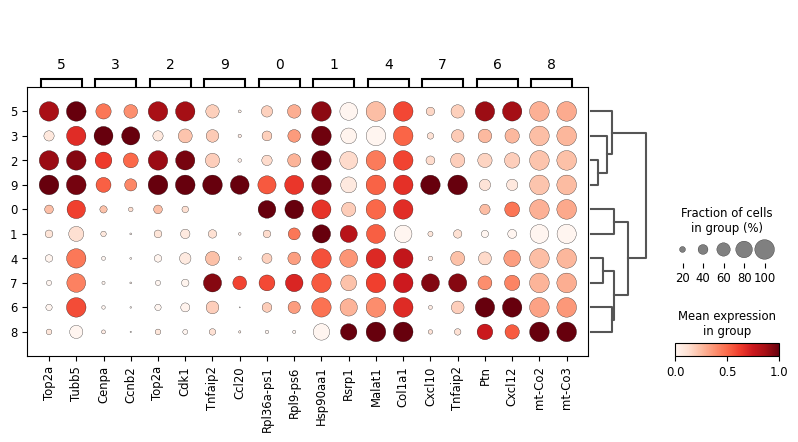

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    anndata1, groupby="leiden", standard_scale="var", n_genes=2
)

## Lets figure out how to do pathway enrichment analysis

- Going to try to roughly follow [this tutorial](https://medium.com/omics-diary/how-to-use-gseapy-for-pathway-enrichment-analysis-67a1aab1002d)

In [ ]:
!pip install gseapy
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2
import csv
import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.2/549.2 kB 9.2 MB/s eta 0:00:00


### Get differentially expressed genes for a cluster.

In [ ]:
# Here, we are grabbing only the most differentially expressed genes: those that have a logfold change of greater than 1, and an adjusted pvalue of greater than .05
ranked_genes_7 = sc.get.rank_genes_groups_df(anndata1, group="7",pval_cutoff=.05, log2fc_min=1)

In [ ]:
gene_names_7 = ranked_genes_7['names']

print(gene_names_7)

0       Cxcl10
1      Tnfaip2
2        Slfn2
3        Ripk2
4        Ccl20
        ...   
229    St3gal1
230       Rgs4
231       Mmp9
232      Ptges
233     Elovl7
Name: names, Length: 234, dtype: object


In [ ]:
gene_str = ""
for name in gene_names_7:
  gene_str = gene_str+name+","
print(gene_str)

Cxcl10,Tnfaip2,Slfn2,Ripk2,Ccl20,Cx3cl1,Tnfaip3,Ccl7,Irf1,Gbp2b,Flt1,Zc3h12a,Lif,Cebpd,Cxcl5,Noct,Nfkbiz,Hk2,Vcam1,Il1rl1,Cxcl1,Gbp7,Ccl2,Hivep3,Ptgs2,Socs3,Hivep1,Hivep2,Egr3,Rnf19b,Mt2,Slc7a2,Errfi1,Gbp2,Rel,Rpl9-ps6,Jak2,Parp14,Rpl36a-ps1,Rnd1,Cdkn1a,Rpl10-ps3,Zeb1,Csf2,Il6,Osmr,Plscr1,Has2,Pfkfb3,Gm10036,Btg2,Gm16685,Stx11,Kdm6b,Tnc,Stk40,Gbp3,Ell2,Ccl5,Susd6,Rab8b,Ifit1,Nrip1,Pde4b,Tlr2,Ereg,Arrdc3,Prag1,Tiparp,Tnip1,Tbx3,Sele,Clec2d,Casp4,Fas,Ifi203,Klf10,Rhob,Rrad,Cxcl9,Rab32,Col27a1,Pim1,Gbp5,Bcor,Csrnp1,Bach1,Fam46a,B4galt5,Ch25h,Iigp1,Mex3b,Ifih1,Birc3,Icam1,Herc6,Dusp5,Nfkbie,Mylip,Gem,Pdgfb,Stat5a,Trim47,Slfn8,Bhlhe40,Lhfpl2,Cxcl2,Gm10269,Egr2,Klf5,Gm10320,Adamts4,Trib1,Rpl13a-ps1,Foxc2,Rasgef1b,Spsb1,Cish,Egln3,Fbxo32,Rgs16,Socs2,Rasa2,Cp,Dusp6,Smim3,Sik1,Rab20,Bcl2l11,Plau,Gbp9,Rsad2,Bid,Rpl7a-ps5,Zfp263,Kctd11,Cxcl16,F830016B08Rik,Tslp,Il15ra,Rbm47,Maff,Gm6133,Gbp4,Nipal1,Gch1,Mx1,Daam1,Pvr,Serpina3g,Irgm2,Gcnt2,Bahcc1,Ifit3,Bdkrb2,Homer1,3110043O21Rik,Mir155hg,Myd88,Nfa

### Query database

In [ ]:
enr_GOBP_up = gp.enrichr(gene_list=gene_names_7 ,
 gene_sets=['GO_Biological_Process_2021'],
 organism='Mouse',
 outdir='test/enr_DEGs_GOBP_up',
 cutoff=0.5
 )
enr_GOMF_up = gp.enrichr(gene_list= gene_names_7,
 gene_sets=['GO_Molecular_Function_2021'],
 organism='Mouse',
 outdir='test/enr_DEGs_GOMF_up',
 cutoff=0.5
 )
enr_GOCC_up = gp.enrichr(gene_list=gene_names_7 ,
 gene_sets=['GO_Cellular_Component_2021'],
 organism='Mouse',
 outdir='test/enr_DEGs_GOCC_up',
 cutoff=0.5
 )



In [ ]:
input_genes = set(gene.upper() for gene in gene_names_7)
# Get genes that were actually used in enrichment
enriched_genes = set(enr_GOBP_up.results["Genes"].str.split(";").explode())

# Find missing genes
missing_genes = input_genes - enriched_genes
print("Missing genes:", missing_genes)
print(len(missing_genes))

Missing genes: {'GM13889', 'NEURL3', 'GM8797', 'ICOSL', 'BAHCC1', 'RPL7A-PS5', 'IFI203', 'IFI47', 'ZFP945', 'GM10320', 'GM10036', 'TGTP2', 'FAM46A', 'SLFN2', 'PSME2B', 'RPL13A-PS1', 'RPL10-PS3', 'AC127341.3', 'GBP2B', 'IFI207', 'GM10269', 'PXDC1', 'GBP9', 'F830016B08RIK', 'PHF11B', '3110043O21RIK', 'GM10031', 'ABTB2', 'SLFN8', 'IFIT3B', 'RPL9-PS6', 'PLXDC2', 'GM4841', 'EVA1C', 'SAA3', 'MT2', 'RASGEF1B', 'IGTP', 'IRGM2', 'GM6634', 'IIGP1', 'ZFP263', 'PDE5A', 'OASL1', 'RPL36A-PS1', 'MIR155HG', 'PQLC1', 'GM16685', 'SMIM3', 'SERPINA3G', 'TMEM140', 'GM11273', 'STK40', 'GM6133', 'RBM47'}
55


<Axes: title={'center': 'GO Biological Processes Group 7'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

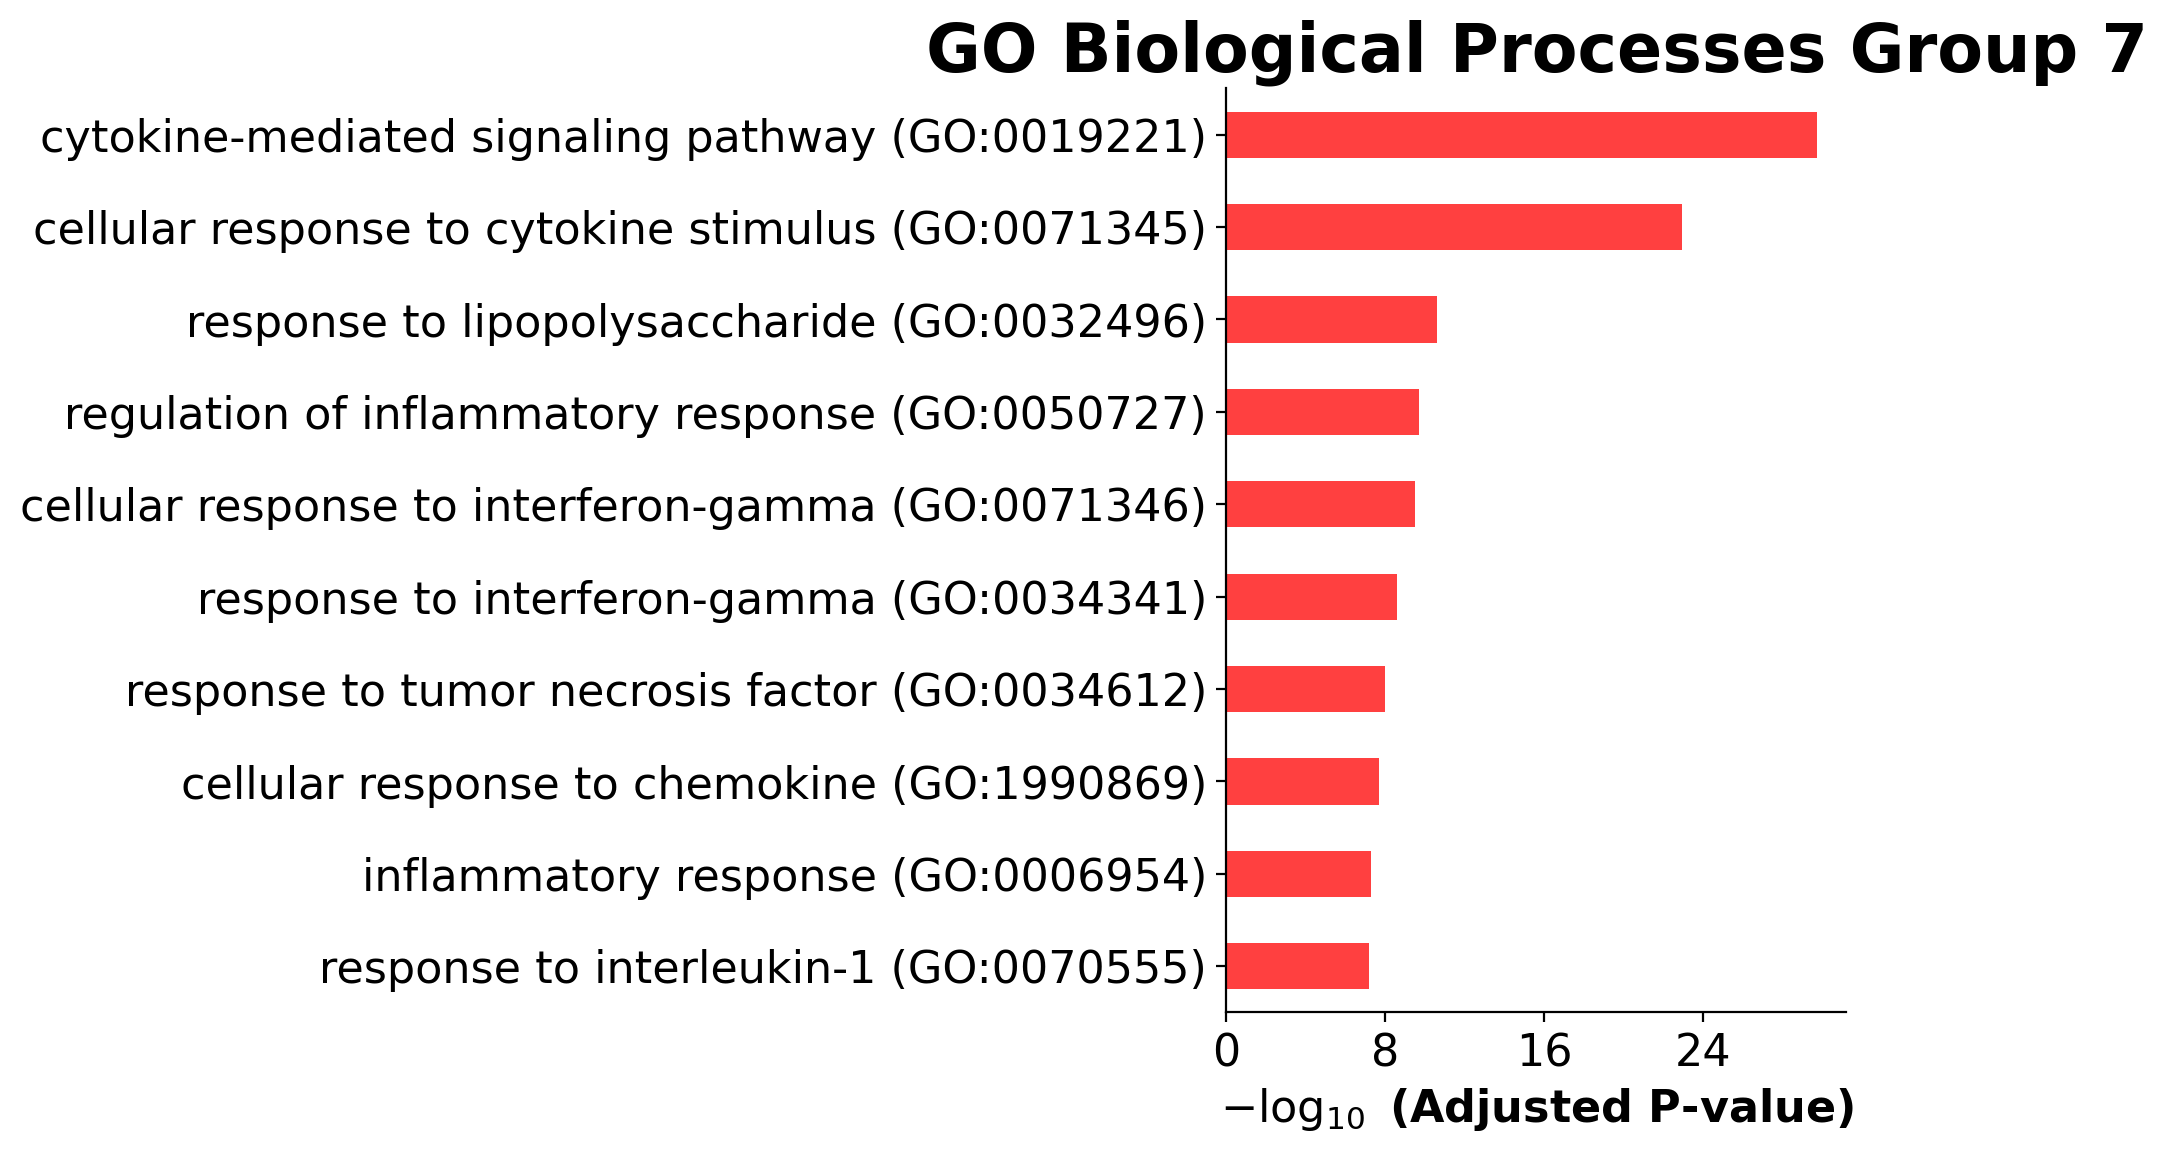

In [ ]:
from gseapy.plot import barplot, dotplot
barplot(enr_GOBP_up.res2d,title='GO Biological Processes Group 7',color = 'r')

<Axes: title={'center': 'GO Molecular Function Group 7)'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

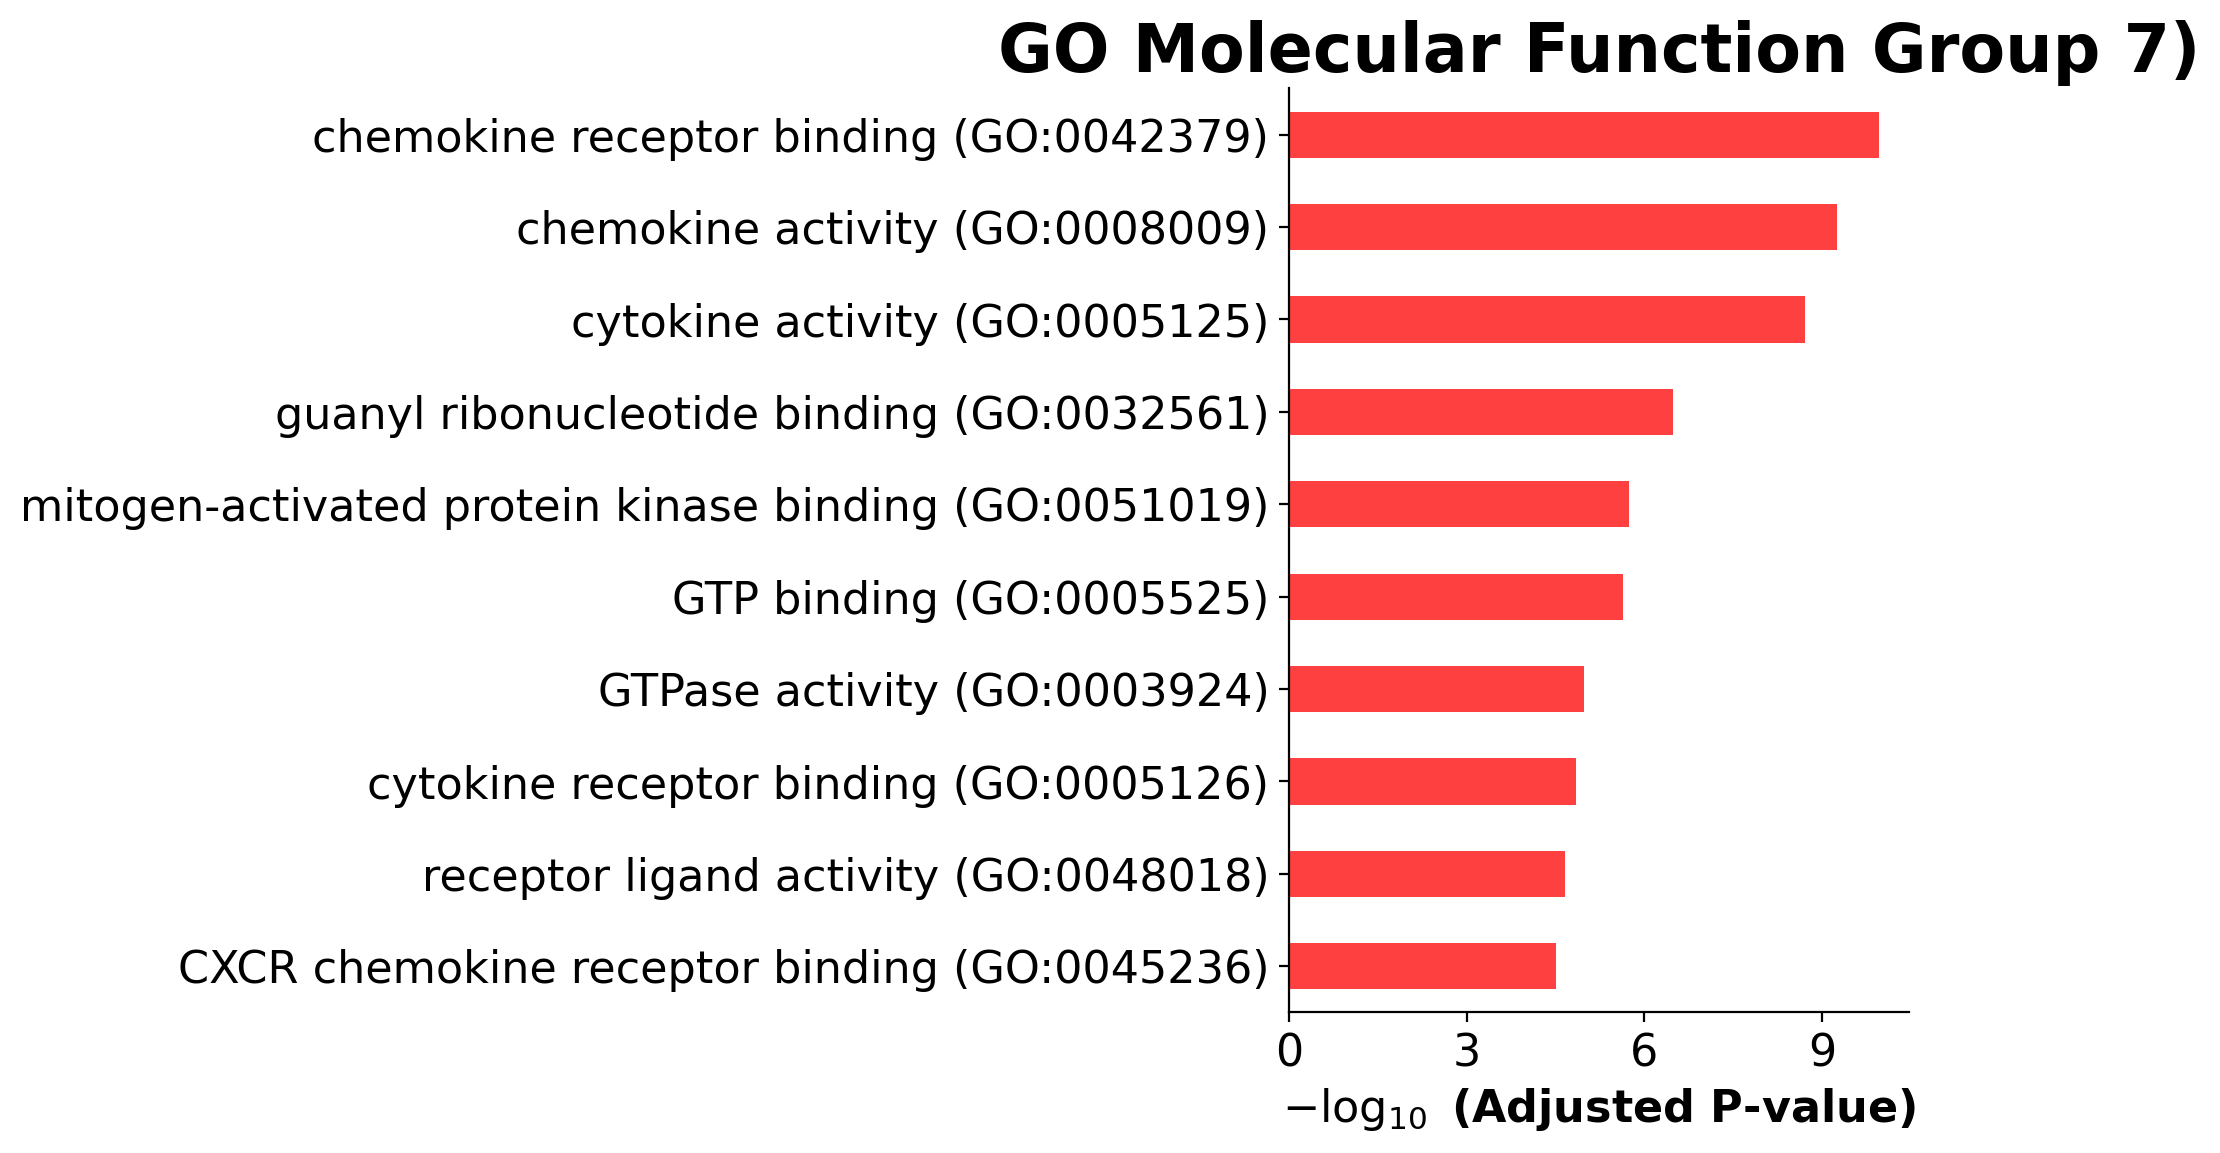

In [ ]:
barplot(enr_GOMF_up.res2d,title='GO Molecular Function Group 7)',color = 'r')
#

In [ ]:

barplot(enr_GOCC_up.res2d,title='GO Cellular Component Group 7',color = 'r')


ValueError: Warning: No enrich terms when cutoff = 0.05

## Now that we have done this for group 7, lets try and automate this process for all groups

In [ ]:
# First, we create a dictionary containing the group name as key, and the differentially expressed genes as values
gene_dict = {}
for group_num in range(10): # iterate over the group numbers
  group_num = str(group_num) #make sure it is a string
  ranked_genes = sc.get.rank_genes_groups_df(anndata1, group=group_num,pval_cutoff=.05, log2fc_min=1)
  gene_names = ranked_genes['names']
  gene_dict[group_num] = gene_names


In [ ]:
print(gene_dict["7"])
get_enriched_pathways(gene_dict["7"])

0       Cxcl10
1      Tnfaip2
2        Slfn2
3        Ripk2
4        Ccl20
        ...   
229    St3gal1
230       Rgs4
231       Mmp9
232      Ptges
233     Elovl7
Name: names, Length: 234, dtype: object


(<gseapy.enrichr.Enrichr at 0x7ccf3b3d6410>,
 <gseapy.enrichr.Enrichr at 0x7ccf3b717450>)

In [ ]:
# now I want to create a method that takes the differentially expressed genes, queries them, and returns
# returns 3 objects containing enriched pathways from the queries
def get_enriched_pathways(gene_name_list):
  enr_GOBP_up = gp.enrichr(gene_list= gene_name_list,
  gene_sets=['GO_Biological_Process_2021'],
  organism='Mouse',
  outdir='test/enr_DEGs_GOBP_up',
  cutoff=0.5
  )
  enr_GOMF_up = gp.enrichr(gene_list= gene_name_list,
  gene_sets=['GO_Molecular_Function_2021'],
  organism='Mouse',
  outdir='test/enr_DEGs_GOMF_up',
  cutoff=0.5
  )
  enr_GOCC_up = gp.enrichr(gene_list= gene_name_list ,
  gene_sets=['GO_Cellular_Component_2021'],
  organism='Mouse',
  outdir='test/enr_DEGs_GOCC_up',
  cutoff=0.5
  )

  return [enr_GOBP_up, enr_GOMF_up, enr_GOCC_up]

No differentially expressed genes associated with biological pathways for group 1
No differentially expressed genes associated with molecular function for group 1
No differentially expressed genes associated with cellular components for group 1
No differentially expressed genes associated with biological pathways for group 4
No differentially expressed genes associated with molecular function for group 4
No differentially expressed genes associated with cellular components for group 4
No differentially expressed genes associated with cellular components for group 7


/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:839: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=self.figsize)


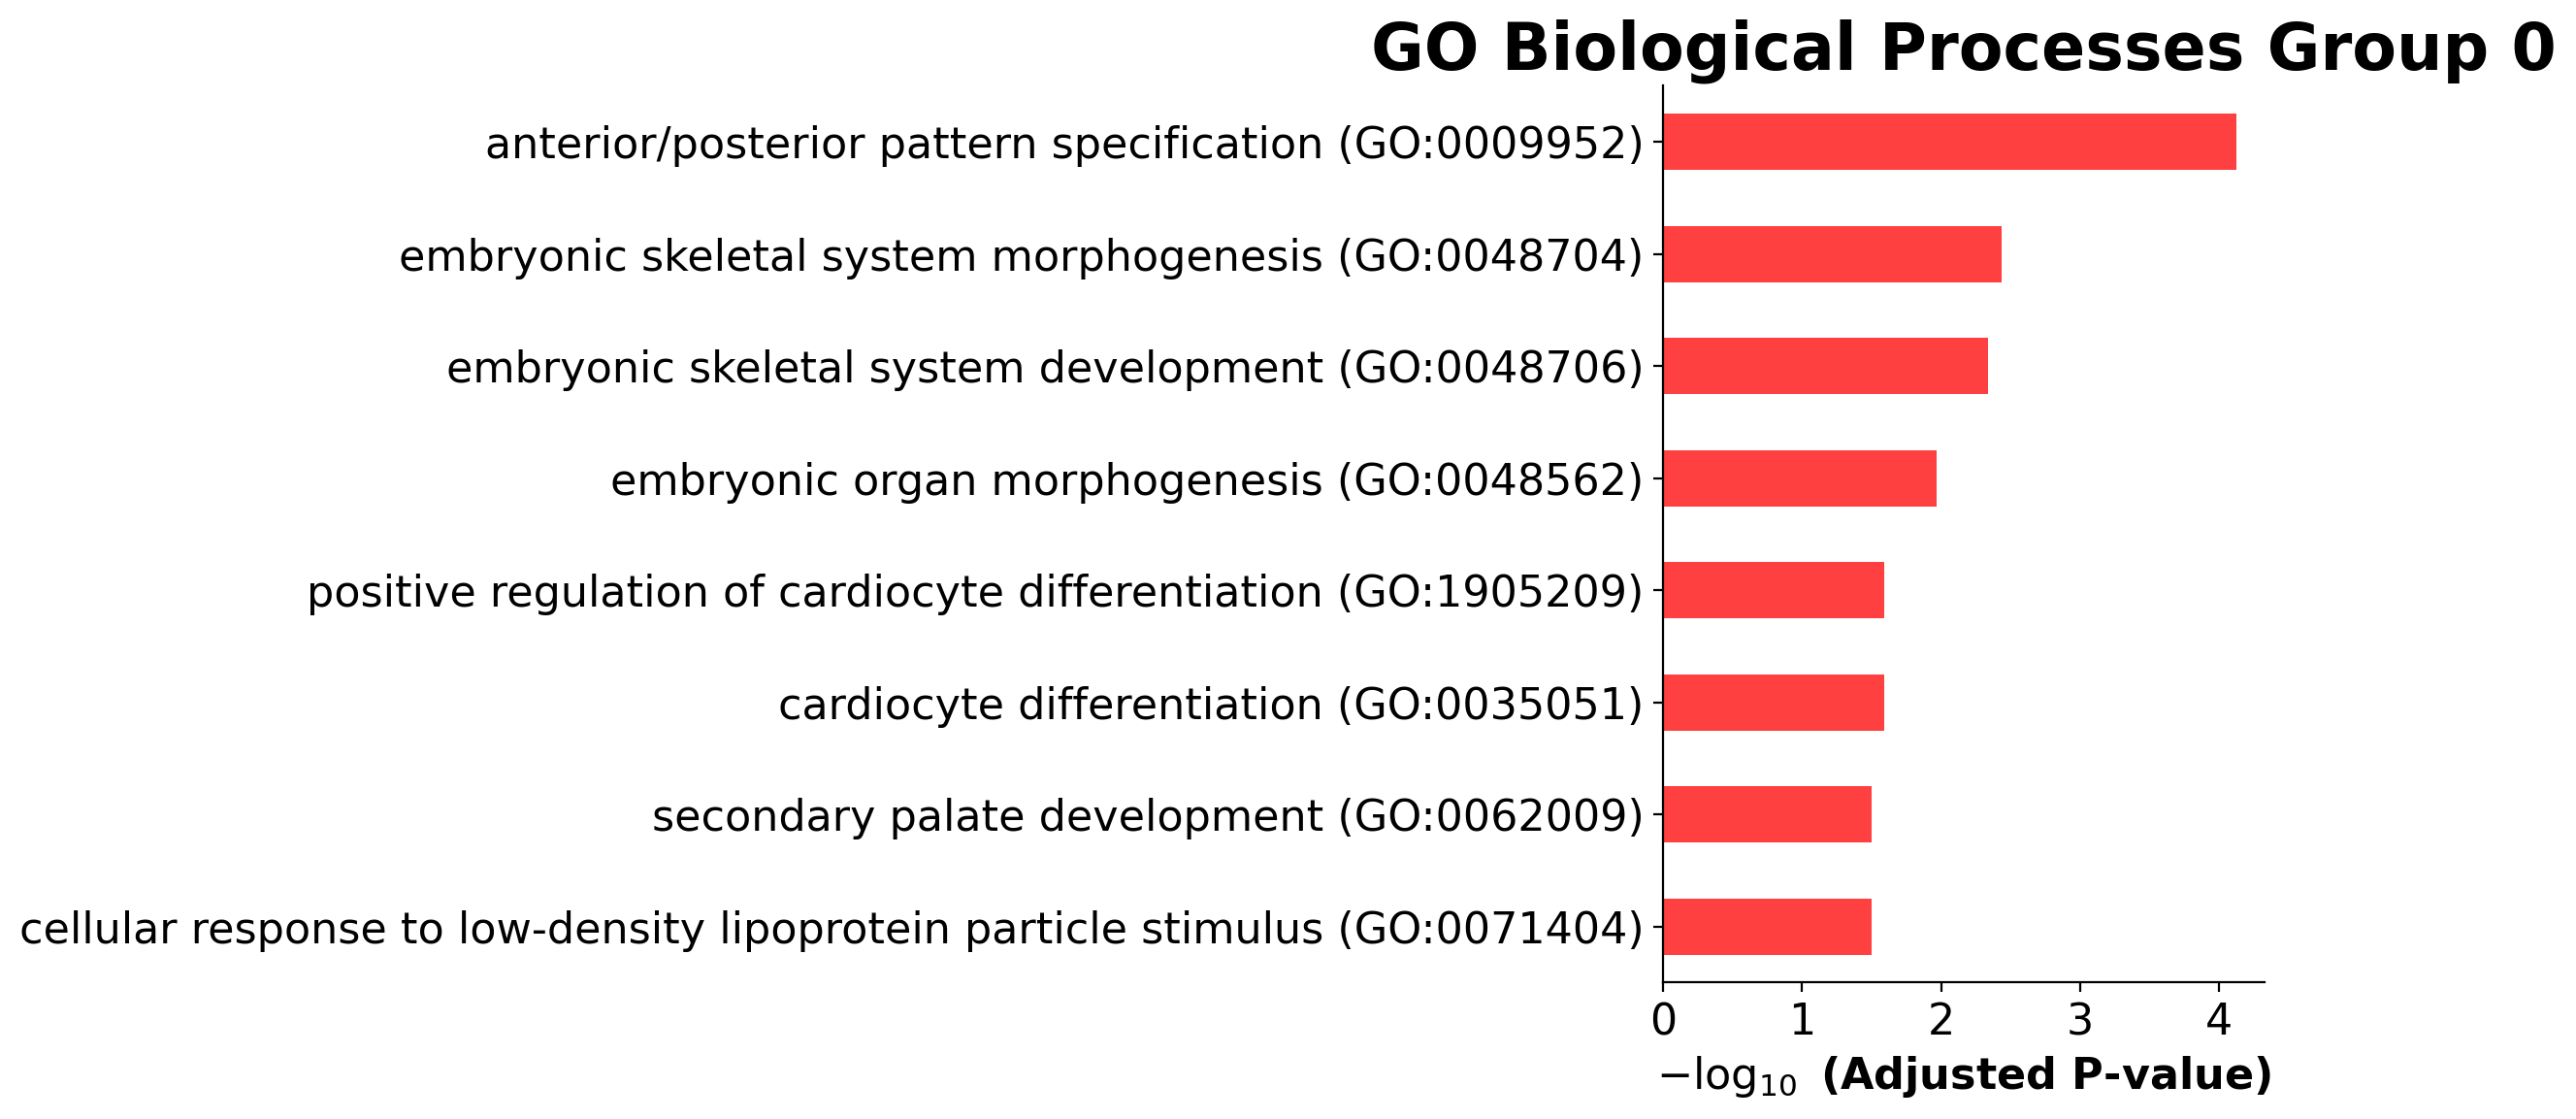

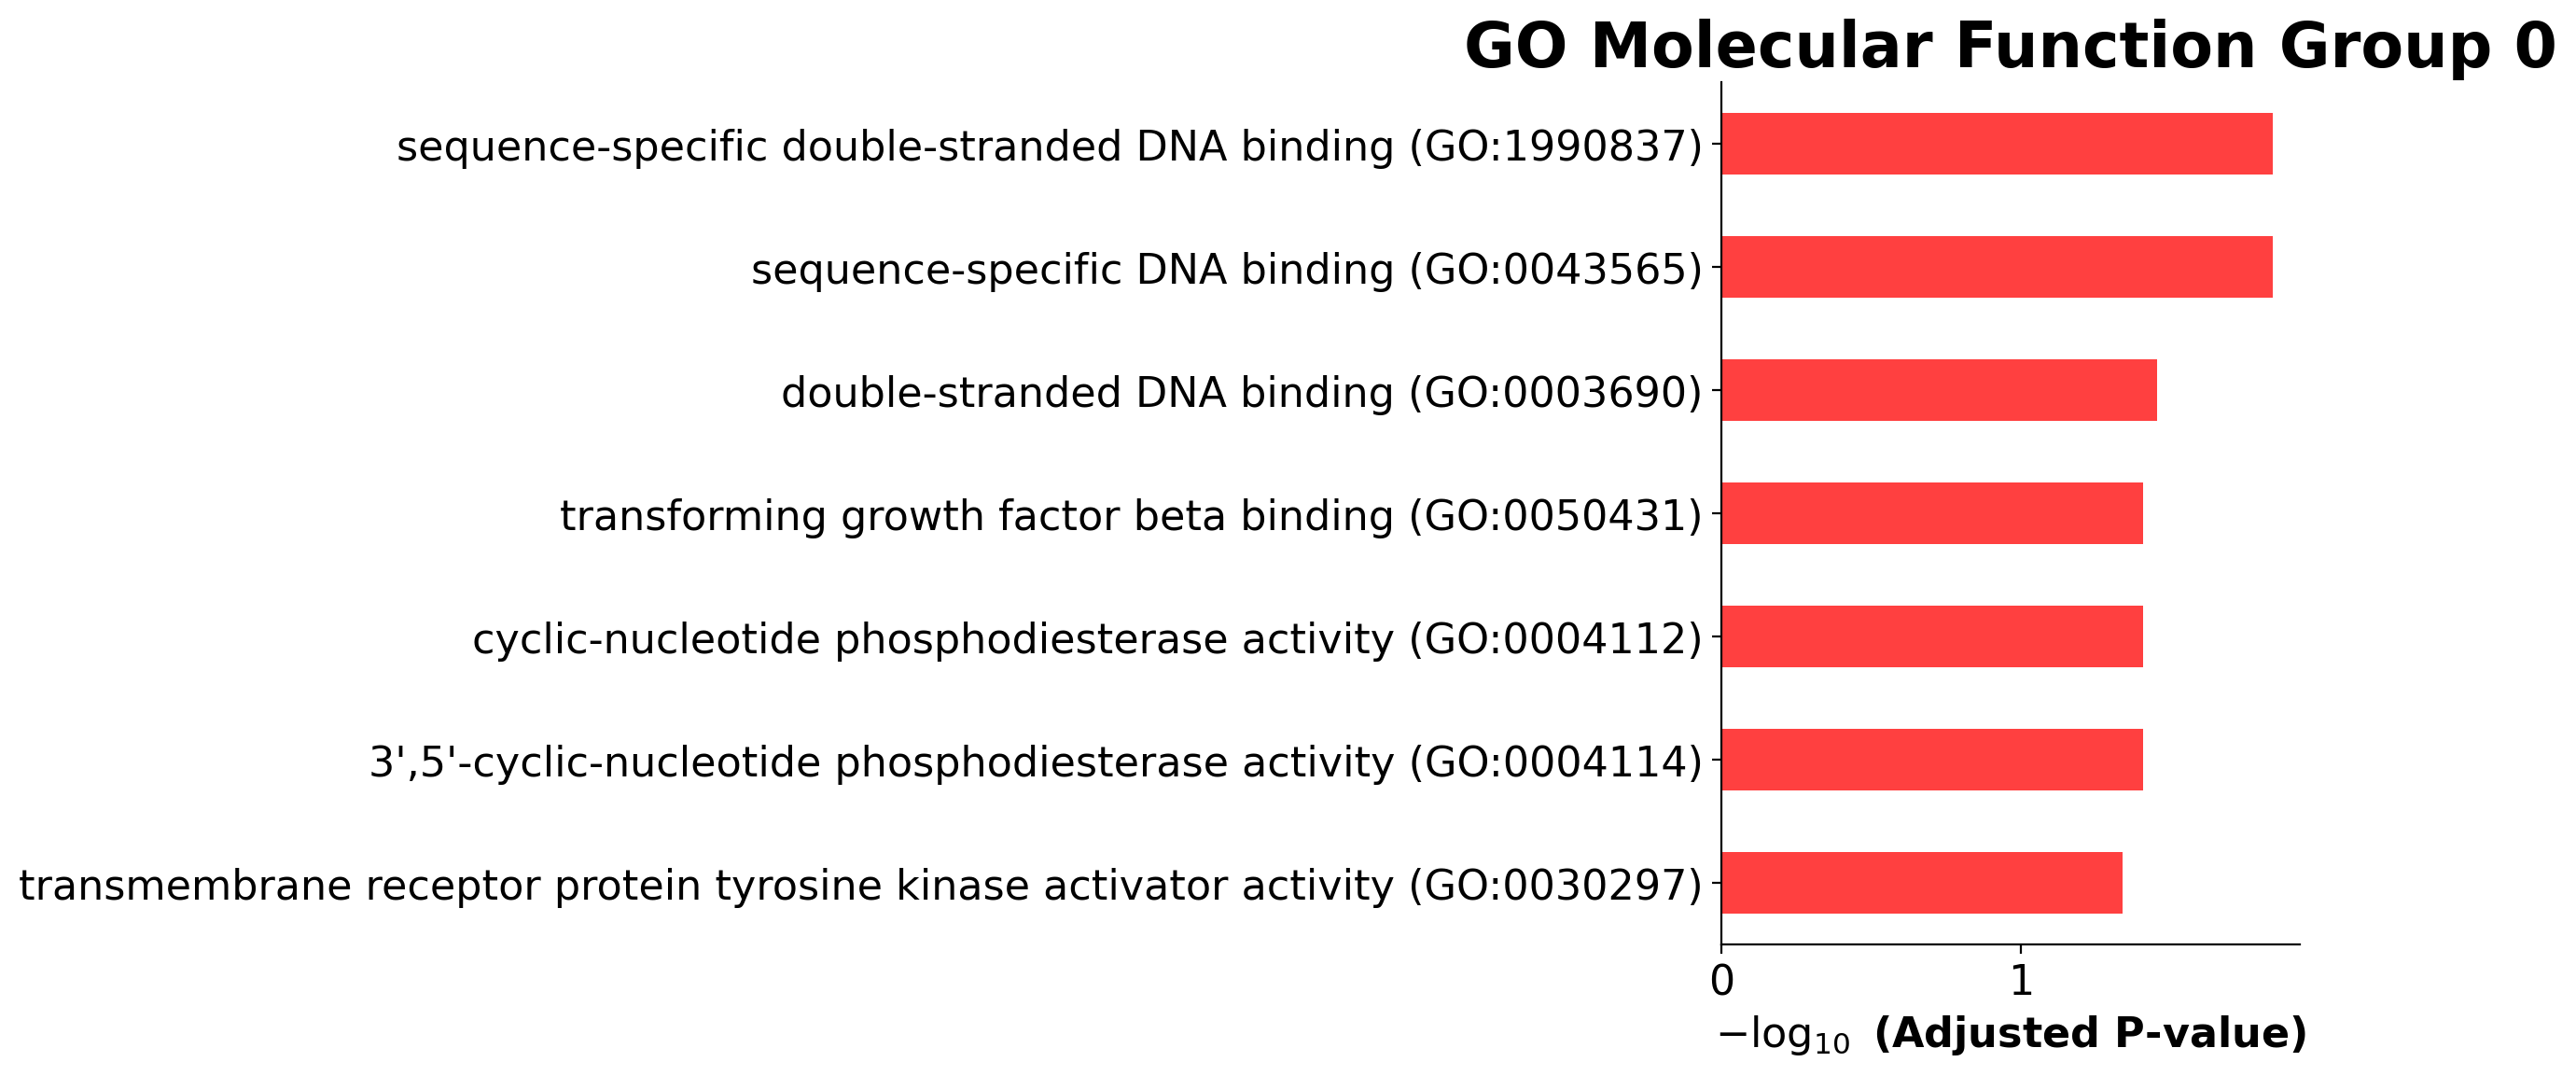

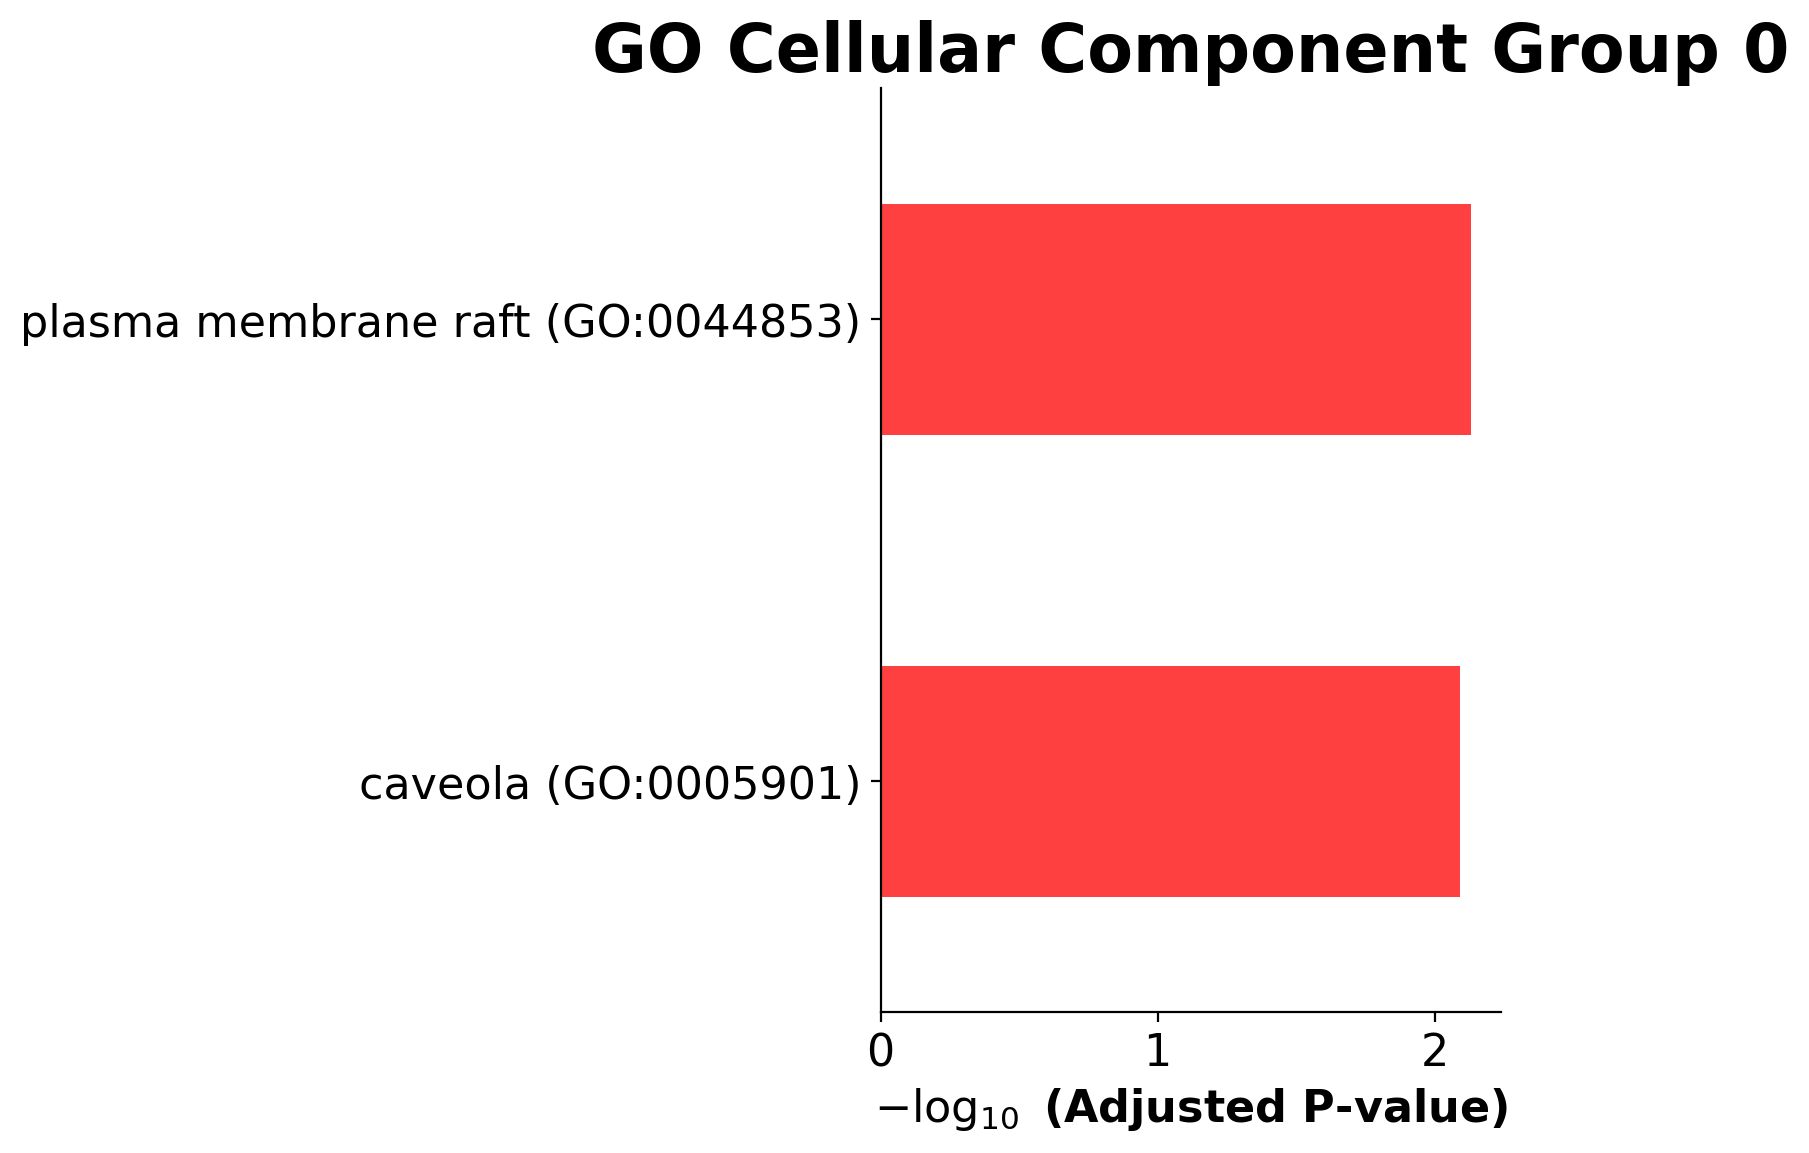

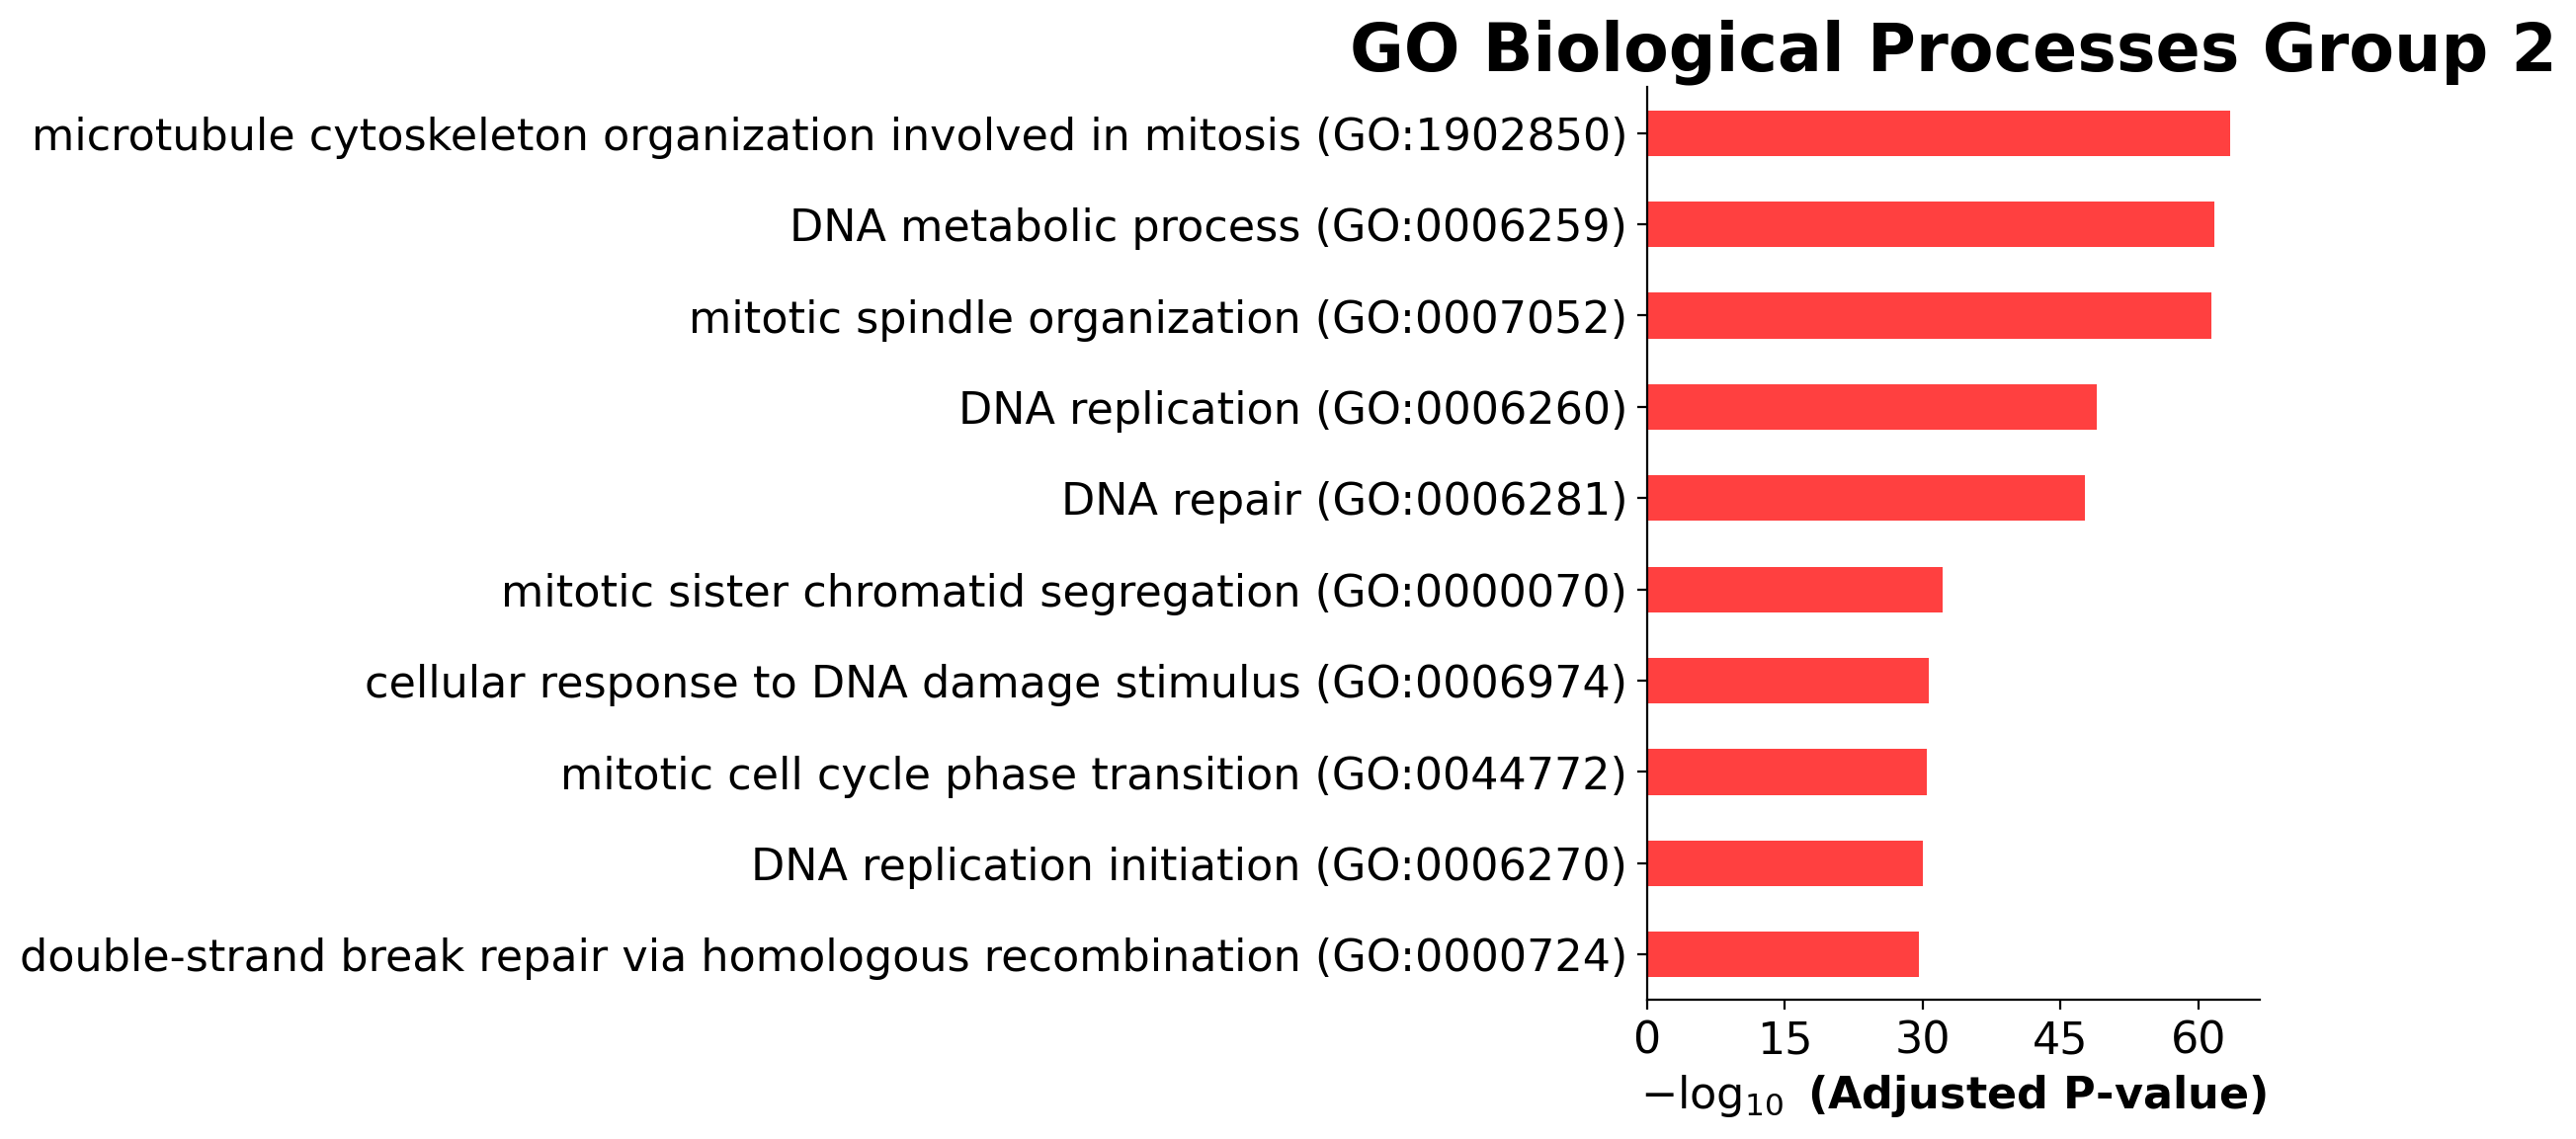

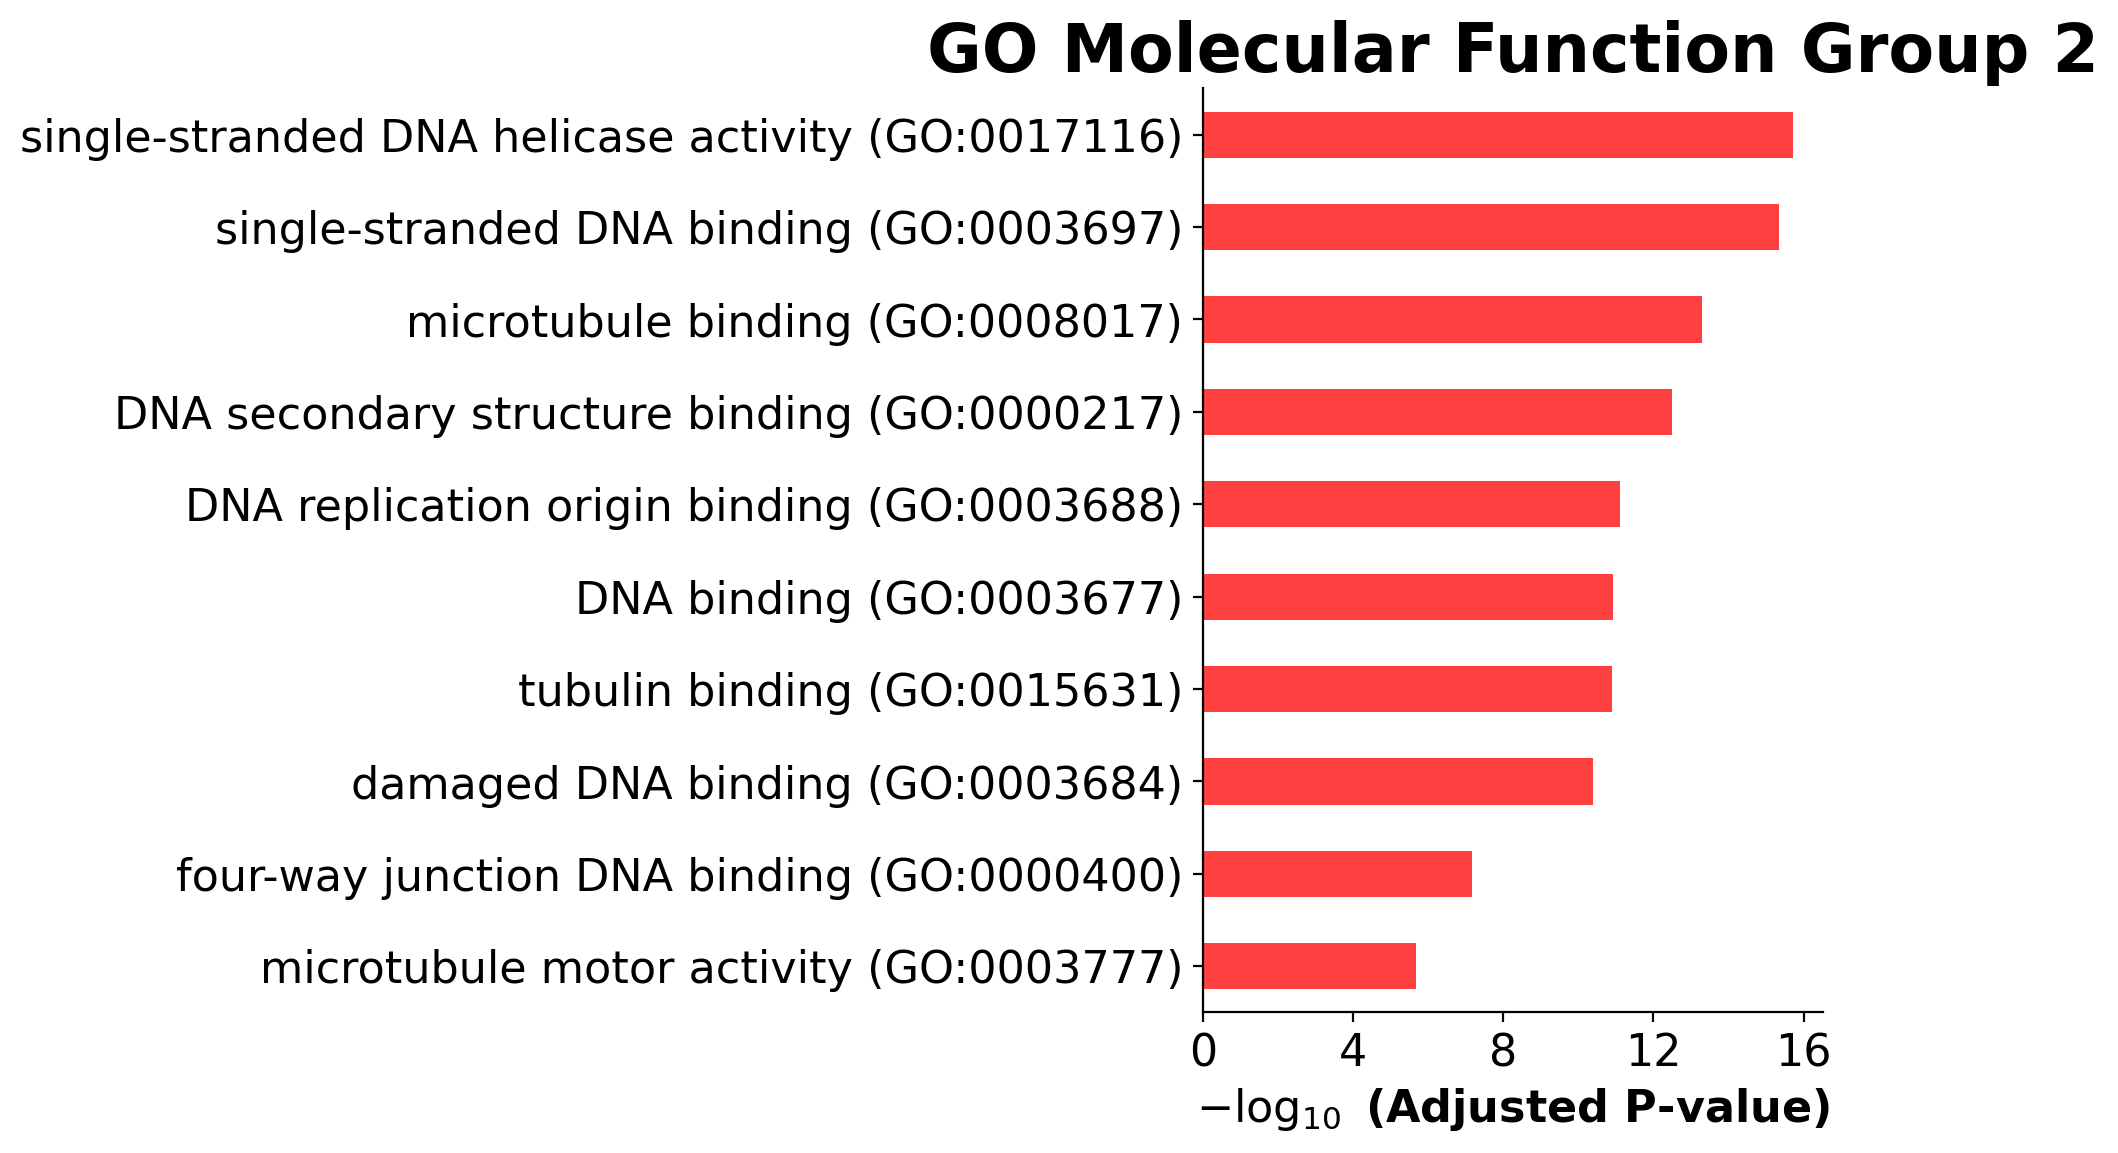

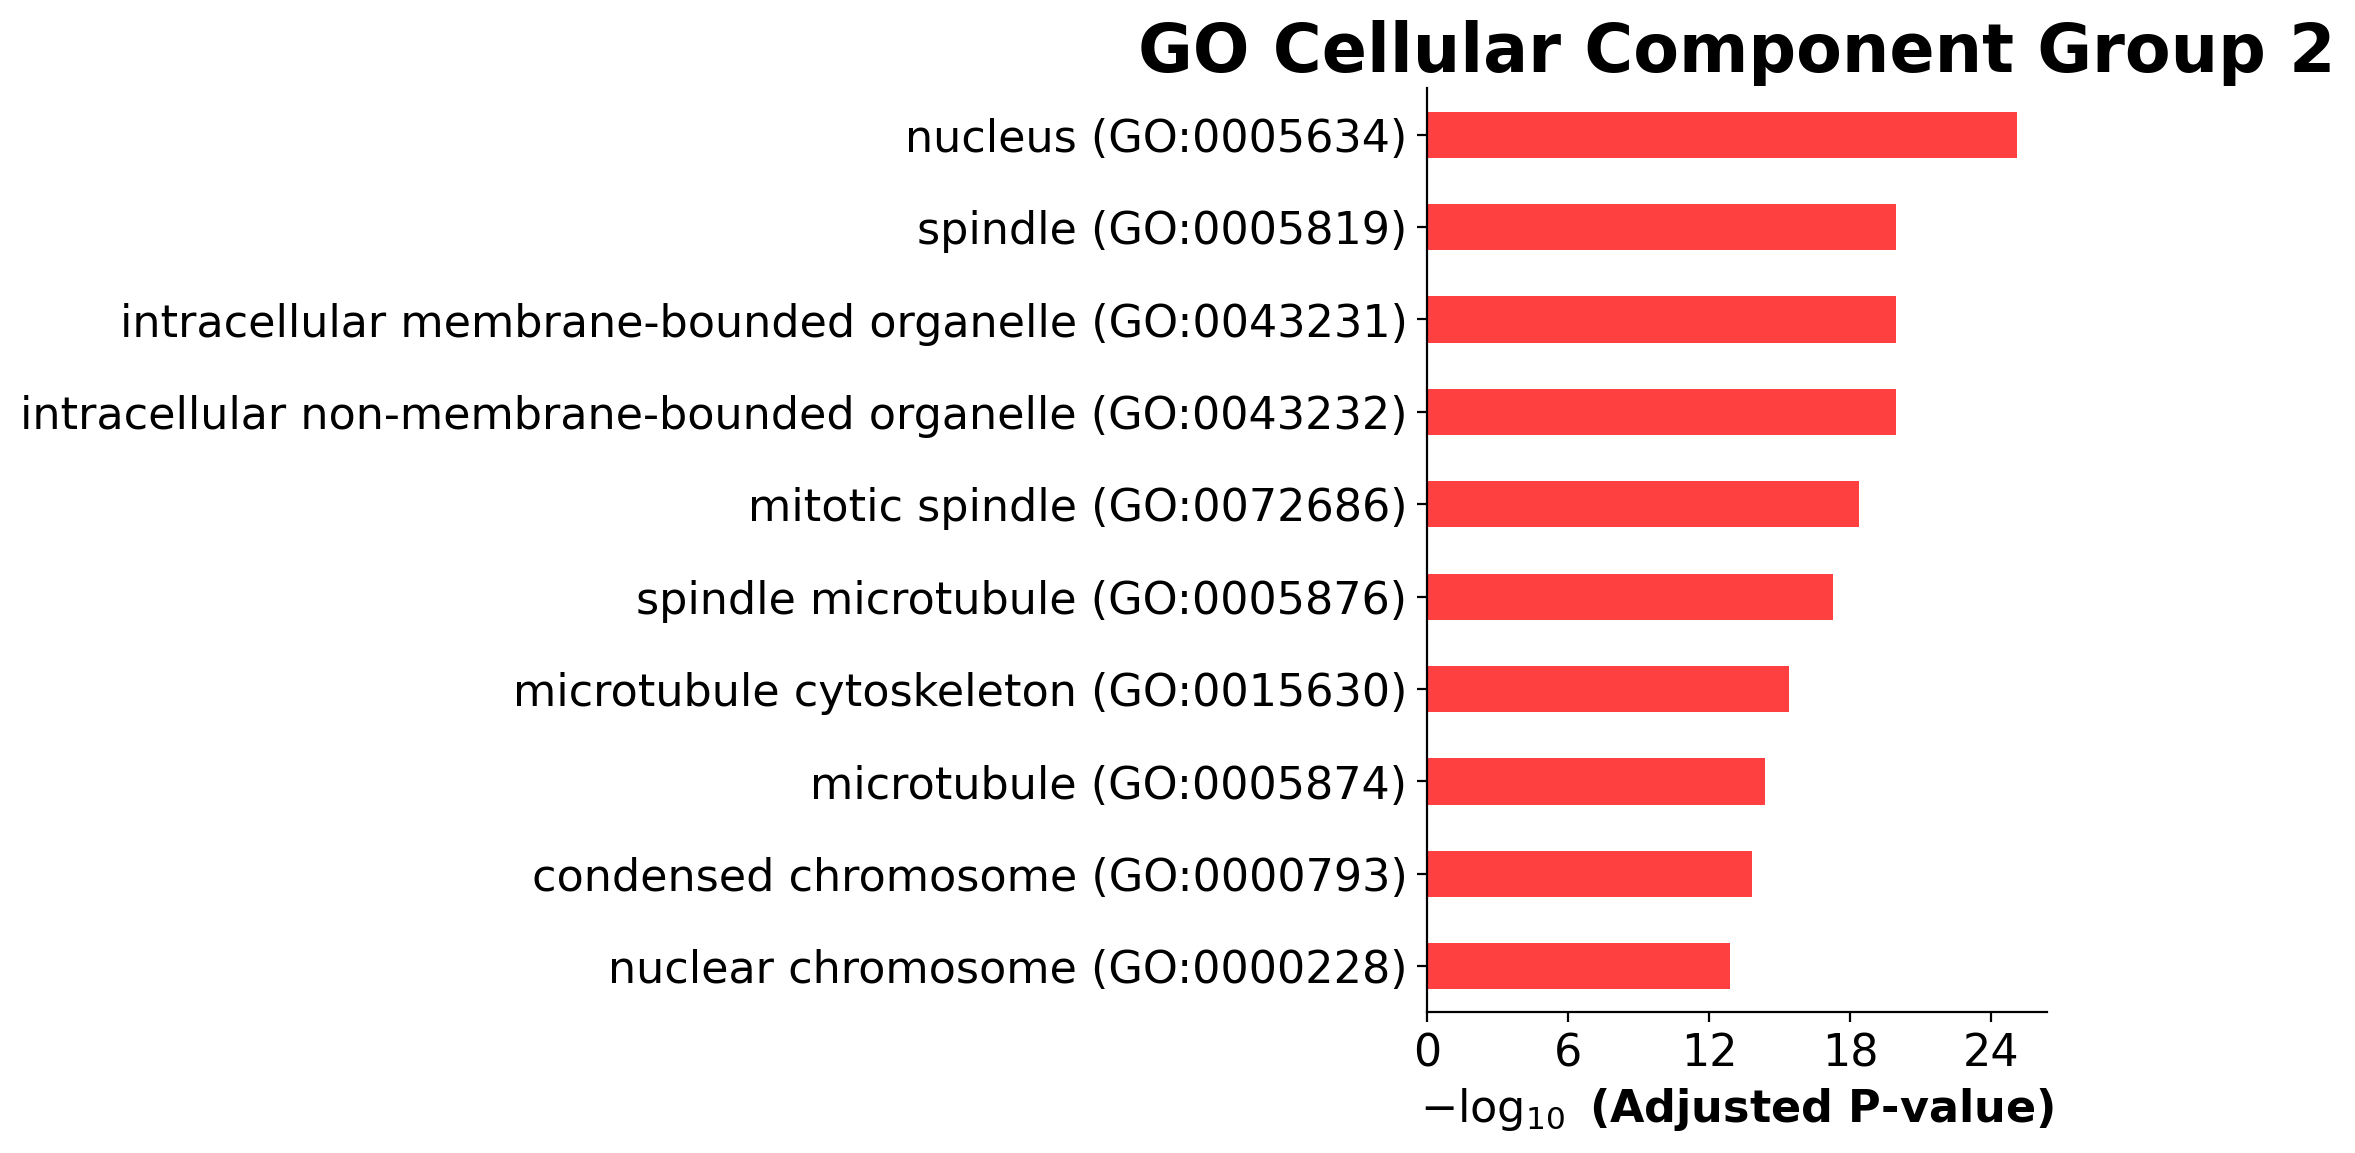

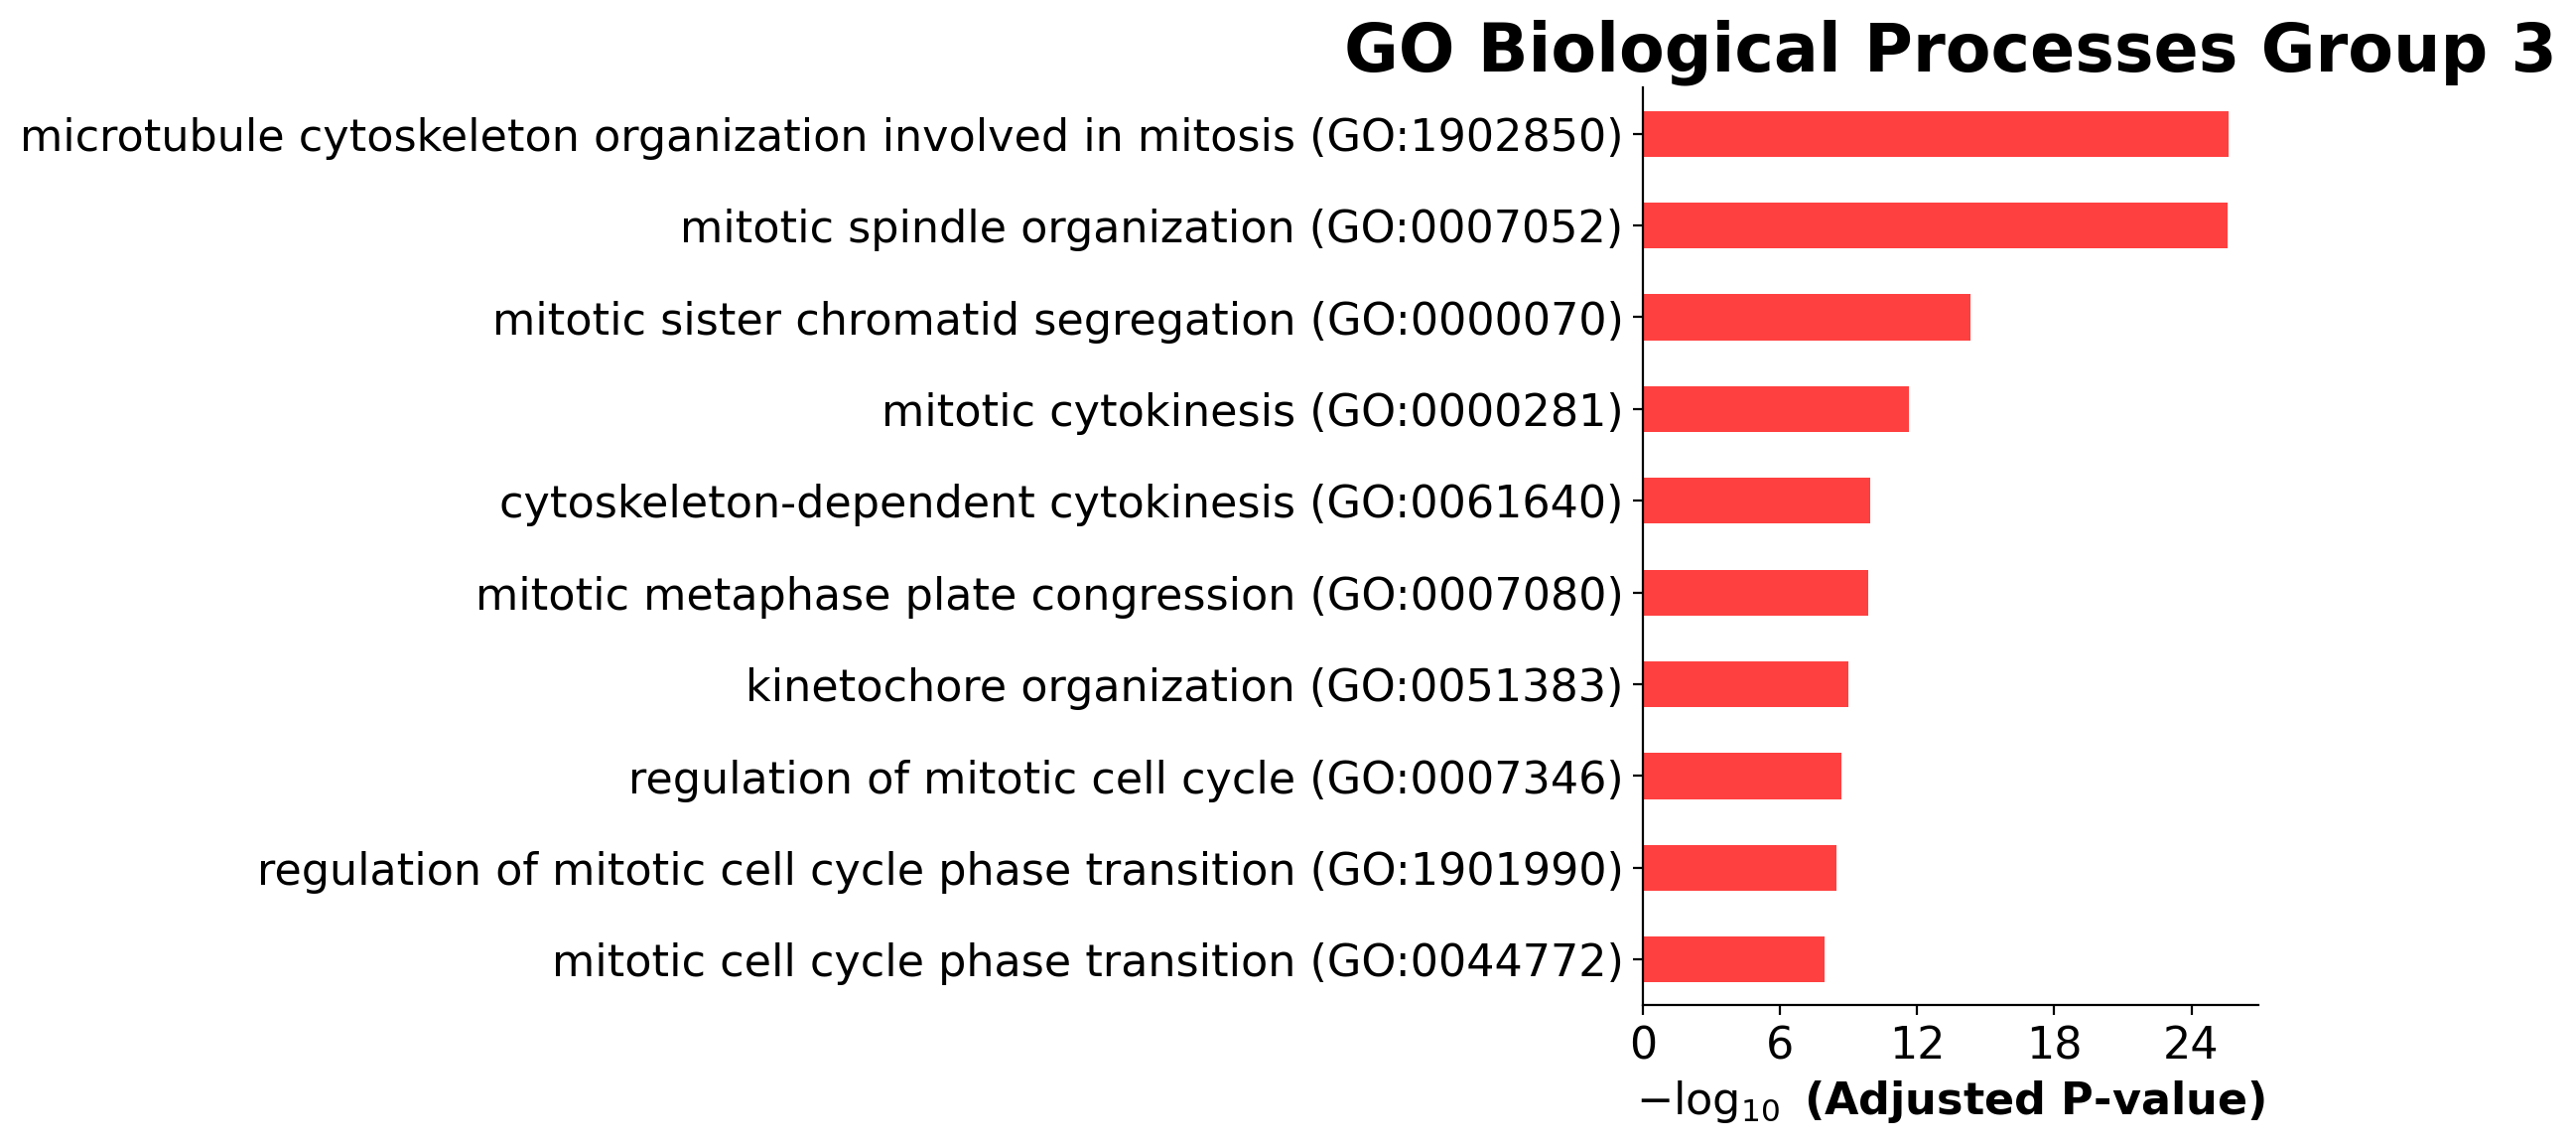

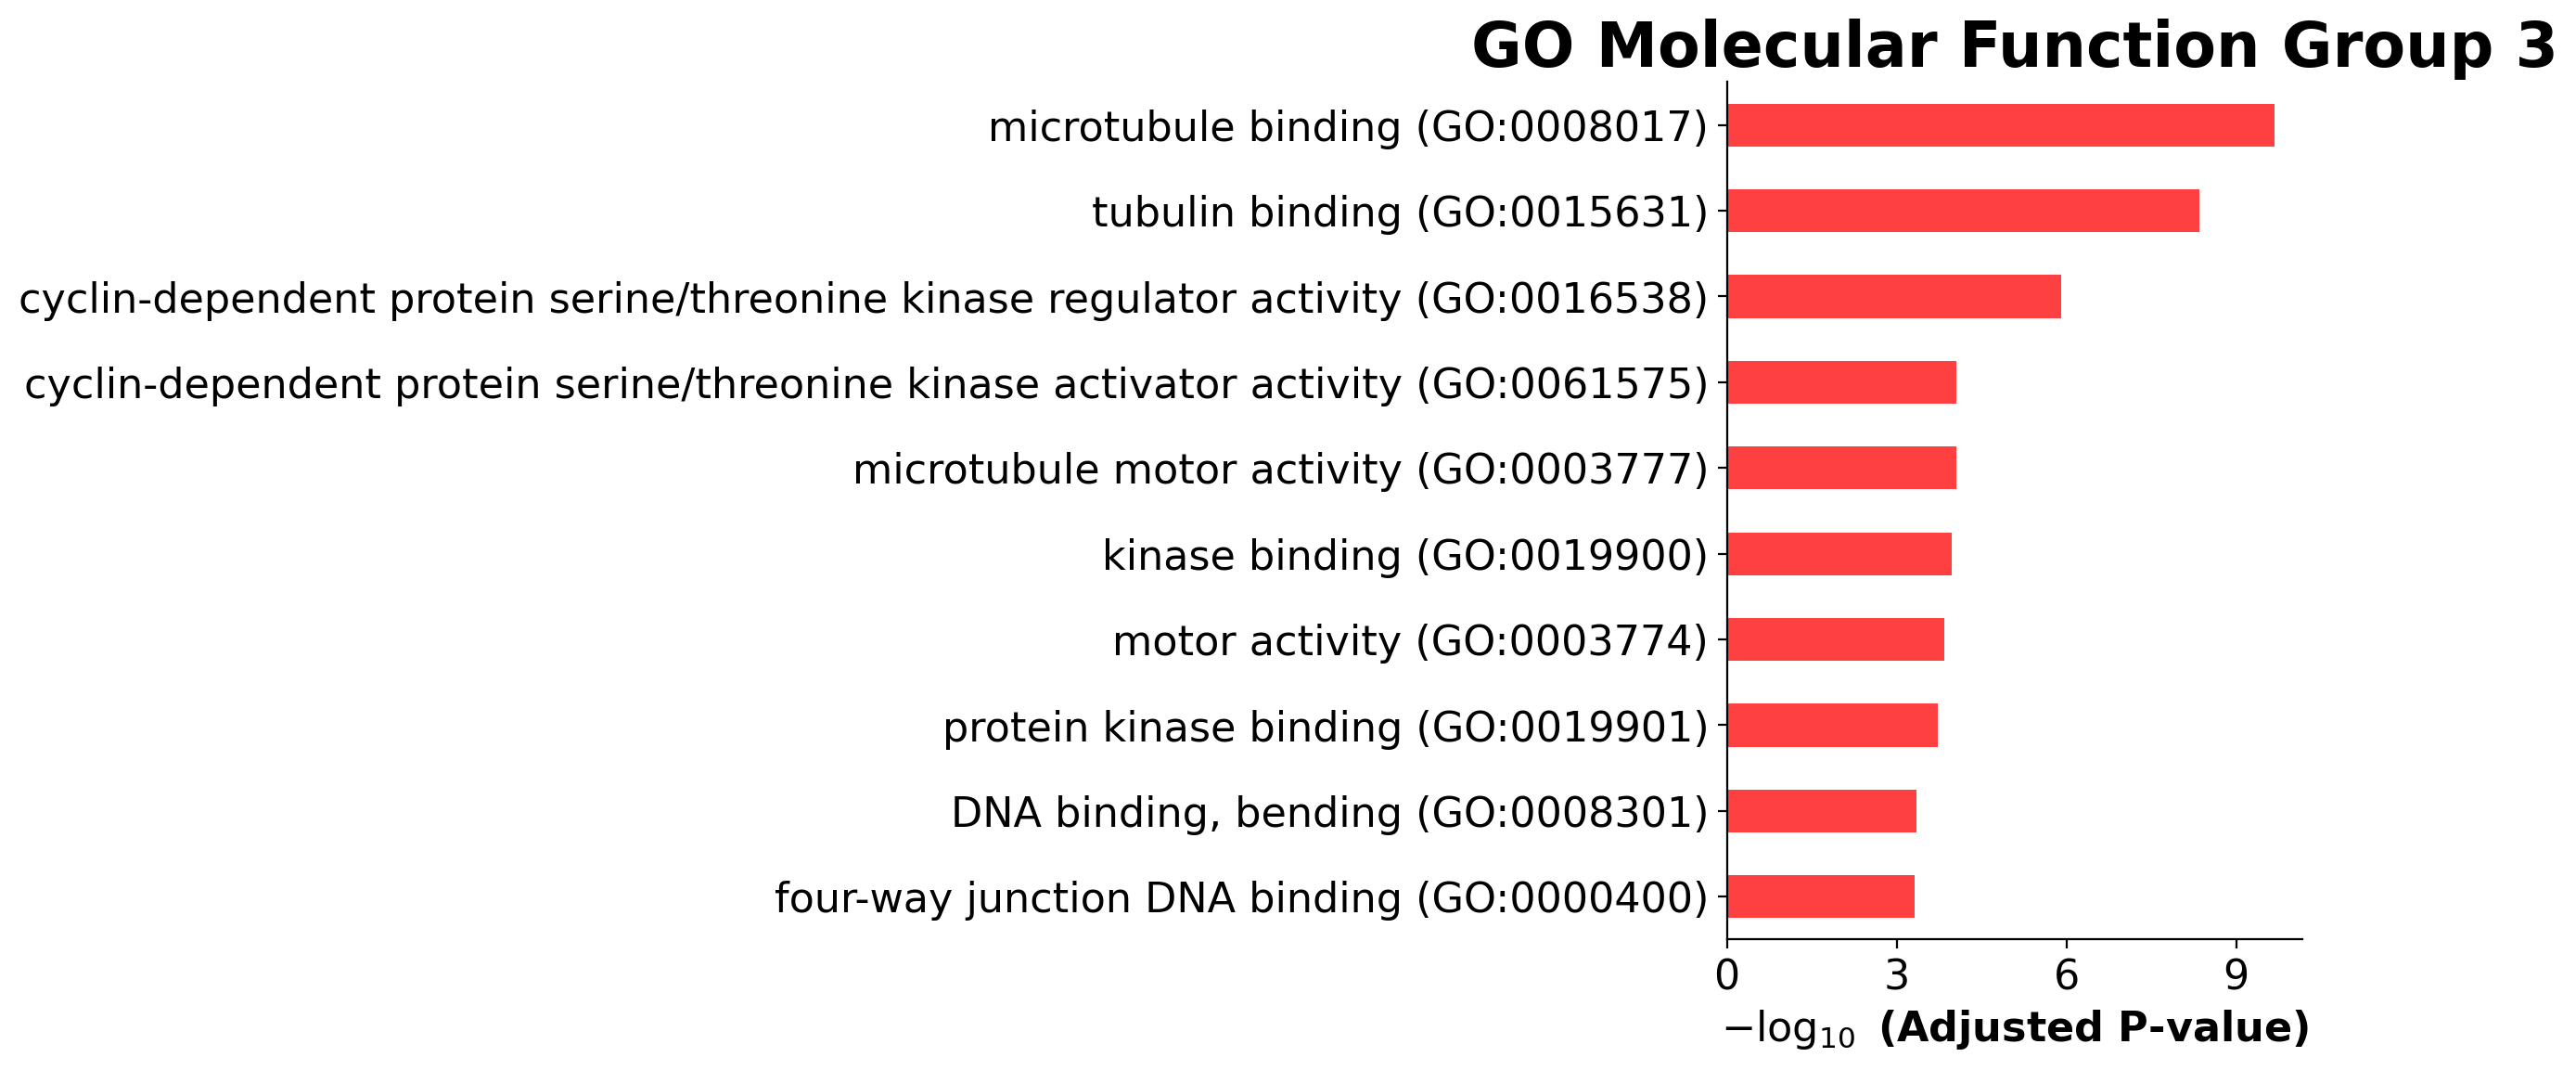

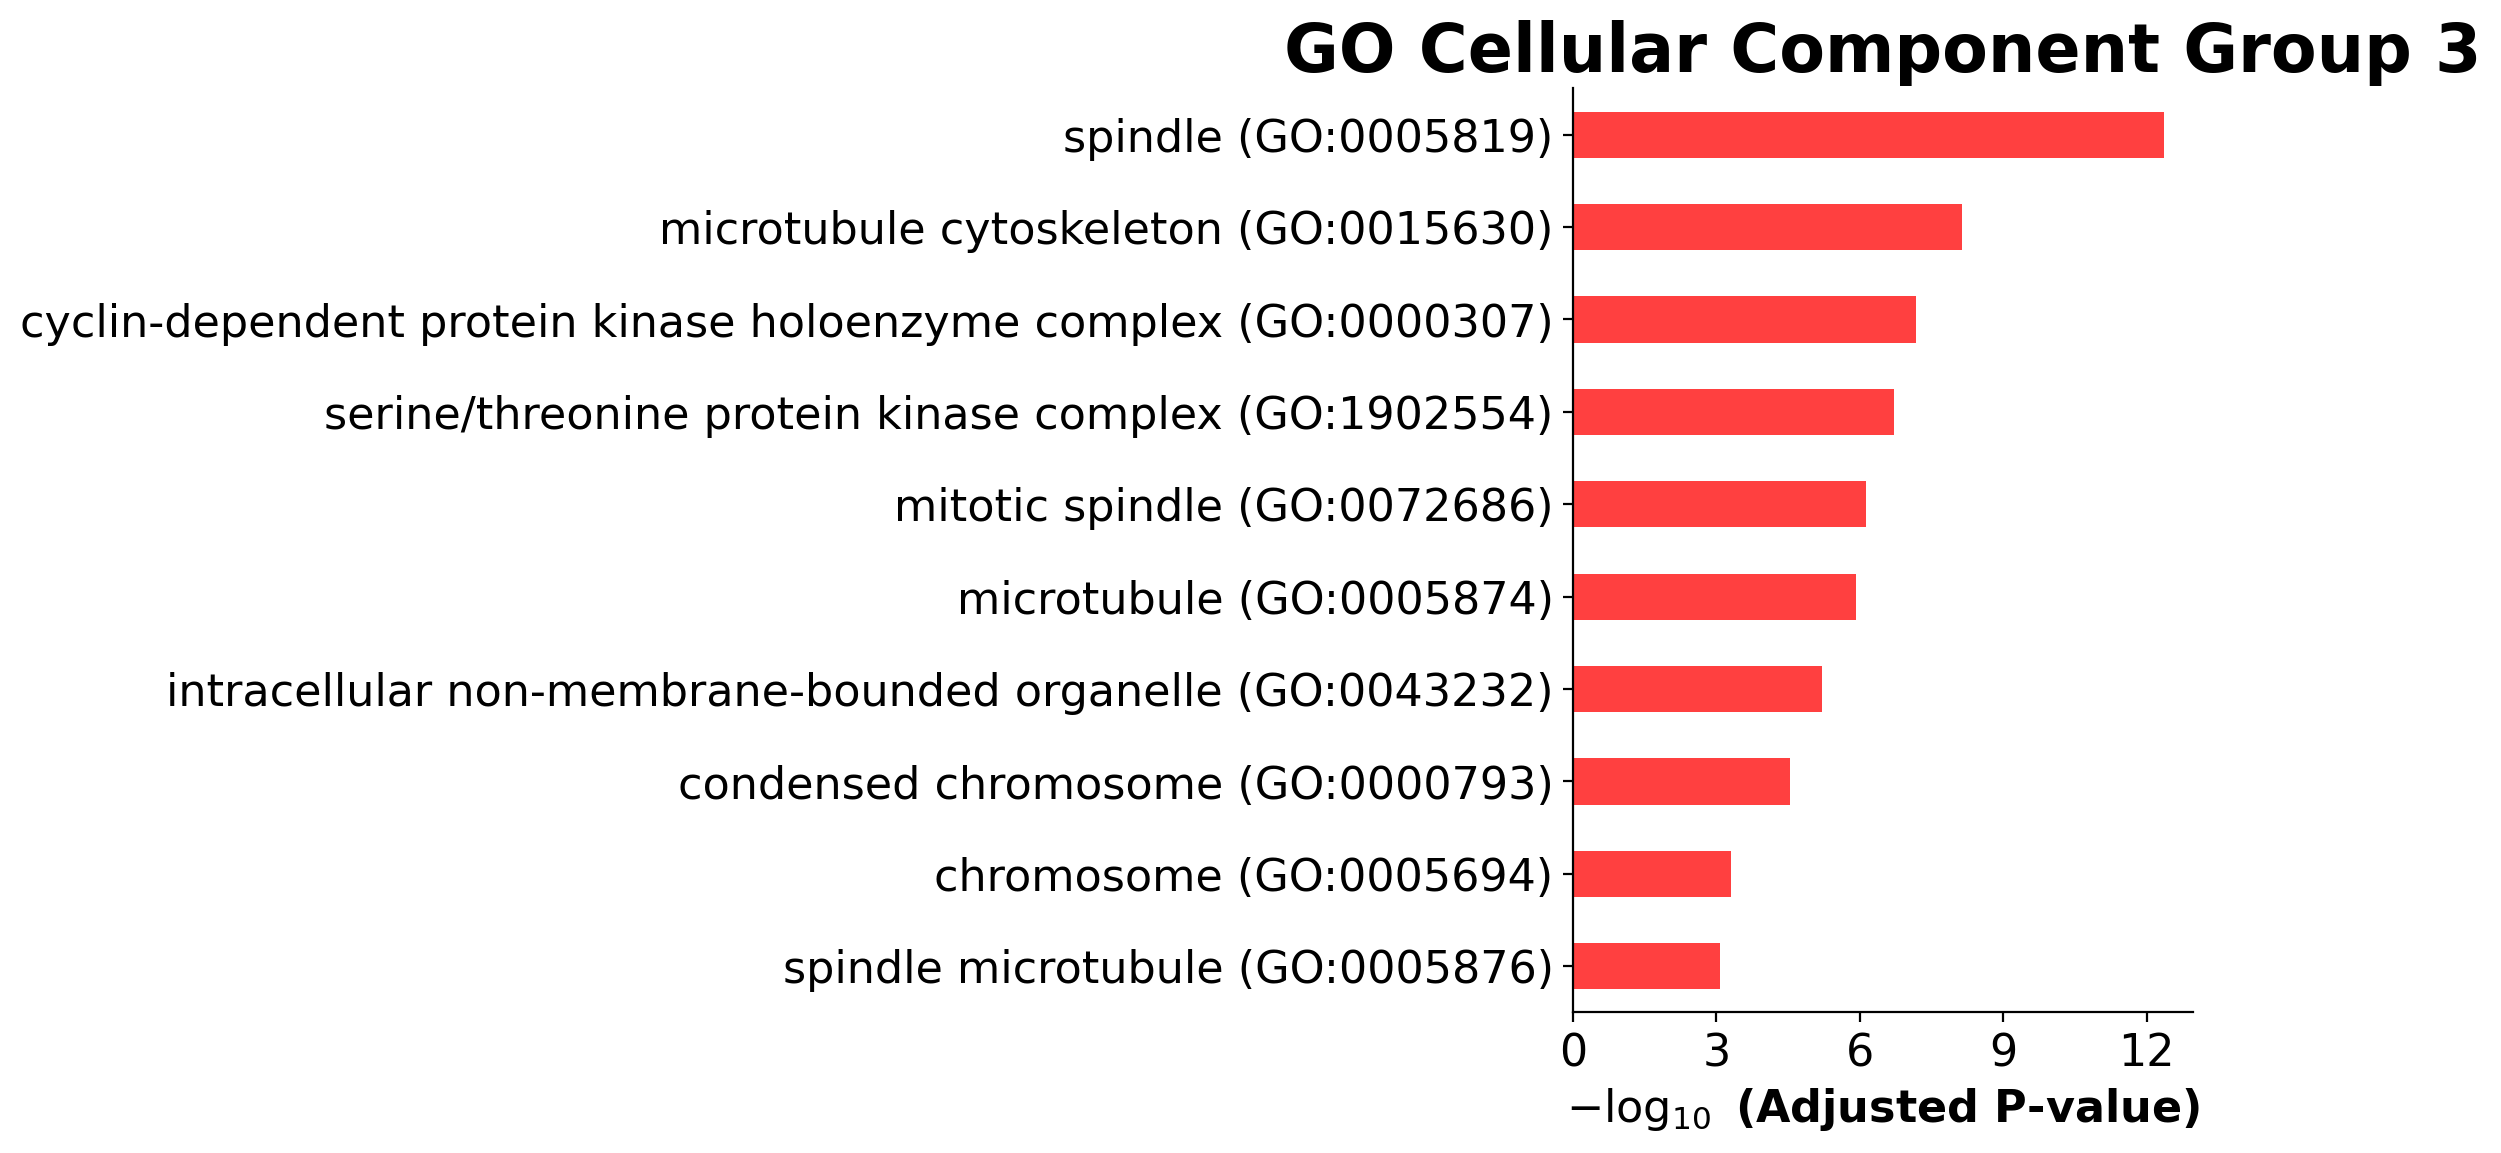

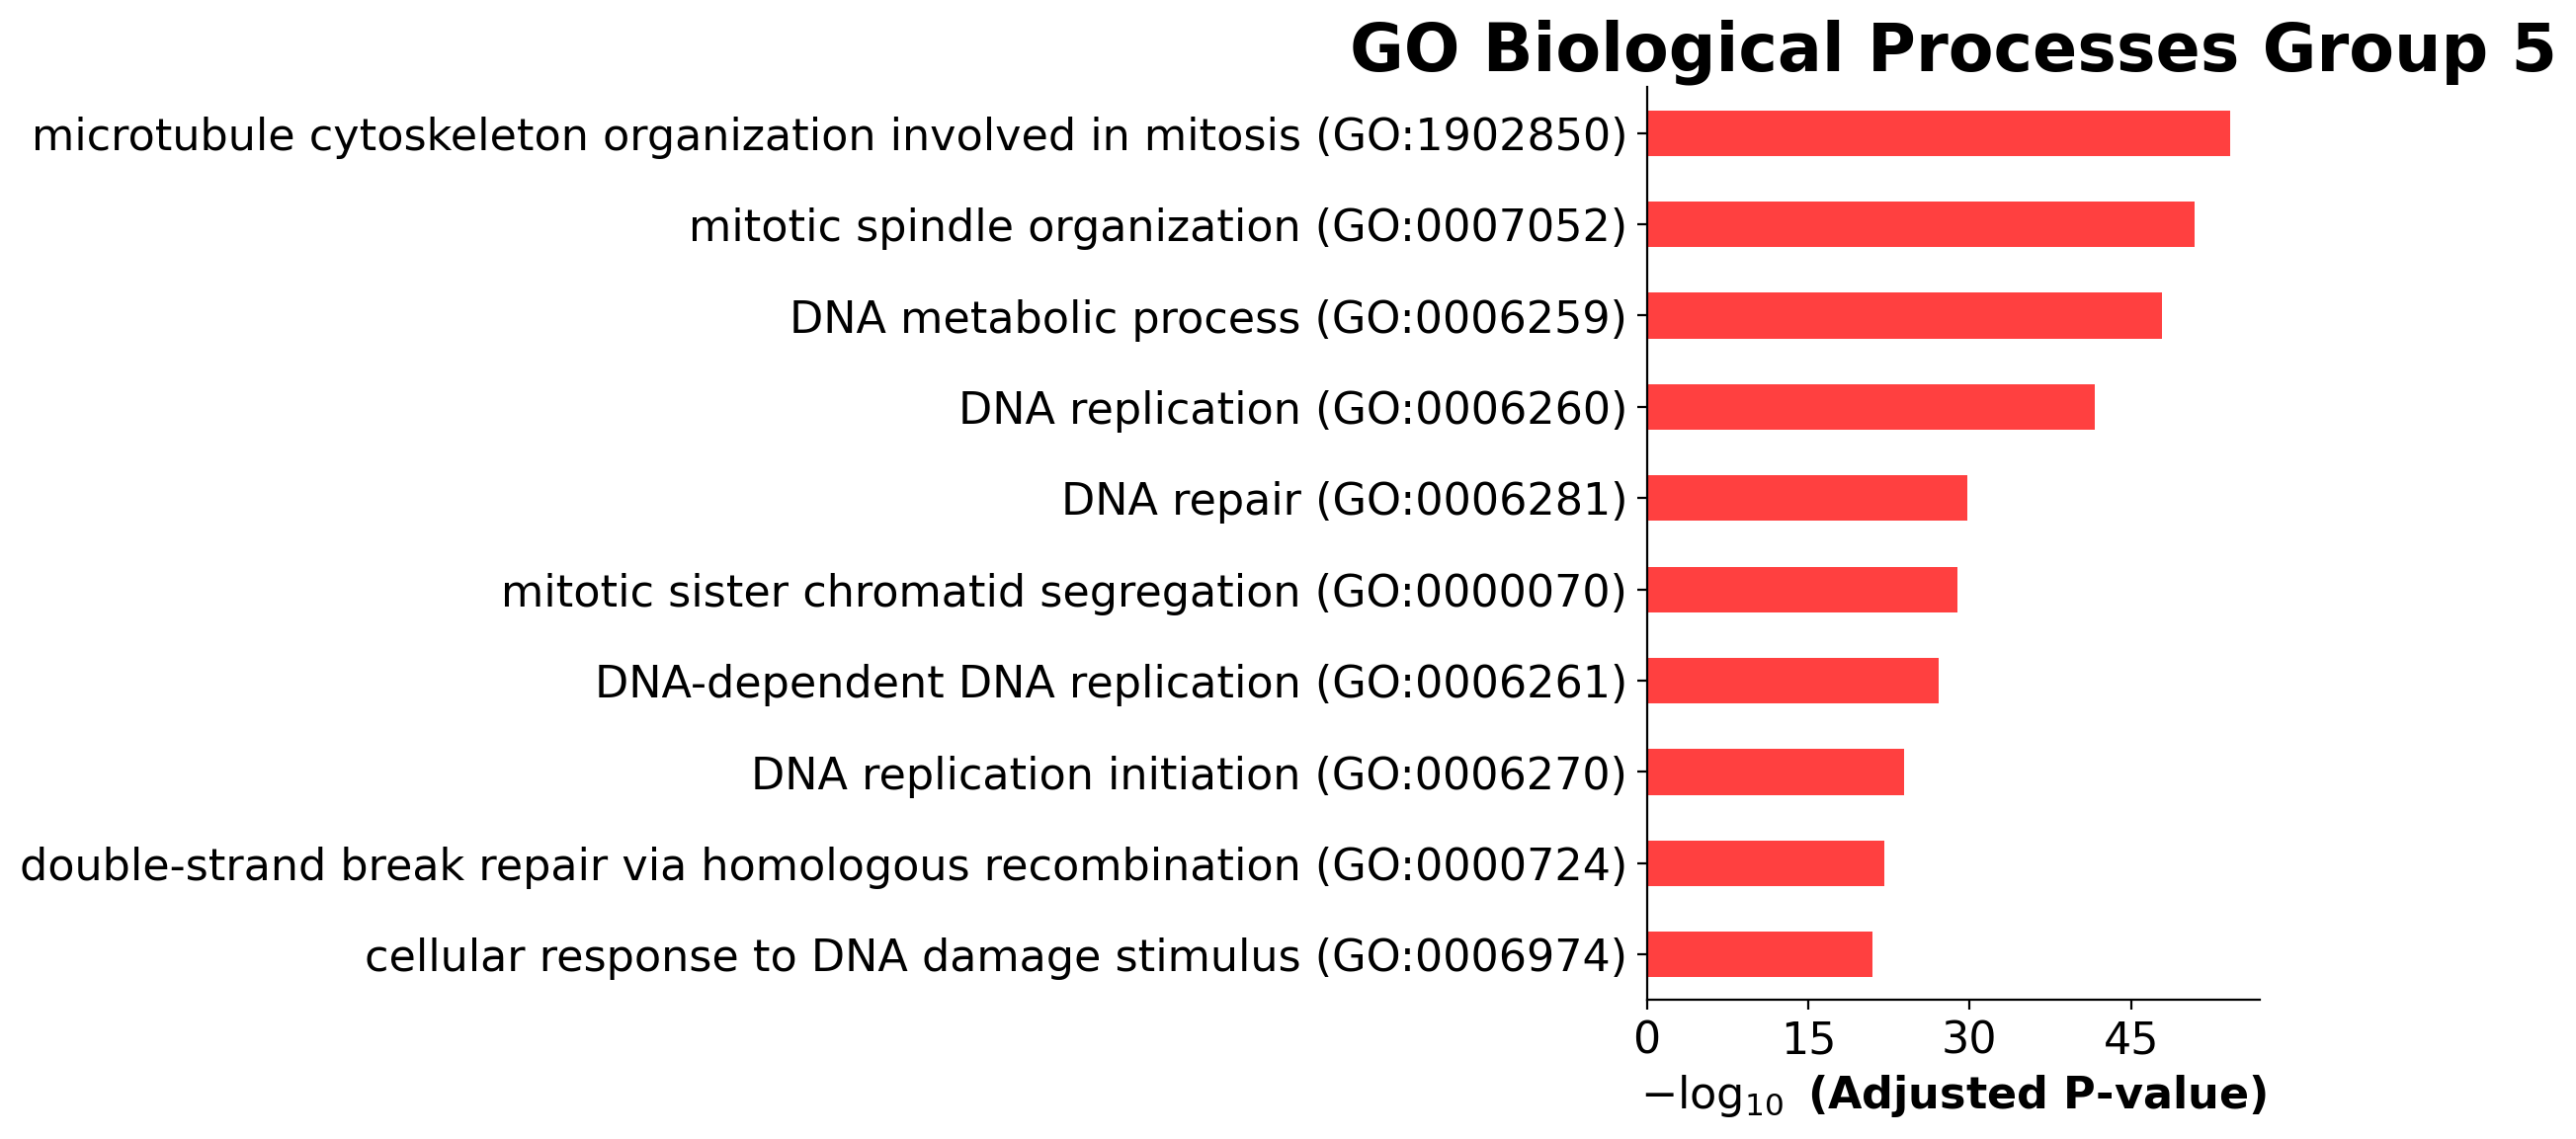

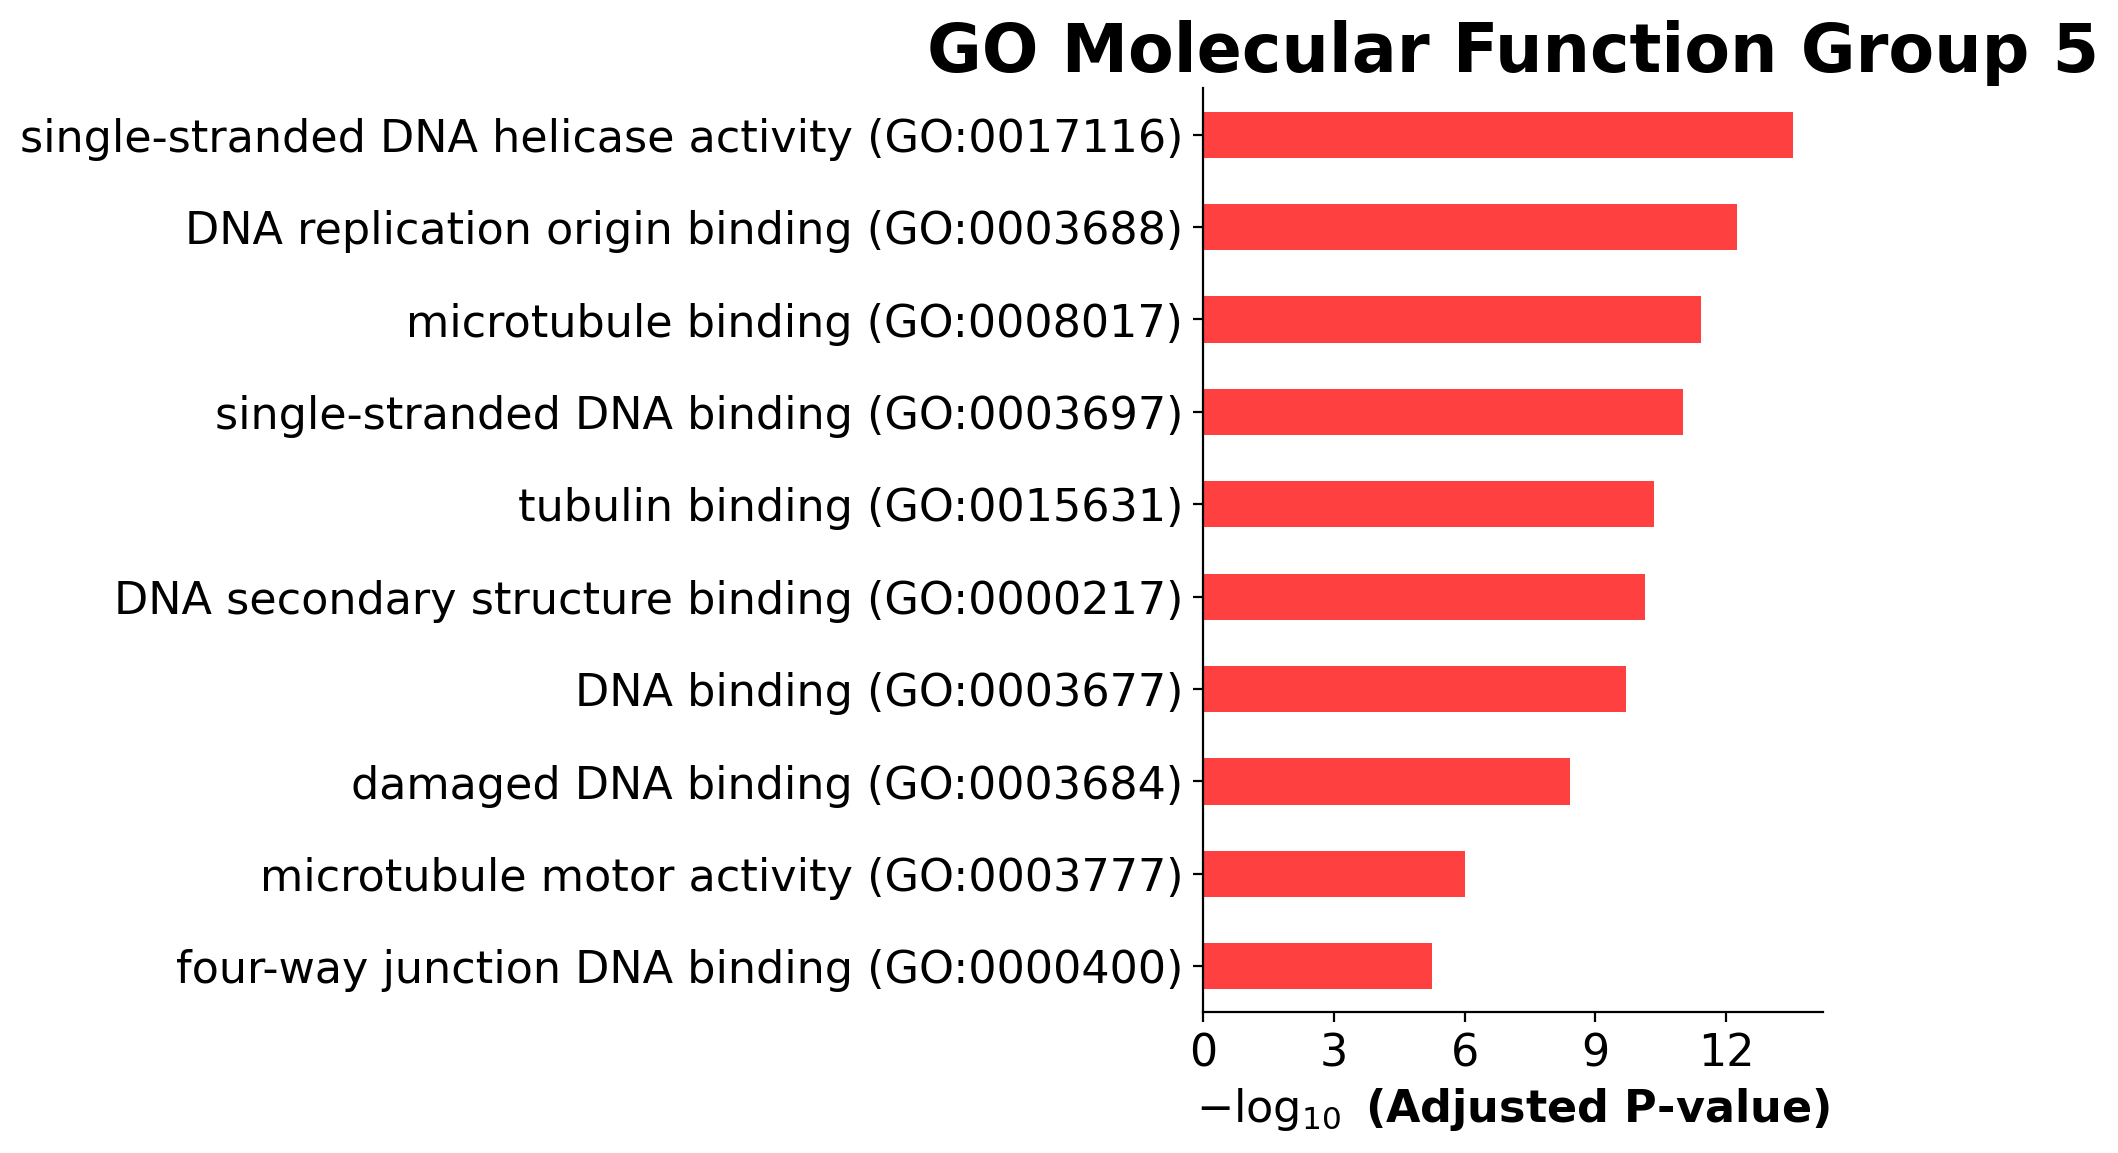

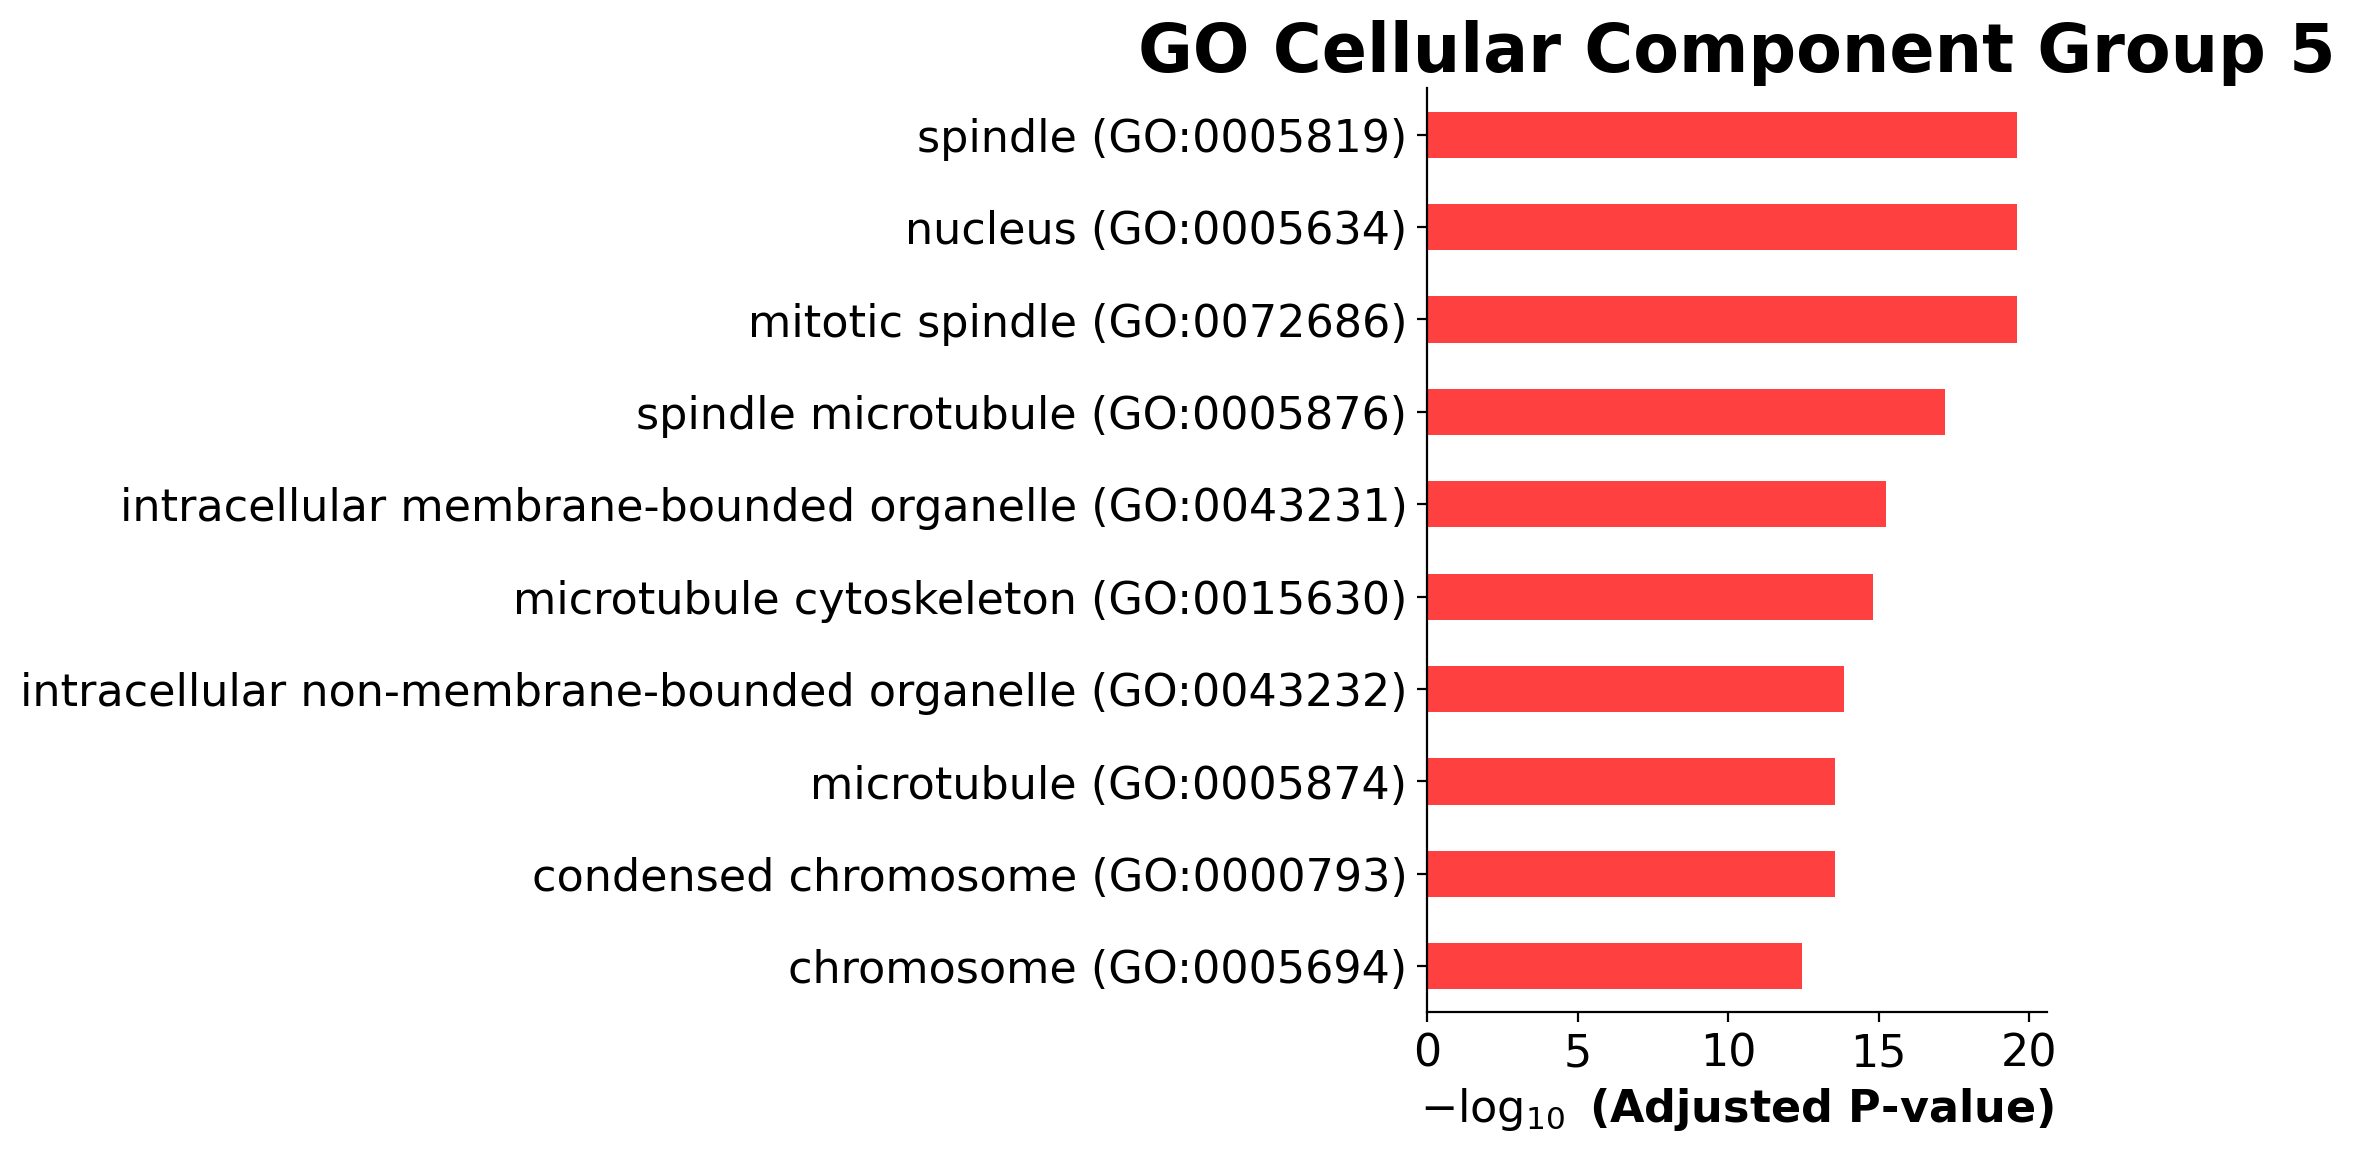

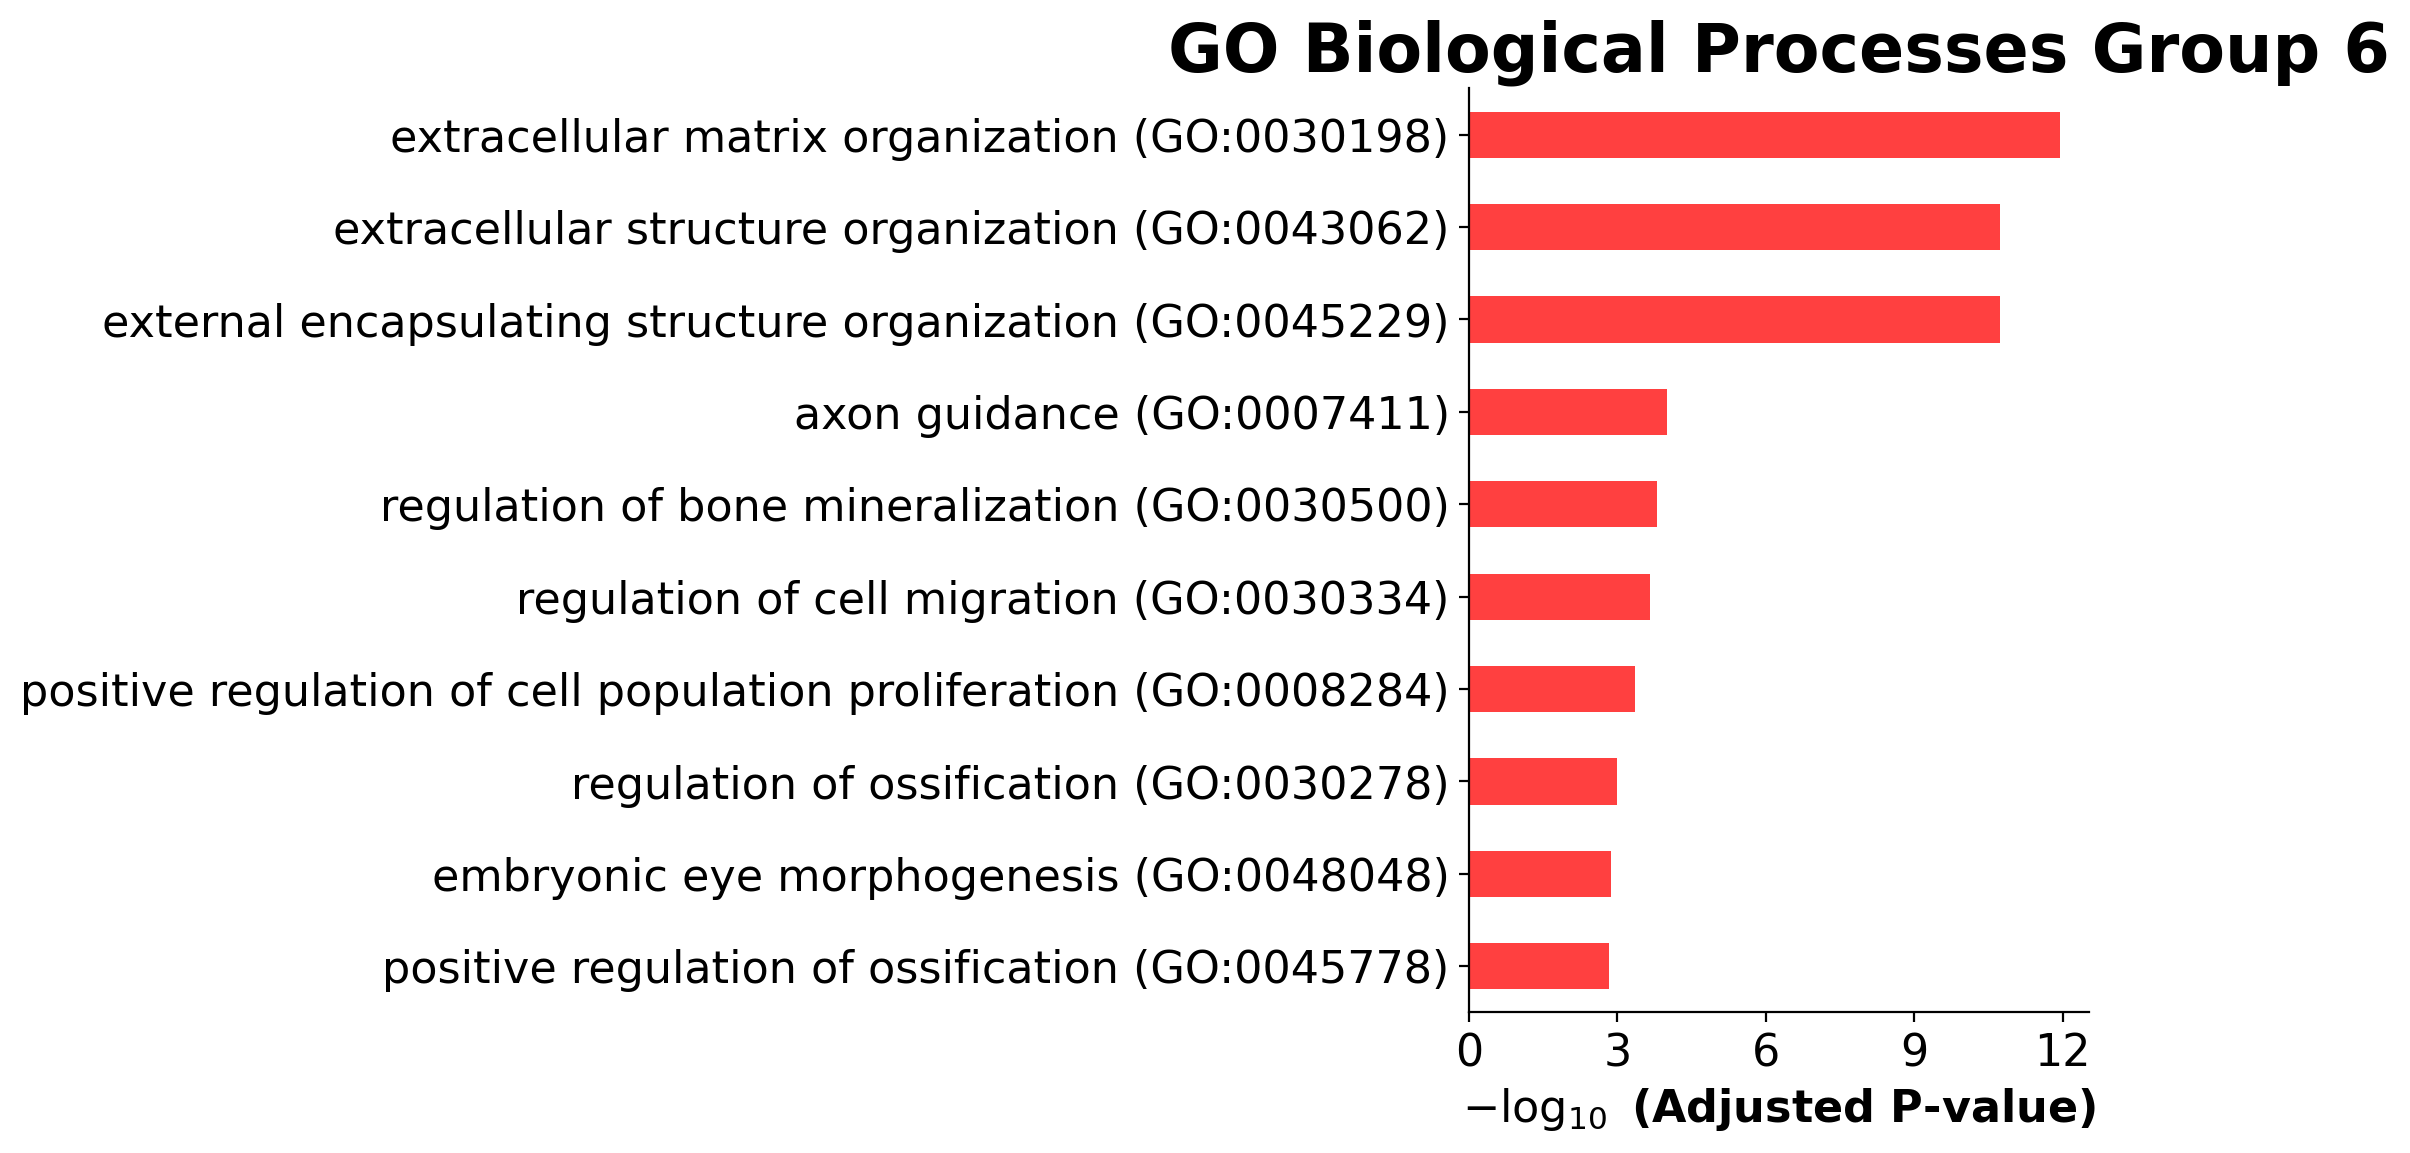

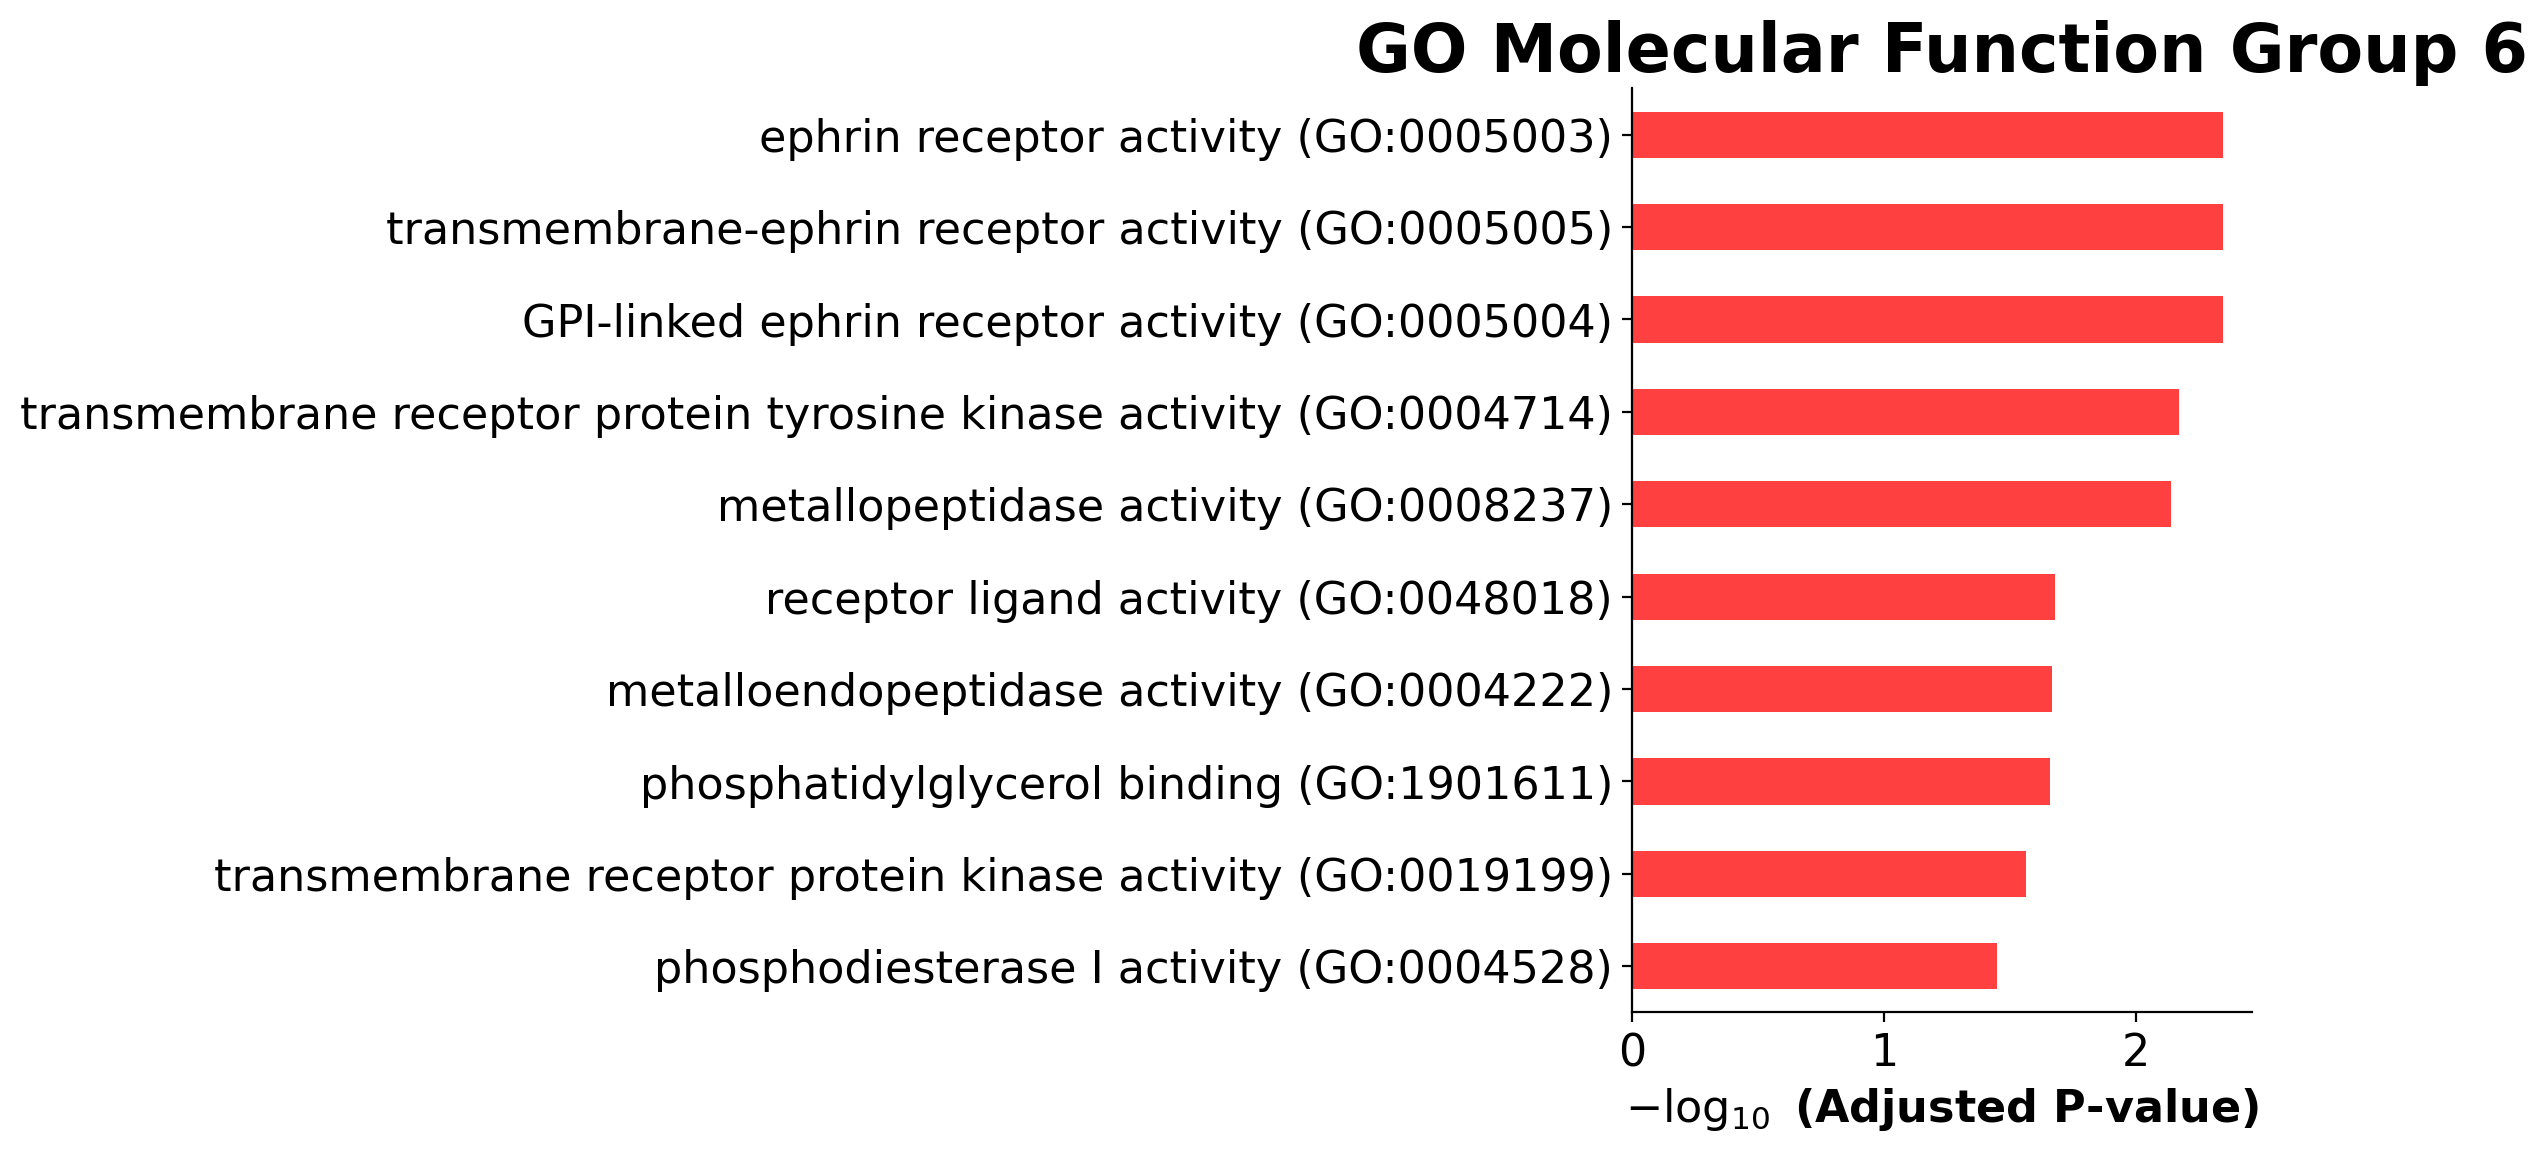

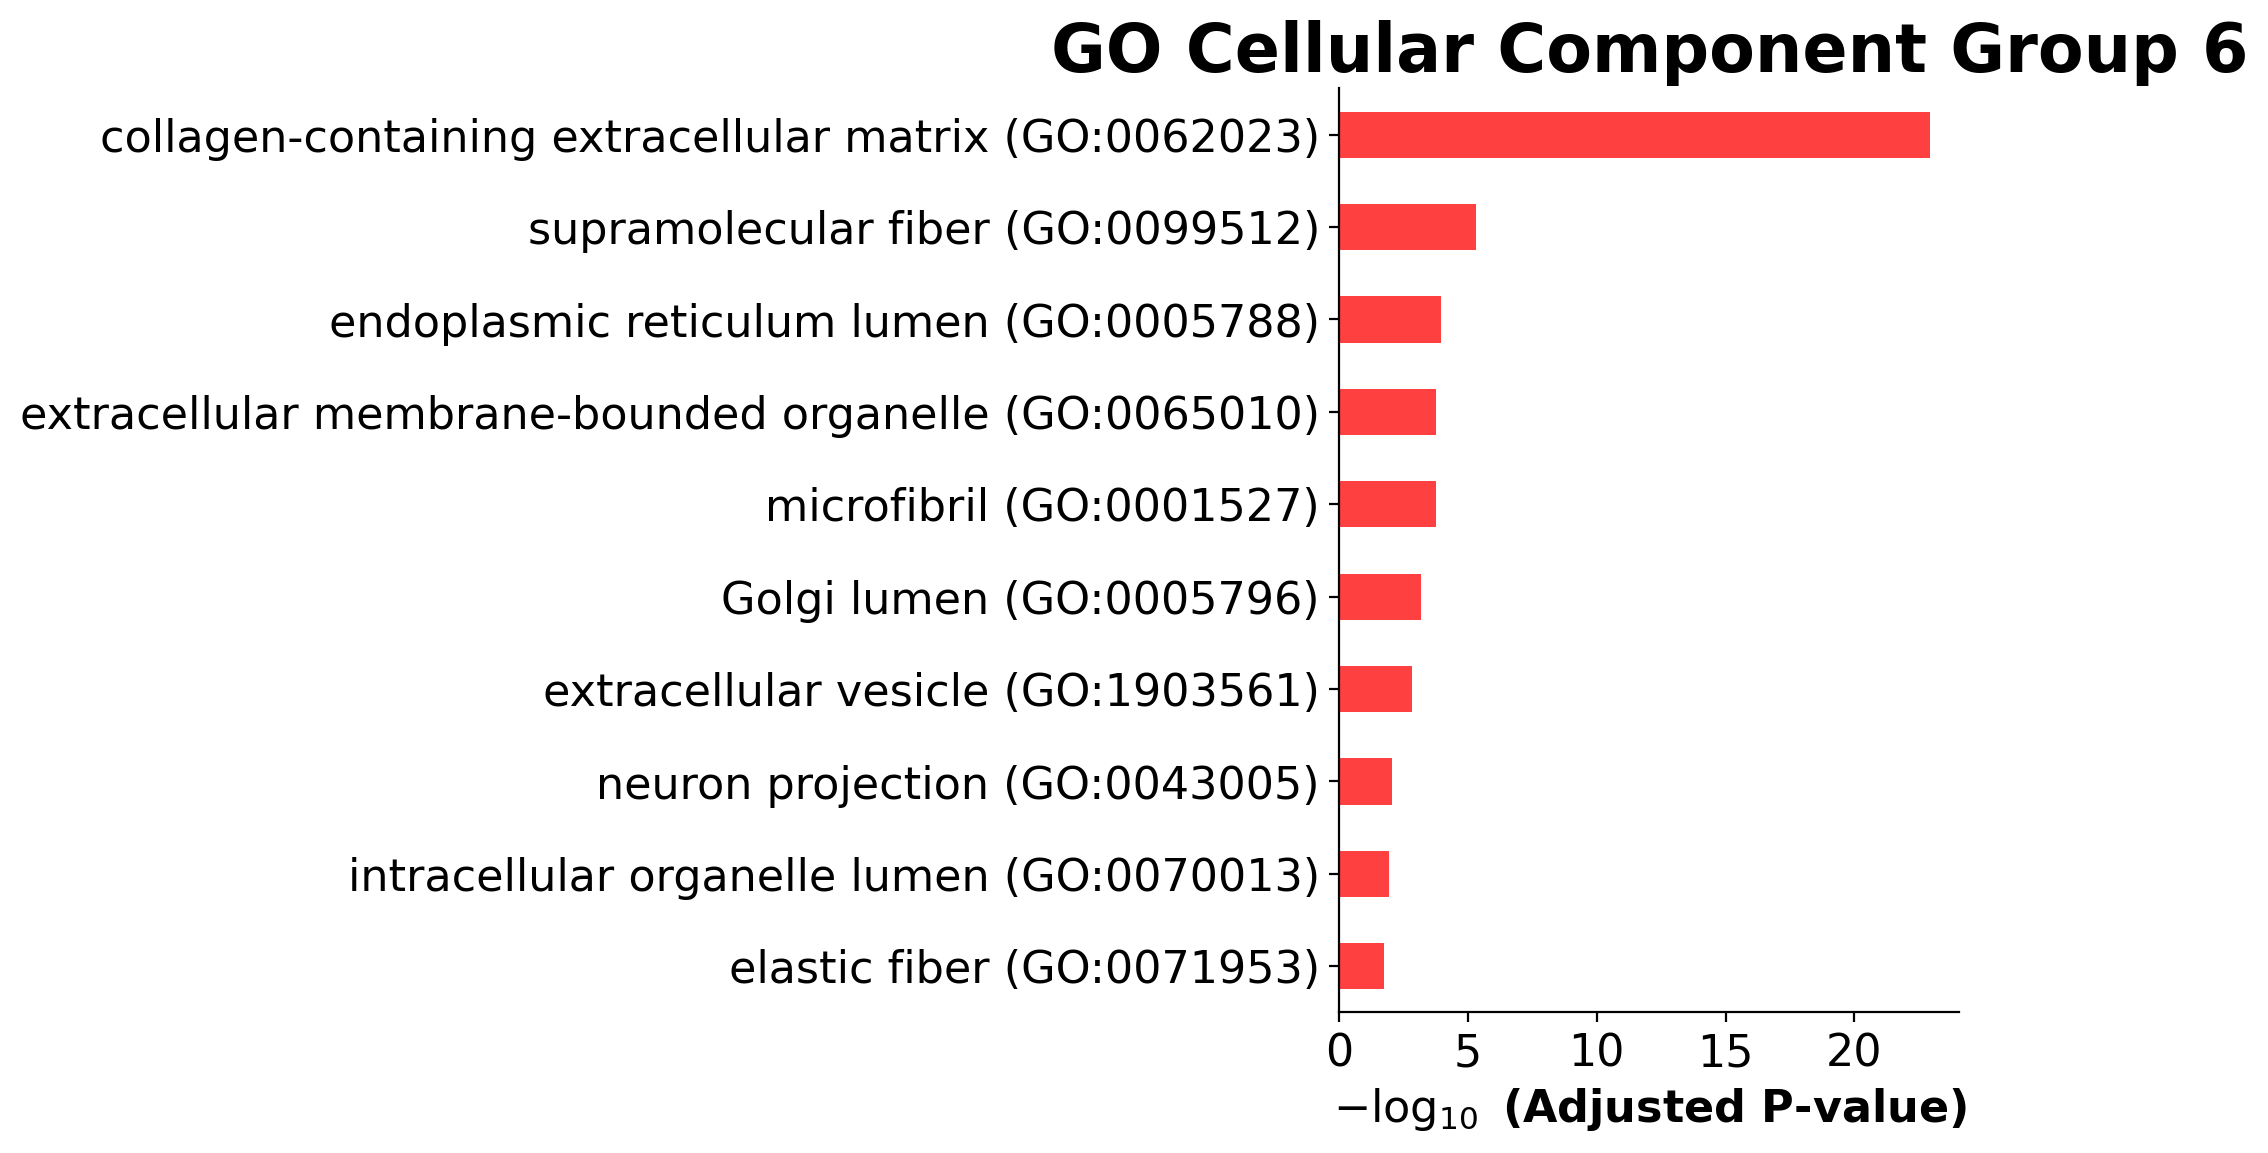

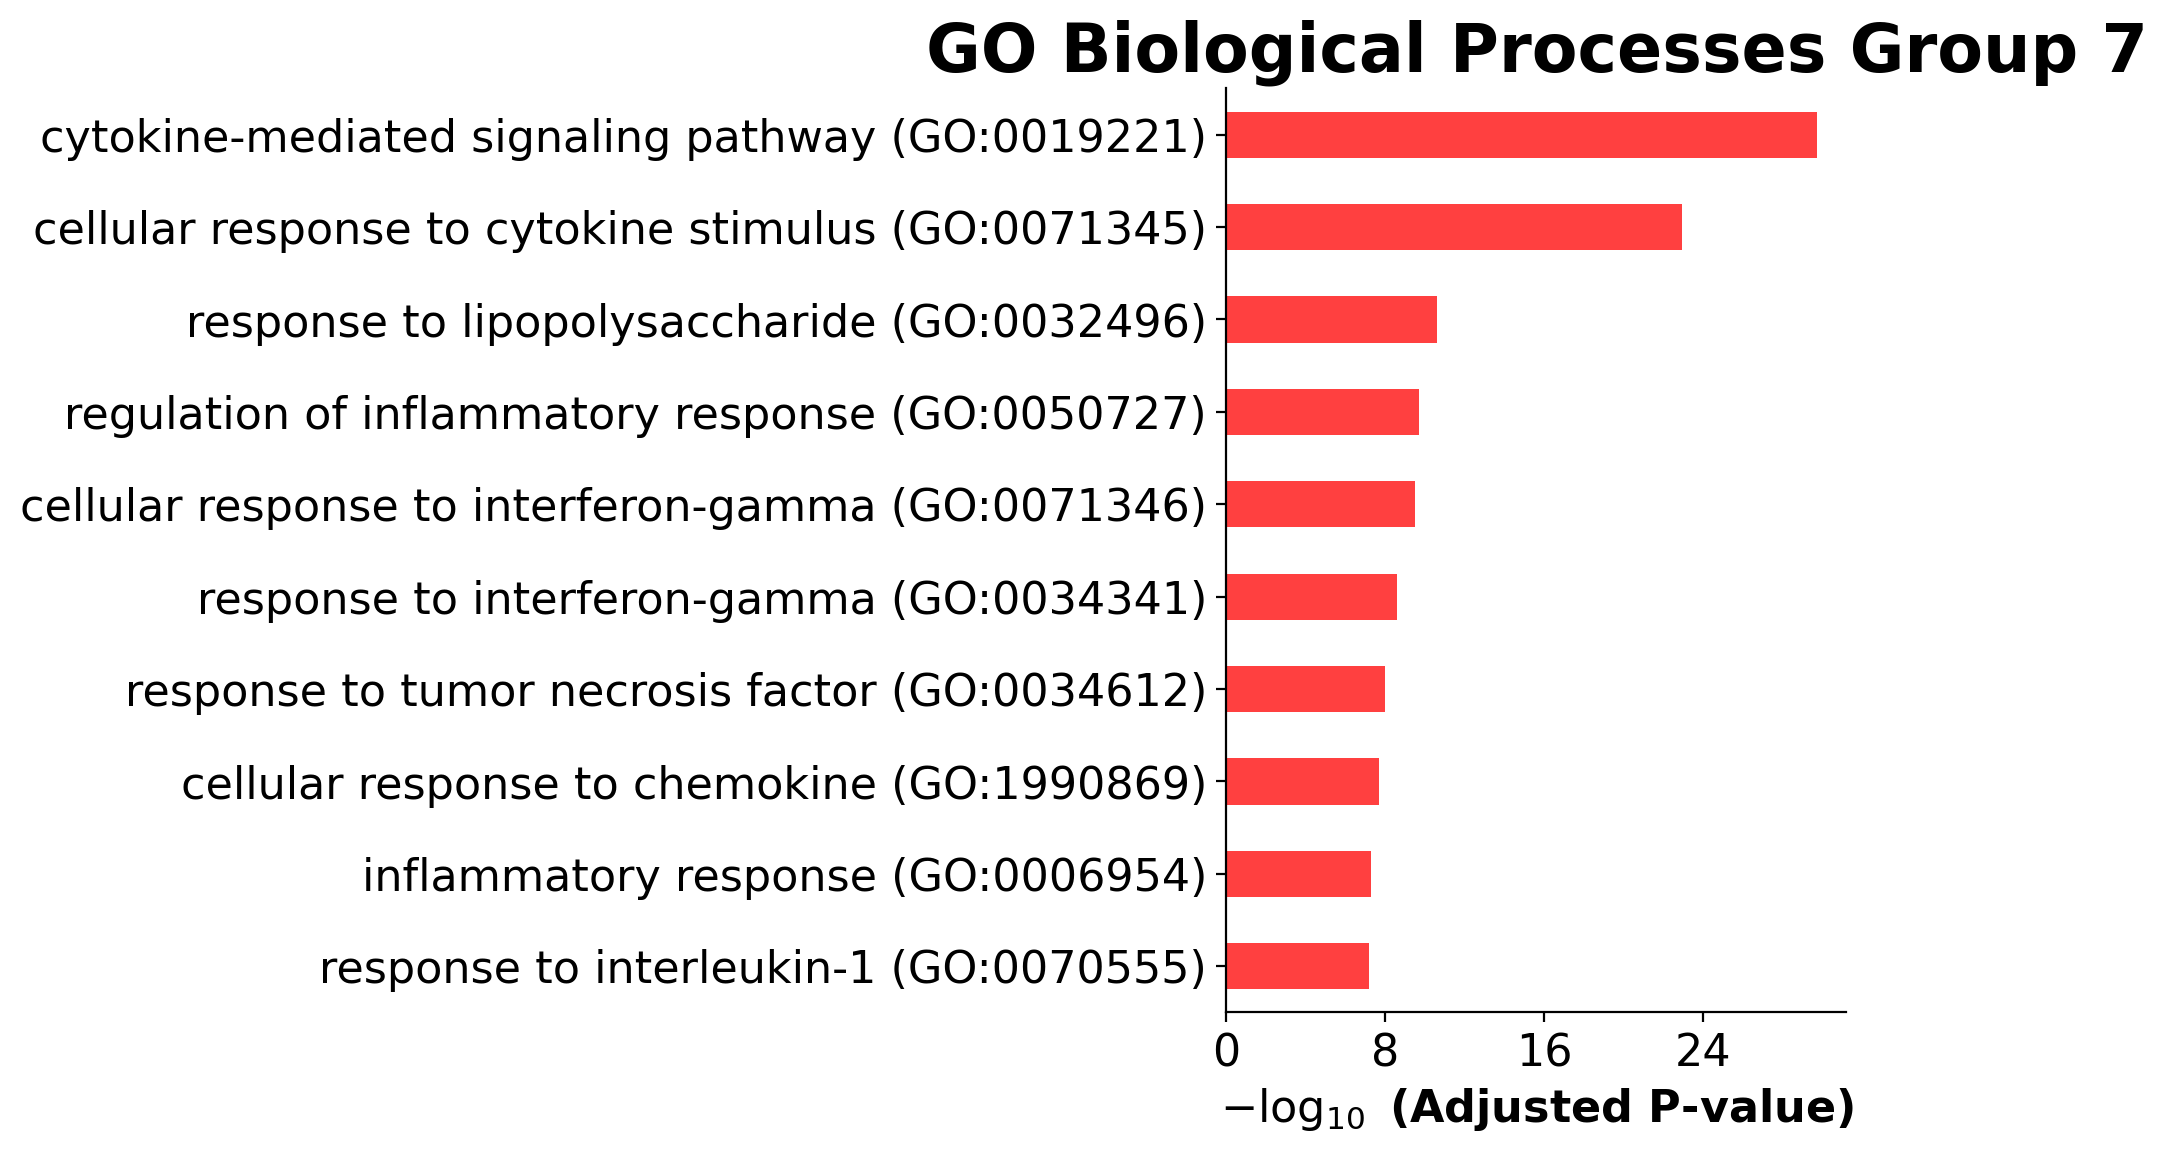

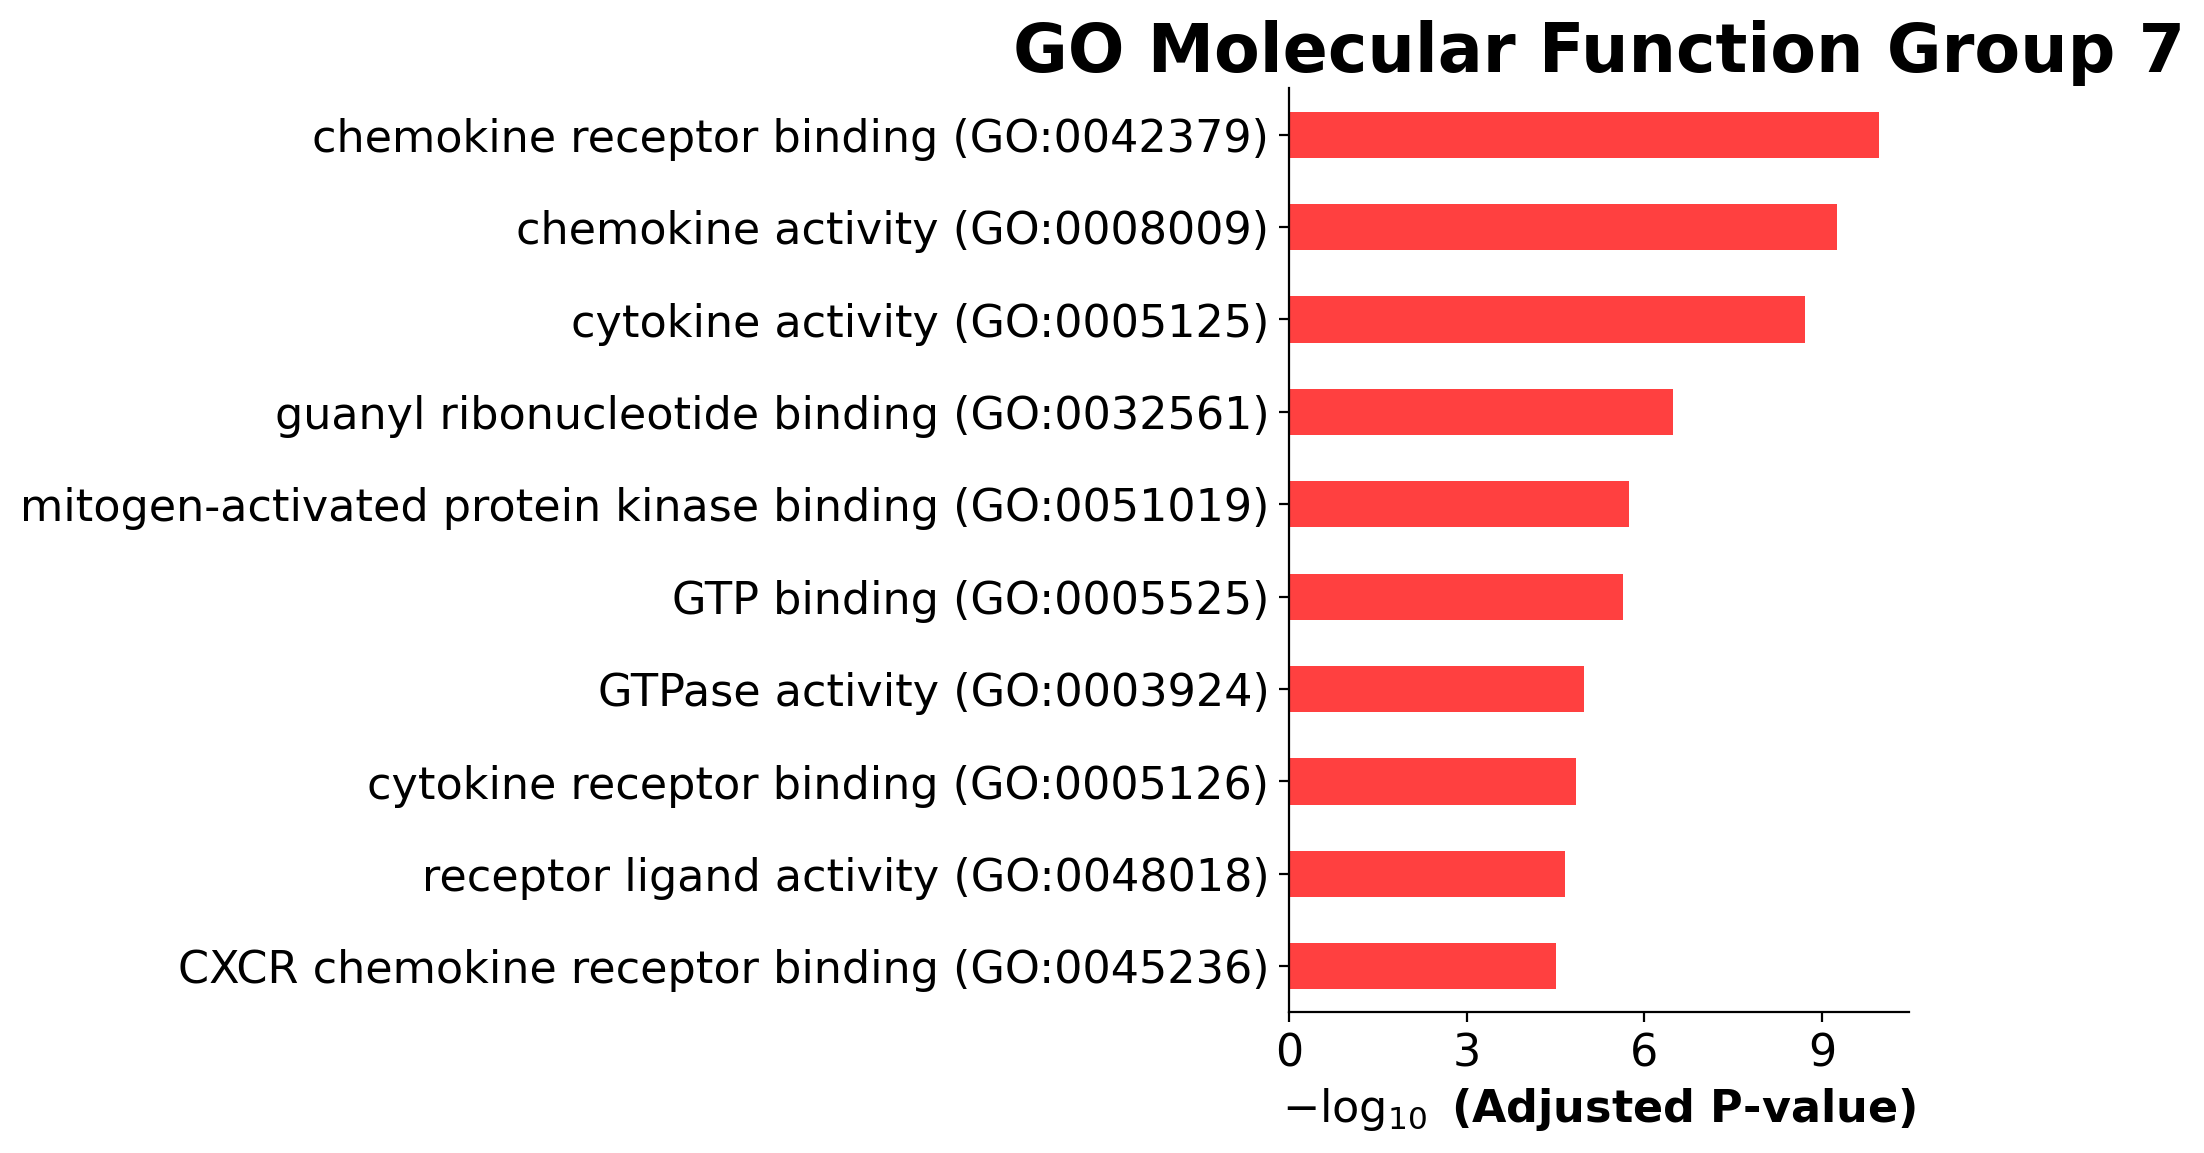

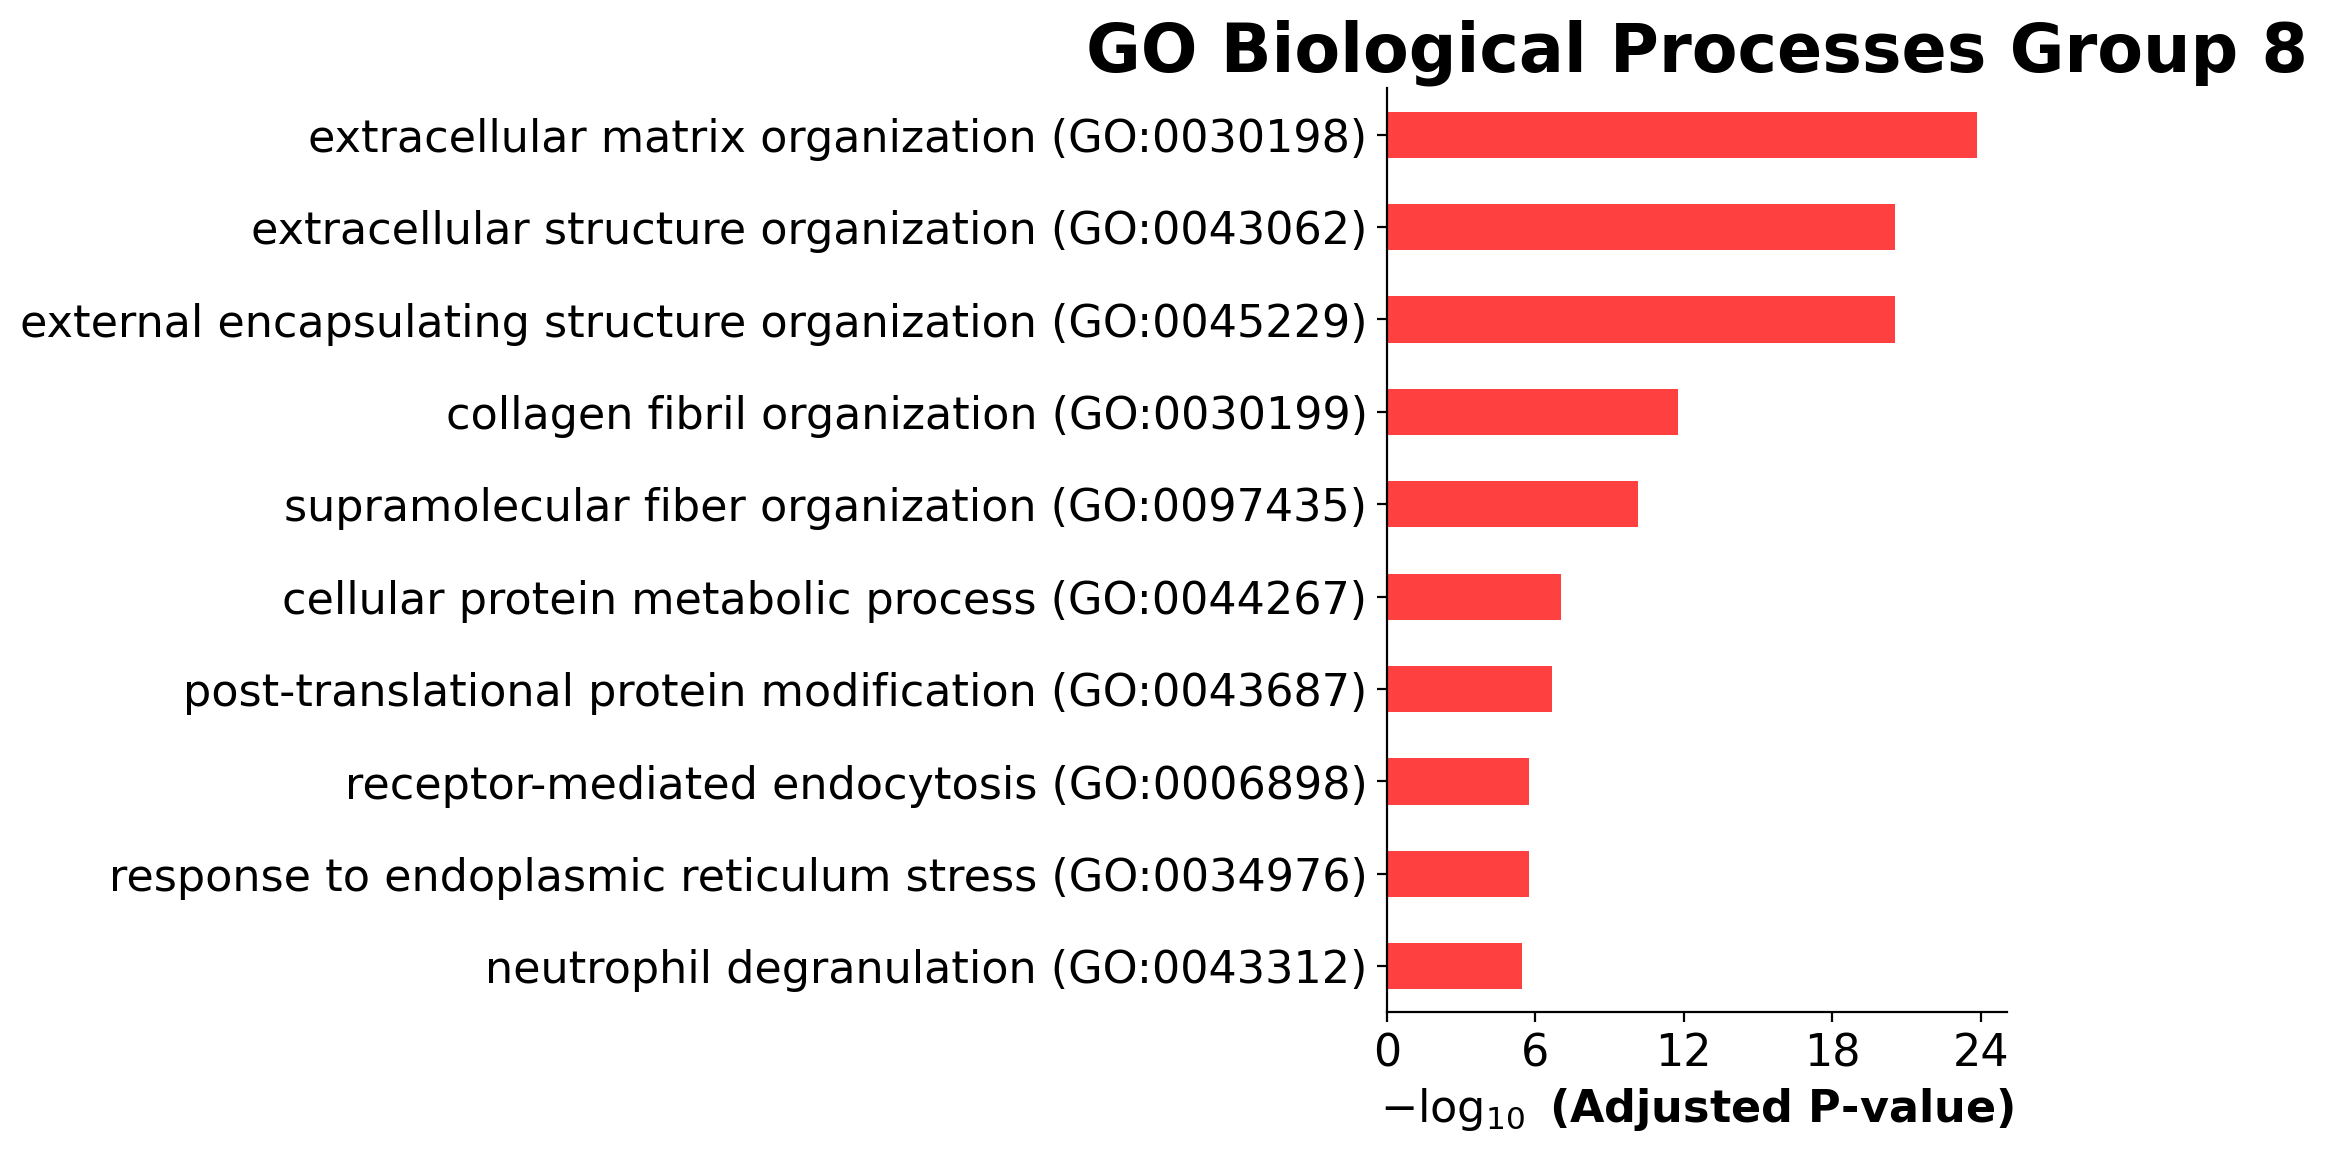

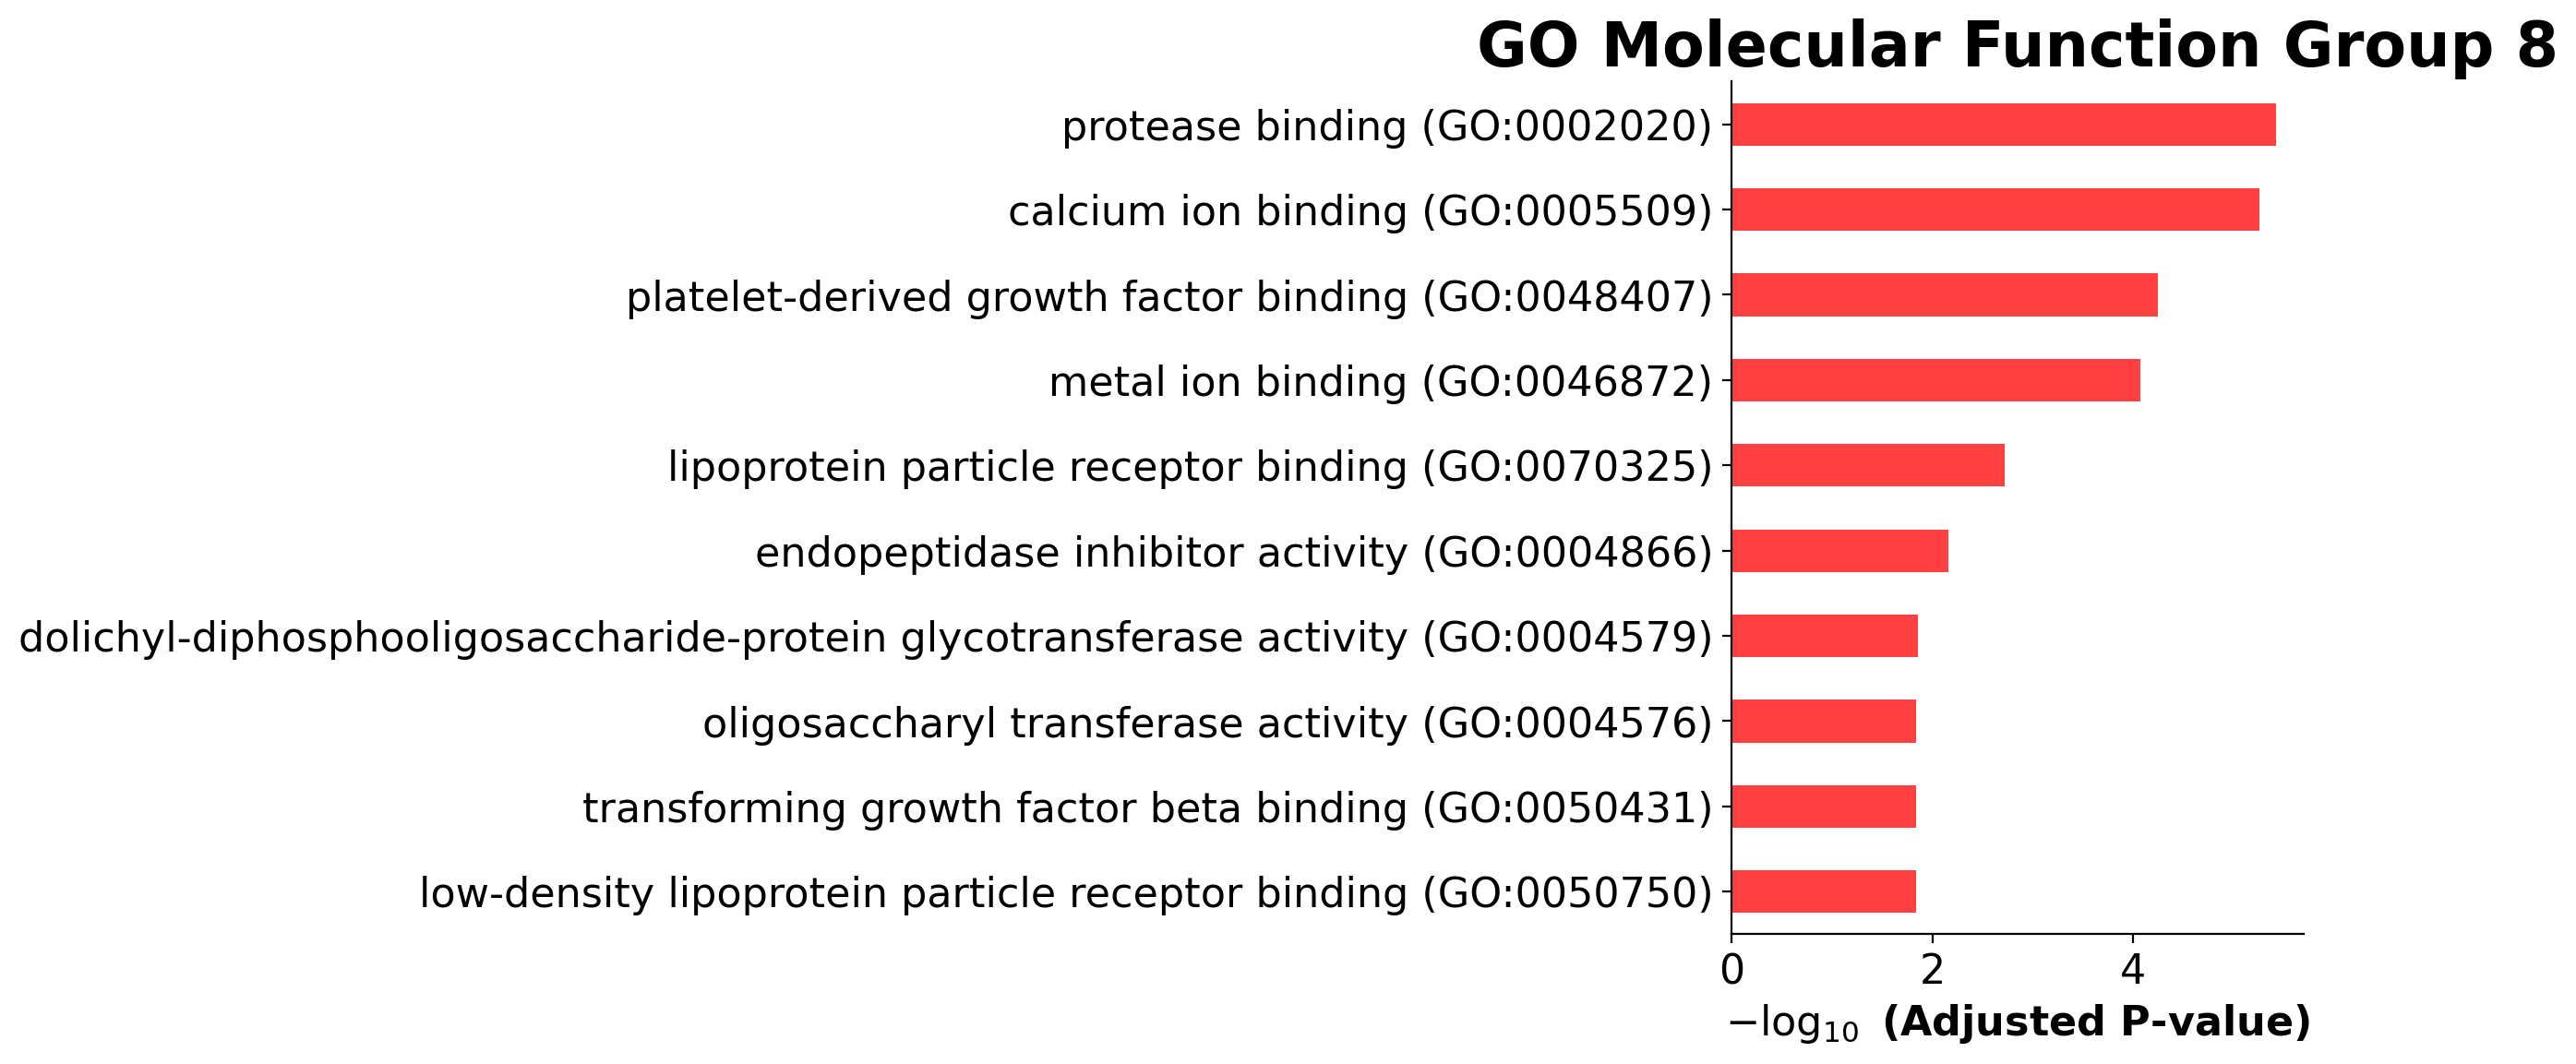

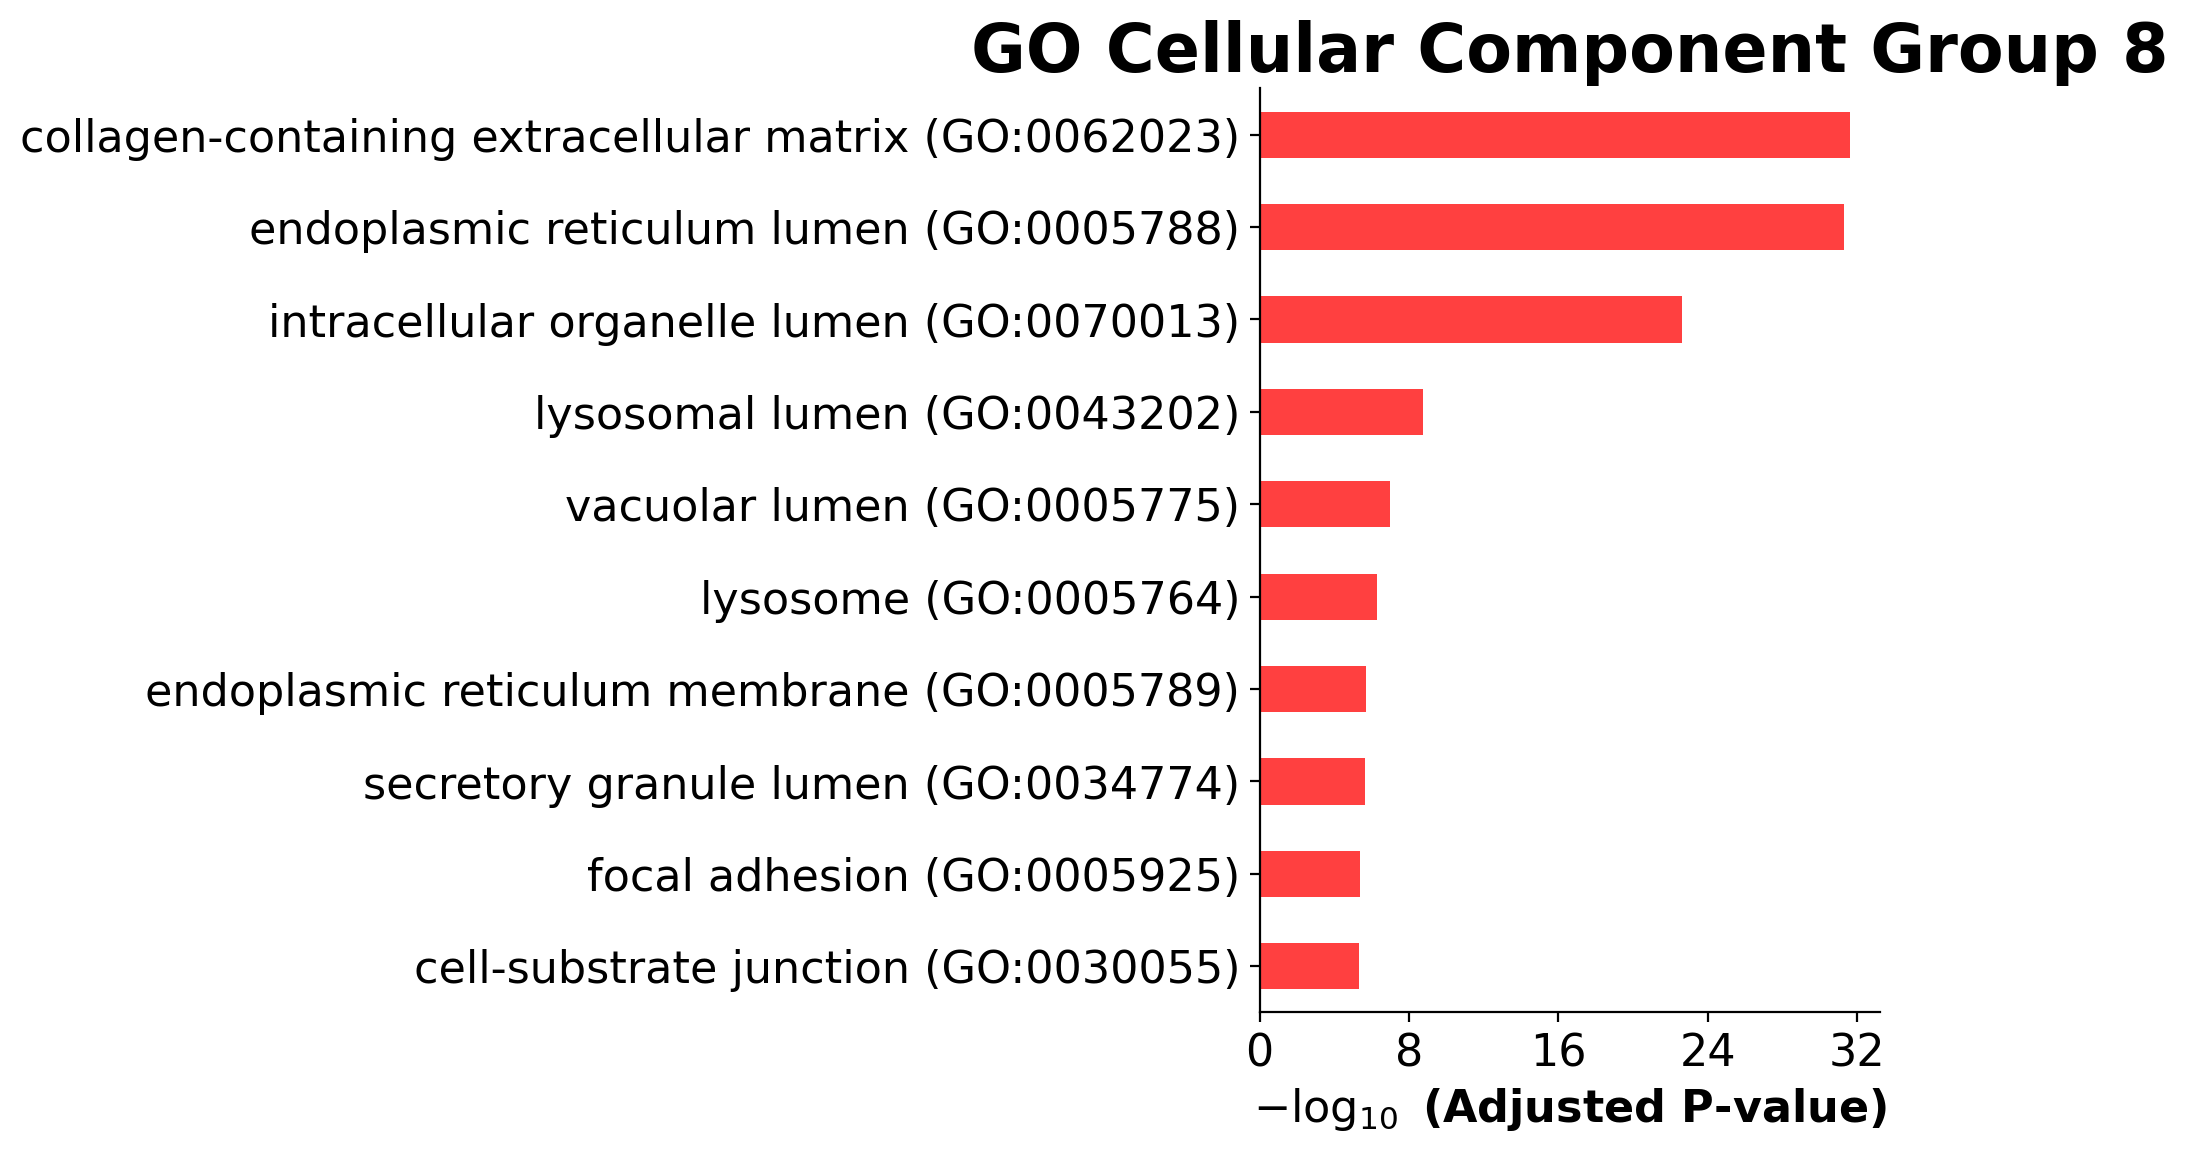

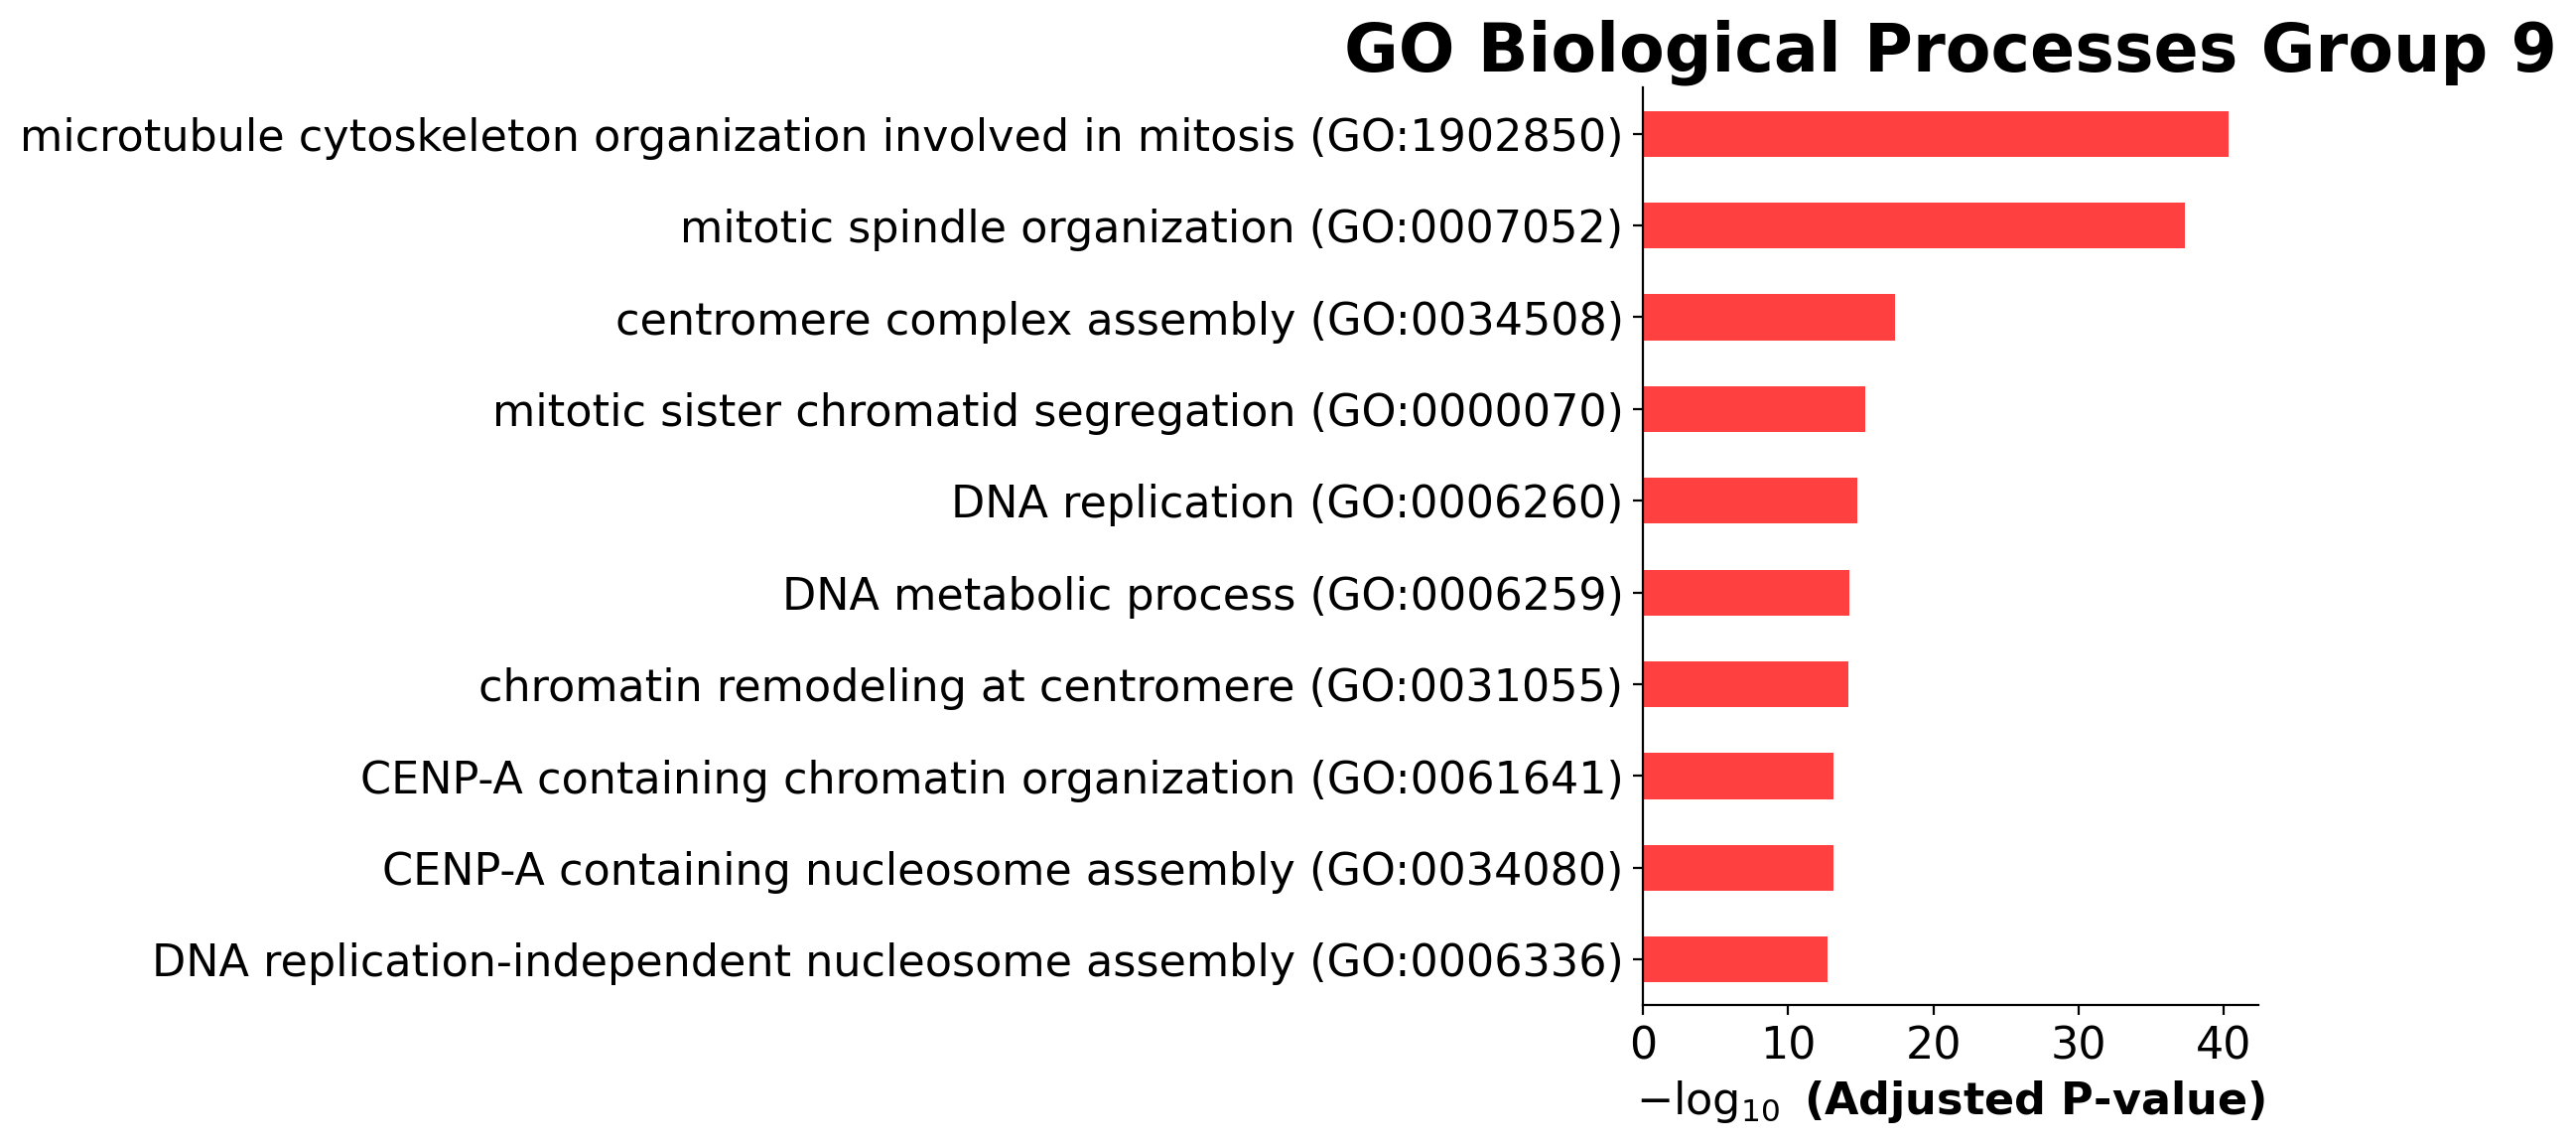

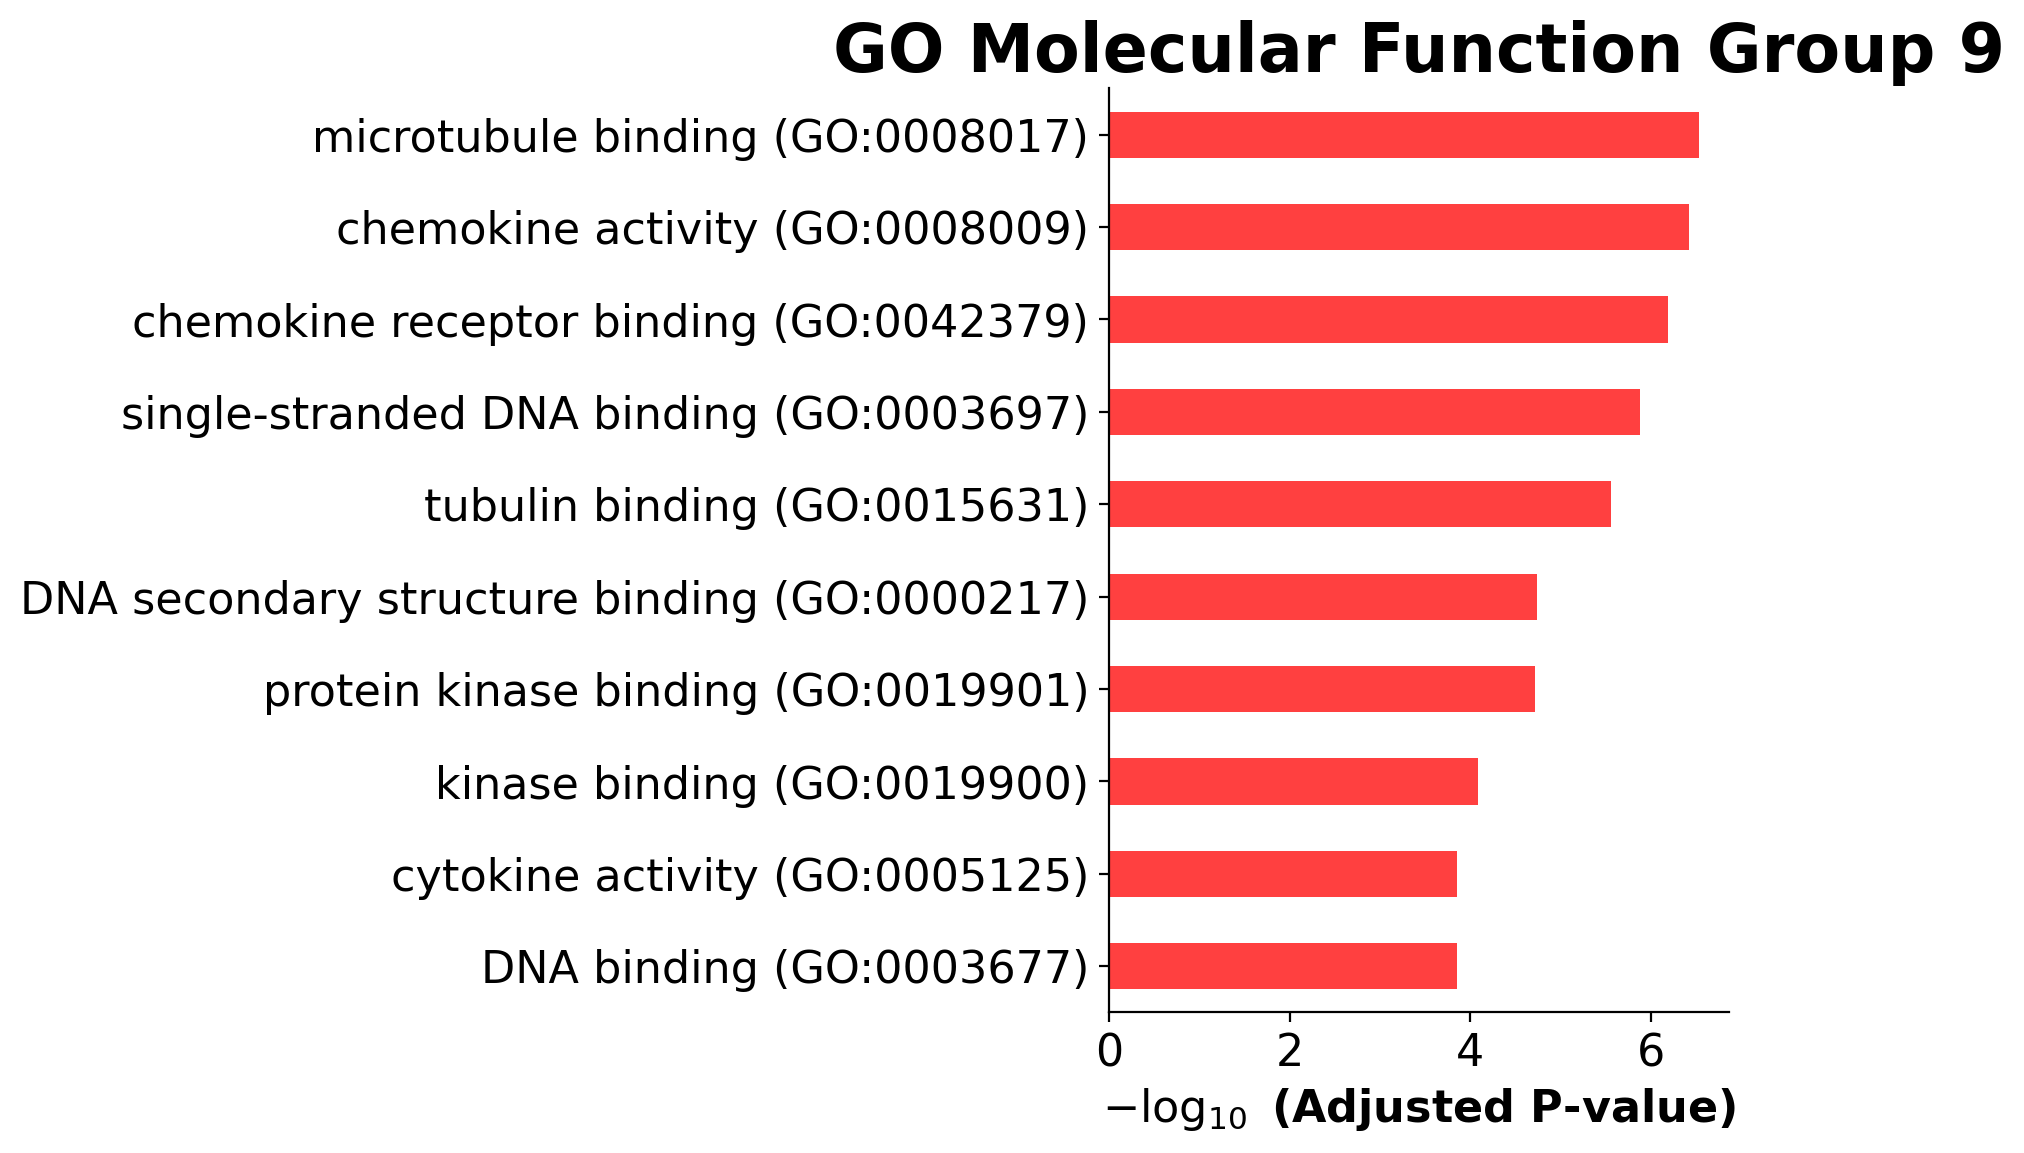

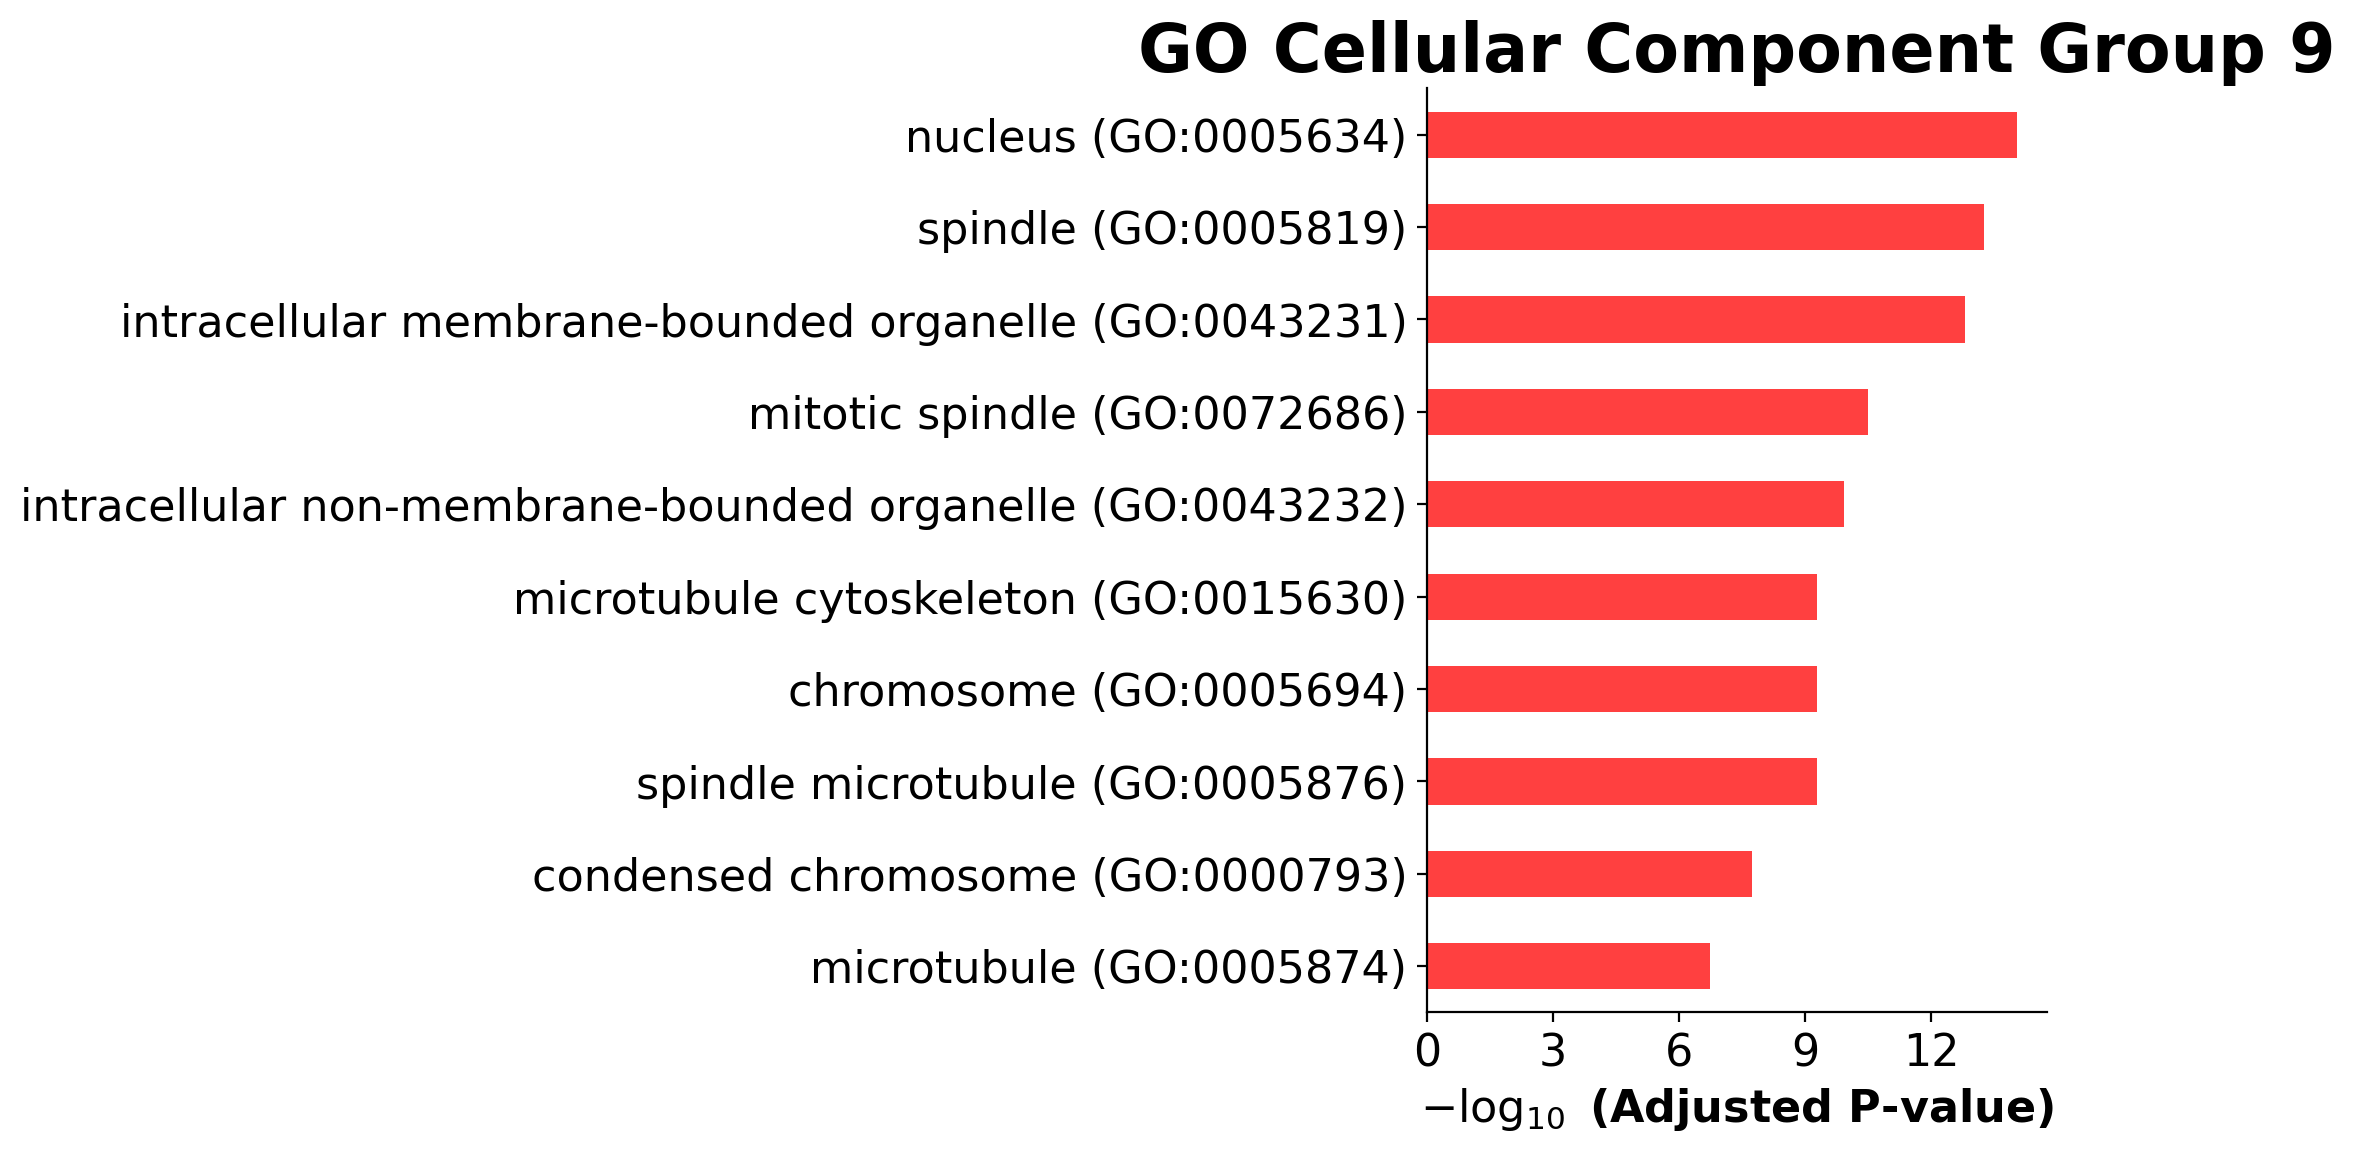

In [ ]:
enriched_pway_dict = {}
for group_num in gene_dict:

  # Put pathways into dictionary
  enr_gene_list = gene_dict[group_num]
  pway_list = get_enriched_pathways(enr_gene_list)
  enriched_pway_dict[group_num] = pway_list

  # Plot pathways
  gobp = pway_list[0]
  try:
    barplot(gobp.res2d,title=f'GO Biological Processes Group {group_num}',color = 'r')
  except ValueError:
    print(f"No differentially expressed genes associated with biological pathways for group {group_num}")

  gomf = pway_list[1]
  try:
    barplot(gomf.res2d,title=f'GO Molecular Function Group {group_num}',color = 'r')
  except ValueError:
    print(f"No differentially expressed genes associated with molecular function for group {group_num}")

  gocc = pway_list[2]
  try:
      barplot(gocc.res2d,title=f'GO Cellular Component Group {group_num}',color = 'r')
  except ValueError:
    print(f"No differentially expressed genes associated with cellular components for group {group_num}")







In [ ]:
print(enriched_pway_dict)

{'0': [<gseapy.enrichr.Enrichr object at 0x7ccf3b5044d0>, <gseapy.enrichr.Enrichr object at 0x7ccf38007f10>, <gseapy.enrichr.Enrichr object at 0x7ccf3b3514d0>], '1': [<gseapy.enrichr.Enrichr object at 0x7cd0ee68f750>, <gseapy.enrichr.Enrichr object at 0x7ccf3b1d55d0>, <gseapy.enrichr.Enrichr object at 0x7ccf3b0f4ad0>], '2': [<gseapy.enrichr.Enrichr object at 0x7ccf383bcad0>, <gseapy.enrichr.Enrichr object at 0x7ccf384d3f50>, <gseapy.enrichr.Enrichr object at 0x7ccf380fd850>], '3': [<gseapy.enrichr.Enrichr object at 0x7ccf3b864450>, <gseapy.enrichr.Enrichr object at 0x7ccf3b444f90>, <gseapy.enrichr.Enrichr object at 0x7ccf38016c50>], '4': [<gseapy.enrichr.Enrichr object at 0x7ccf43717510>, <gseapy.enrichr.Enrichr object at 0x7ccf39c56110>, <gseapy.enrichr.Enrichr object at 0x7ccf44b89250>], '5': [<gseapy.enrichr.Enrichr object at 0x7ccf39f7a150>, <gseapy.enrichr.Enrichr object at 0x7ccf39779c90>, <gseapy.enrichr.Enrichr object at 0x7ccfe3dfa890>], '6': [<gseapy.enrichr.Enrichr object at